# Import Libraries and Directories

In [1]:
import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
from datetime import datetime
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns

Data_path_GDrive = "G:/Il mio Drive/Thesis_Large_Files/Working Table"
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"
results_dir_ = 'C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results'
results_dir = os.path.join(results_dir_, datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '_BinaryProduction')
os.makedirs(results_dir, exist_ok=True)
plot_dir = os.path.join(results_dir,'Plot')
yearly_plot_dir = os.path.join(plot_dir,'Yearly_Plot')
weekly_plot_dir = os.path.join(plot_dir,'Weekly_Plot')
os.makedirs(yearly_plot_dir, exist_ok=True)
os.makedirs(weekly_plot_dir, exist_ok=True)


# Optimization with Gurobi

In [3]:
# Paths to directories
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'

# Load Working Tables for every optimization try
DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0)

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Consumption = pd.read_csv(os.path.join(Data_path_Consumption, '2019_ConsumptionCurve.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Convert the indices of the user DataFrames to strings
DF_m2_Residential['full_id'] = DF_m2_Residential['full_id'].astype(str)
DF_m2_Industrial['full_id'] = DF_m2_Industrial['full_id'].astype(str)
DF_m2_Commercial['full_id'] = DF_m2_Commercial['full_id'].astype(str)

# Set the maximum area constraint
Area_Res_Max = 1000000
Area_Ind_Max = 20000
Area_Com_Max = 50000

# Define the yearlist based on the number of hours
yearlist = DF_Production.index

# Create a new Gurobi model
m = gp.Model("Optimization_Model_BinaryonProduction")

# Production Binary Variables [0;1]
binary_vars_production_residential = m.addVars(DF_m2_Residential['full_id'], vtype=GRB.BINARY, name="binary_production_residential")
binary_vars_production_industrial = m.addVars(DF_m2_Industrial['full_id'], vtype=GRB.BINARY, name="binary_production_industrial")
binary_vars_production_commercial = m.addVars(DF_m2_Commercial['full_id'], vtype=GRB.BINARY, name="binary_production_commercial")

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to 1 for binary variables
for var in binary_vars_production_residential.values():
    var.start = 1
for var in binary_vars_production_industrial.values():
    var.start = 1
for var in binary_vars_production_commercial.values():
    var.start = 1

# Calculate the difference between production and consumption for each hour
difference = {}
for t in yearlist:
    residential_diff = gp.quicksum(
        binary_vars_production_residential[user] * Residential_user_production_df.loc[t, user] 
        for user in DF_m2_Residential['full_id']
    )
    industrial_diff = gp.quicksum(
        binary_vars_production_industrial[user] * Industrial_user_production_df.loc[t, user] 
        for user in DF_m2_Industrial['full_id']
    )
    commercial_diff = gp.quicksum(
        binary_vars_production_commercial[user] * Commercial_user_production_df.loc[t, user] 
        for user in DF_m2_Commercial['full_id']
    )
    
    # Calculate total difference for the hour
    difference[t] = (
        residential_diff - (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max) +
        industrial_diff - (DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max) +
        commercial_diff - (DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max)
    )

# Add constraint to define the absolute value of the deviation
for t in yearlist:
    m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
    m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

# Objective function: minimize the deviation
m.setObjective(gp.quicksum(deviation[t] for t in yearlist), GRB.MINIMIZE)

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_values = {i: binary_vars_production_residential[i].X for i in DF_m2_Residential['full_id']}
IP_values = {i: binary_vars_production_industrial[i].X for i in DF_m2_Industrial['full_id']}
CP_values = {i: binary_vars_production_commercial[i].X for i in DF_m2_Commercial['full_id']}

# Create new DataFrames with the chosen binary variables
DF_m2_Residential['Chosen'] = [RP_values[user] for user in DF_m2_Residential['full_id']]
DF_m2_Industrial['Chosen'] = [IP_values[user] for user in DF_m2_Industrial['full_id']]
DF_m2_Commercial['Chosen'] = [CP_values[user] for user in DF_m2_Commercial['full_id']]

chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Save the results to CSV files
chosen_residential.to_csv(os.path.join(results_dir, 'chosen_residential_Test.csv'))
chosen_industrial.to_csv(os.path.join(results_dir, 'chosen_industrial_Test.csv'))
chosen_commercial.to_csv(os.path.join(results_dir, 'chosen_commercial_Test.csv'))

# Calculate the number of chosen users versus the total number of users for each category
num_residential_chosen = len(chosen_residential)
num_residential_total = len(DF_m2_Residential)

num_industrial_chosen = len(chosen_industrial)
num_industrial_total = len(DF_m2_Industrial)

num_commercial_chosen = len(chosen_commercial)
num_commercial_total = len(DF_m2_Commercial)

# Print the amounts
print(f'Residential: Chosen = {num_residential_chosen}, Total = {num_residential_total}')
print(f'Industrial: Chosen = {num_industrial_chosen}, Total = {num_industrial_total}')
print(f'Commercial: Chosen = {num_commercial_chosen}, Total = {num_commercial_total}')


Set parameter MIPGap to value 0.005
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17520 rows, 16922 columns and 69769972 nonzeros
Model fingerprint: 0x10fb1a6b
Variable types: 8760 continuous, 8162 integer (8162 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 6e+06]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 14s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 23s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 27s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 32s
User MIP start produced solution with objective 1.69688e+10 (32.14s)
User MIP start 

In [16]:
import os
import pandas as pd

# Define the file paths
PUN_MGP_path = r'C:\Users\Nik\Documents\GitHub\Thesis\CSV\PUN_MGP'

# Load the PUN.csv (hourly energy price in Eur/Wh) and MGP.csv (consumption price in Eur/Wh)
PUN_df = pd.read_csv(os.path.join(PUN_MGP_path, 'PUN_SUD.csv'), sep=",", parse_dates=[0], index_col=0)
MGP_df = pd.read_csv(os.path.join(PUN_MGP_path, 'MGP_PrezziZonali_CSUD.csv'), sep=",", parse_dates=[0], index_col=0)

pun_prices = PUN_df["SUD [Eur/Wh]"]  # Column for production prices in €/Wh
mgp_prices = MGP_df["SUD [Eur/Wh]"]  # Column for consumption prices in €/Wh

# Convert all values to strings, then replace commas with dots, and finally convert to floats
pun_prices_cleaned = pun_prices.astype(str).str.replace(',', '.').astype(float)
mgp_prices_cleaned = mgp_prices.astype(str).str.replace(',', '.').astype(float)

# Define the yearlist based on the number of hours
yearlist = Residential_user_production_df.index

# Select the users that were chosen for production (previous optimization results)
chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Create empty lists to store the hourly results
hourly_revenue_residential = []
hourly_revenue_industrial = []
hourly_revenue_commercial = []

hourly_consumption_cost_residential = []
hourly_consumption_cost_industrial = []
hourly_consumption_cost_commercial = []

hourly_profit_residential = []
hourly_profit_industrial = []
hourly_profit_commercial = []

# Calculate hourly production revenue and consumption cost using vectorized operations
for t in yearlist:
    if t in pun_prices_cleaned.index and t in mgp_prices_cleaned.index:
        # Ensure the price is a scalar value using `.at` for efficient scalar access
        price_for_hour = pun_prices_cleaned.at[t]
        consumption_price_for_hour = mgp_prices_cleaned.at[t]

        # Revenue for residential, industrial, and commercial users (vectorized)
        residential_revenue = (Residential_user_production_df.loc[t, chosen_residential['full_id']].sum() * price_for_hour)
        industrial_revenue = (Industrial_user_production_df.loc[t, chosen_industrial['full_id']].sum() * price_for_hour)
        commercial_revenue = (Commercial_user_production_df.loc[t, chosen_commercial['full_id']].sum() * price_for_hour)

        # Store the hourly revenues
        hourly_revenue_residential.append(residential_revenue)
        hourly_revenue_industrial.append(industrial_revenue)
        hourly_revenue_commercial.append(commercial_revenue)

        # Consumption cost for residential, industrial, and commercial users (vectorized)
        residential_consumption_cost = DF_Consumption.loc[t, 'Residential'] * Area_Res_Max * consumption_price_for_hour
        industrial_consumption_cost = DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max * consumption_price_for_hour
        commercial_consumption_cost = DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max * consumption_price_for_hour

        # Store the hourly consumption costs
        hourly_consumption_cost_residential.append(residential_consumption_cost)
        hourly_consumption_cost_industrial.append(industrial_consumption_cost)
        hourly_consumption_cost_commercial.append(commercial_consumption_cost)

        # Calculate hourly profit (revenue - cost)
        residential_profit = residential_revenue - residential_consumption_cost
        industrial_profit = industrial_revenue - industrial_consumption_cost
        commercial_profit = commercial_revenue - commercial_consumption_cost

        # Store the hourly profits
        hourly_profit_residential.append(residential_profit)
        hourly_profit_industrial.append(industrial_profit)
        hourly_profit_commercial.append(commercial_profit)

# Summarize results into a DataFrame and save them
results = {
    'Metric': ['Hourly Revenue [€]', 'Hourly Consumption Cost [€]', 'Hourly Profit [€]'],
    'Residential': [sum(hourly_revenue_residential), sum(hourly_consumption_cost_residential), sum(hourly_profit_residential)],
    'Industrial': [sum(hourly_revenue_industrial), sum(hourly_consumption_cost_industrial), sum(hourly_profit_industrial)],
    'Commercial': [sum(hourly_revenue_commercial), sum(hourly_consumption_cost_commercial), sum(hourly_profit_commercial)],
}

results_df = pd.DataFrame(results)

# Define file paths to save results
results_dir = r'C:\Users\Nik\Documents\GitHub\Thesis\Results'
results_file_path_excel = os.path.join(results_dir, 'Hourly_Results.xlsx')
results_file_path_csv = os.path.join(results_dir, 'Hourly_Results.csv')

# Save the results
results_df.to_excel(results_file_path_excel, index=False)
results_df.to_csv(results_file_path_csv, index=False)

print(f'Results saved to {results_file_path_excel} and {results_file_path_csv}')


Results saved to C:\Users\Nik\Documents\GitHub\Thesis\Results\Hourly_Results.xlsx and C:\Users\Nik\Documents\GitHub\Thesis\Results\Hourly_Results.csv


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (4, 2).

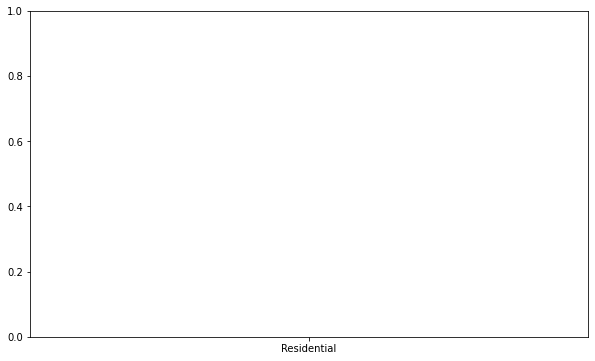

In [21]:
import matplotlib.pyplot as plt

# Create the yearly profit bar chart
yearly_profit = results_df[results_df['Metric'] == 'Hourly Profit [€]']

# Calculate the overall profit
overall_profit = yearly_profit[['Residential', 'Industrial', 'Commercial']].sum(axis=1)

# Bar chart for total yearly profit
plt.figure(figsize=(10, 6))
plt.bar(['Residential', 'Industrial', 'Commercial', 'Overall'], 
        [yearly_profit['Residential'].values[0], 
         yearly_profit['Industrial'].values[0], 
         yearly_profit['Commercial'].values[0], 
         overall_profit.values[0]],
        color=['blue', 'green', 'orange', 'red'])

plt.title('Yearly Profit for Residential, Industrial, and Commercial Sectors')
plt.ylabel('Profit (€)')
plt.xlabel('Sector')
plt.show()


In [18]:
# Group the monthly results for revenue, cost, and profit
monthly_data = pd.DataFrame({
    'Month': monthly_profit_df.index,
    'Revenue': monthly_revenue,
    'Cost': monthly_cost,
    'Profit': monthly_profit
})

# Plot monthly profit, revenue, and cost as a bar chart
monthly_data.plot(kind='bar', x='Month', y=['Revenue', 'Cost', 'Profit'], figsize=(12, 6), color=['blue', 'orange', 'green'])

plt.title('Monthly Revenue, Cost, and Profit for Each Sector')
plt.ylabel('Amount (in W)')
plt.xlabel('Month')
plt.show()


NameError: name 'monthly_profit_df' is not defined

In [19]:
# Create line graphs for monthly cost, sell energy (revenue), and profit
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Month'], monthly_data['Revenue'], label="Sell Energy (Revenue)", marker='o', color='blue')
plt.plot(monthly_data['Month'], monthly_data['Cost'], label="Consumption Cost", marker='o', color='orange')
plt.plot(monthly_data['Month'], monthly_data['Profit'], label="Profit", marker='o', color='green')

plt.title('Monthly Trends: Cost, Sell Energy, and Profit')
plt.ylabel('Amount (in W)')
plt.xlabel('Month')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'monthly_data' is not defined

<Figure size 864x432 with 0 Axes>

In [4]:
# Calculate total production for residential, industrial, and commercial over time
total_production_residential = [
    sum(RP_values[user] * Residential_user_production_df.loc[t, user] for user in DF_m2_Residential['full_id'])
    for t in yearlist
]

total_production_industrial = [
    sum(IP_values[user] * Industrial_user_production_df.loc[t, user] for user in DF_m2_Industrial['full_id'])
    for t in yearlist
]

total_production_commercial = [
    sum(CP_values[user] * Commercial_user_production_df.loc[t, user] for user in DF_m2_Commercial['full_id'])
    for t in yearlist
]

# Calculate total annual production and consumption difference
total_annual_production_residential = sum(total_production_residential)
total_annual_consumption_residential = DF_Consumption['Residential'].sum() * Area_Res_Max
annual_difference_residential = total_annual_production_residential - total_annual_consumption_residential

total_annual_production_industrial = sum(total_production_industrial)
total_annual_consumption_industrial = DF_Consumption['Industrial'].sum() * Area_Ind_Max
annual_difference_industrial = total_annual_production_industrial - total_annual_consumption_industrial

total_annual_production_commercial = sum(total_production_commercial)
total_annual_consumption_commercial = DF_Consumption['Commercial'].sum() * Area_Com_Max
annual_difference_commercial = total_annual_production_commercial - total_annual_consumption_commercial

total_overall_difference = annual_difference_residential + annual_difference_industrial + annual_difference_commercial

# Calculate percentage of production over consumption for the entire year
percentage_annual_production_residential = (total_annual_production_residential / total_annual_consumption_residential) * 100
percentage_annual_production_industrial = (total_annual_production_industrial / total_annual_consumption_industrial) * 100
percentage_annual_production_commercial = (total_annual_production_commercial / total_annual_consumption_commercial) * 100
percentage_annual_production_overall = ((total_annual_production_residential + total_annual_production_industrial + total_annual_production_commercial) / 
                                        (total_annual_consumption_residential + total_annual_consumption_industrial + total_annual_consumption_commercial)) * 100

# Calculate daily percentage of production over consumption for each day of the year
DF_Consumption['Date'] = DF_Consumption.index.date
daily_consumption = DF_Consumption.groupby('Date').sum()

# Adjusted the column names to use correct format
daily_production_residential = Residential_user_production_df.groupby(Residential_user_production_df.index.date).sum().multiply(
    DF_m2_Residential['Chosen'].values, axis=1).sum(axis=1)
daily_percentage_residential = (daily_production_residential / (daily_consumption['Residential'] * Area_Res_Max)) * 100

daily_production_industrial = Industrial_user_production_df.groupby(Industrial_user_production_df.index.date).sum().multiply(
    DF_m2_Industrial['Chosen'].values, axis=1).sum(axis=1)
daily_percentage_industrial = (daily_production_industrial / (daily_consumption['Industrial'] * Area_Ind_Max)) * 100

daily_production_commercial = Commercial_user_production_df.groupby(Commercial_user_production_df.index.date).sum().multiply(
    DF_m2_Commercial['Chosen'].values, axis=1).sum(axis=1)
daily_percentage_commercial = (daily_production_commercial / (daily_consumption['Commercial'] * Area_Com_Max)) * 100

daily_production_overall = daily_production_residential + daily_production_industrial + daily_production_commercial
daily_consumption_overall = (daily_consumption['Residential'] * Area_Res_Max) + (daily_consumption['Industrial'] * Area_Ind_Max) + (daily_consumption['Commercial'] * Area_Com_Max)
daily_percentage_overall = (daily_production_overall / daily_consumption_overall) * 100

# Calculate daily percentage of production over consumption between 9:00 and 18:00 for each day
DF_Consumption['Hour'] = DF_Consumption.index.hour
daytime_consumption = DF_Consumption[(DF_Consumption['Hour'] >= 9) & (DF_Consumption['Hour'] <= 18)].groupby('Date').sum()

# Filter production data between 9:00 and 18:00 and group by date
daytime_production_residential = Residential_user_production_df.between_time('09:00', '18:00')
daytime_production_residential = daytime_production_residential.groupby(daytime_production_residential.index.date).sum().multiply(
    DF_m2_Residential['Chosen'].values, axis=1).sum(axis=1)
daytime_percentage_residential = (daytime_production_residential / (daytime_consumption['Residential'] * Area_Res_Max)) * 100

daytime_production_industrial = Industrial_user_production_df.between_time('09:00', '18:00')
daytime_production_industrial = daytime_production_industrial.groupby(daytime_production_industrial.index.date).sum().multiply(
    DF_m2_Industrial['Chosen'].values, axis=1).sum(axis=1)
daytime_percentage_industrial = (daytime_production_industrial / (daytime_consumption['Industrial'] * Area_Ind_Max)) * 100

daytime_production_commercial = Commercial_user_production_df.between_time('09:00', '18:00')
daytime_production_commercial = daytime_production_commercial.groupby(daytime_production_commercial.index.date).sum().multiply(
    DF_m2_Commercial['Chosen'].values, axis=1).sum(axis=1)
daytime_percentage_commercial = (daytime_production_commercial / (daytime_consumption['Commercial'] * Area_Com_Max)) * 100

daytime_production_overall = daytime_production_residential + daytime_production_industrial + daytime_production_commercial
daytime_consumption_overall = (daytime_consumption['Residential'] * Area_Res_Max) + (daytime_consumption['Industrial'] * Area_Ind_Max) + (daytime_consumption['Commercial'] * Area_Com_Max)
daytime_percentage_overall = (daytime_production_overall / daytime_consumption_overall) * 100

# Prepare data for saving
results = {
    'Metric': ['Total Production - Consumption Difference [W]', 'Annual Production over Consumption [%]', 'Daily Production over Consumption [%]', 'Daytime Production over Consumption (9-18) [%]'],
    'Residential': [annual_difference_residential, percentage_annual_production_residential, daily_percentage_residential.mean(), daytime_percentage_residential.mean()],
    'Industrial': [annual_difference_industrial, percentage_annual_production_industrial, daily_percentage_industrial.mean(), daytime_percentage_industrial.mean()],
    'Commercial': [annual_difference_commercial, percentage_annual_production_commercial, daily_percentage_commercial.mean(), daytime_percentage_commercial.mean()],
    'Overall' : [total_overall_difference, percentage_annual_production_overall, daily_percentage_overall.mean(), daytime_percentage_overall.mean()]
}

# Create DataFrame
results_df = pd.DataFrame(results)

# Save to Excel and CSV
results_file_path_excel = os.path.join(results_dir, 'Percentage Results.xlsx')
results_file_path_csv = os.path.join(results_dir, 'Percentage Results.csv')

results_df.to_excel(results_file_path_excel, index=False)
results_df.to_csv(results_file_path_csv, index=False)

print(f'Results saved to {results_file_path_excel} and {results_file_path_csv}')

# Calculate averages for chosen users in each category
def calculate_averages(df, category_name):
    avg_area = df['Area'].mean() if 'Area' in df.columns else None
    avg_s_coeff = df['S_coeff'].mean() if 'S_coeff' in df.columns else None
    avg_w_coeff = df['W_coeff'].mean() if 'W_coeff' in df.columns else None
    avg_e_coeff = df['E_coeff'].mean() if 'E_coeff' in df.columns else None

    return {
        'Category': category_name,
        'Average Area': avg_area,
        'Average S_coeff': avg_s_coeff,
        'Average W_coeff': avg_w_coeff,
        'Average E_coeff': avg_e_coeff
    }

# Calculate averages for each category
averages_residential = calculate_averages(chosen_residential, 'Residential')
averages_industrial = calculate_averages(chosen_industrial, 'Industrial')
averages_commercial = calculate_averages(chosen_commercial, 'Commercial')

# Combine results into a single DataFrame
averages_df = pd.DataFrame([averages_residential, averages_industrial, averages_commercial])

# Print the averages to check
print(averages_df)

# Save the results to CSV and Excel
averages_file_path_csv = os.path.join(results_dir, 'Averages_Chosen_Users.csv')
averages_file_path_excel = os.path.join(results_dir, 'Averages_Chosen_Users.xlsx')

averages_df.to_csv(averages_file_path_csv, index=False)
averages_df.to_excel(averages_file_path_excel, index=False)

print(f'Averages saved to {averages_file_path_csv} and {averages_file_path_excel}')



KeyboardInterrupt: 

## Plots

### Yearly Plots

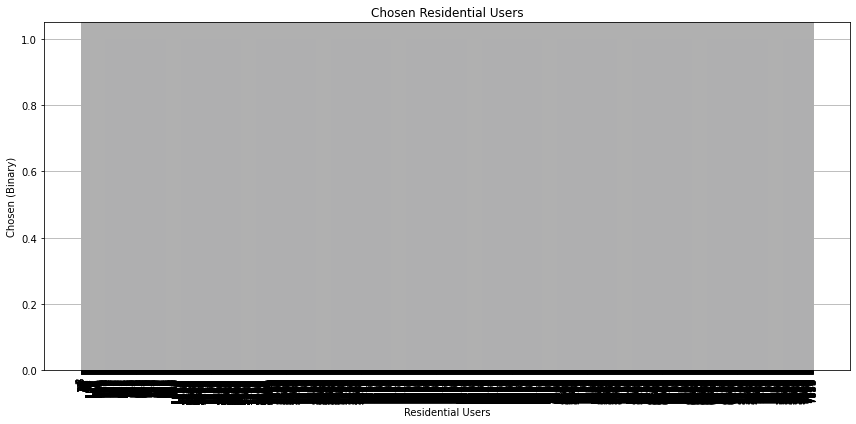

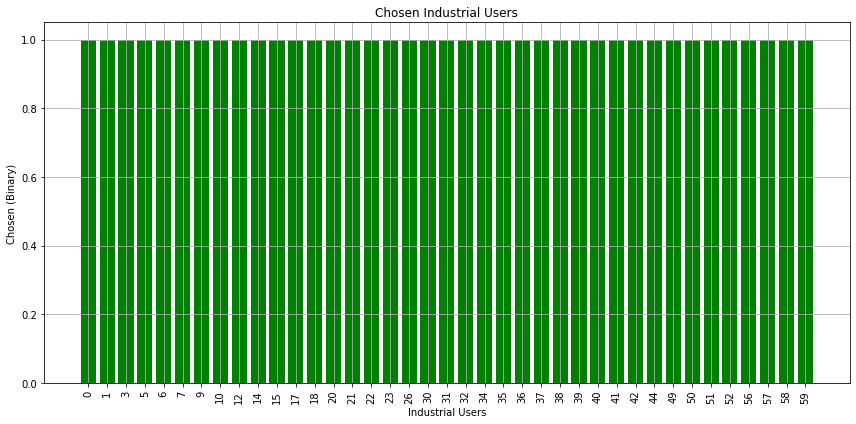

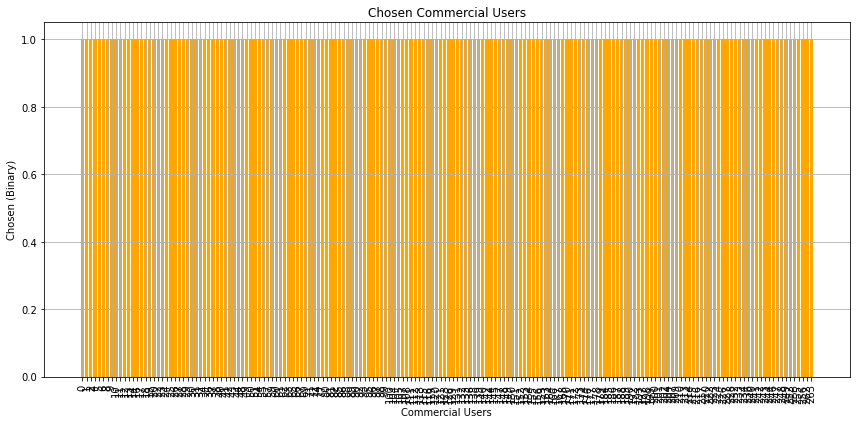

In [5]:
import matplotlib.pyplot as plt

# Convert indices to strings for better readability in plots
chosen_residential.index = chosen_residential.index.astype(str)
chosen_industrial.index = chosen_industrial.index.astype(str)
chosen_commercial.index = chosen_commercial.index.astype(str)

# Plot Chosen Residential Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_residential.index, chosen_residential['Chosen'], color='blue')
plt.xlabel('Residential Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Residential Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig(os.path.join(results_dir, 'Chosen_Residential_Users.png'))
plt.show()

# Plot Chosen Industrial Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_industrial.index, chosen_industrial['Chosen'], color='green')
plt.xlabel('Industrial Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Industrial Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig(os.path.join(results_dir, 'Chosen_Industrial_Users.png'))
plt.show()

# Plot Chosen Commercial Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_commercial.index, chosen_commercial['Chosen'], color='orange')
plt.xlabel('Commercial Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Commercial Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig(os.path.join(results_dir, 'Chosen_Commercial_Users.png'))
plt.show()


### Weekly Plots

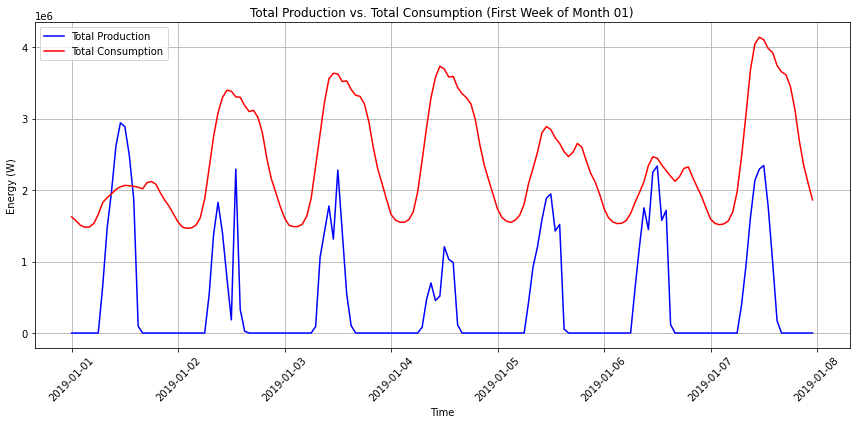

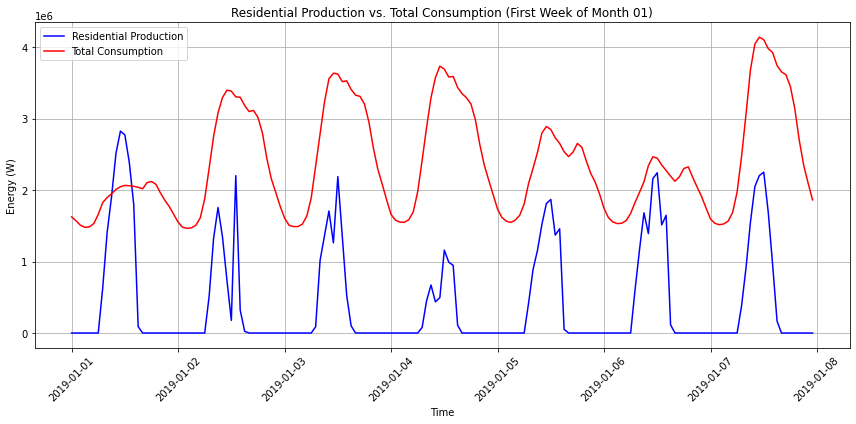

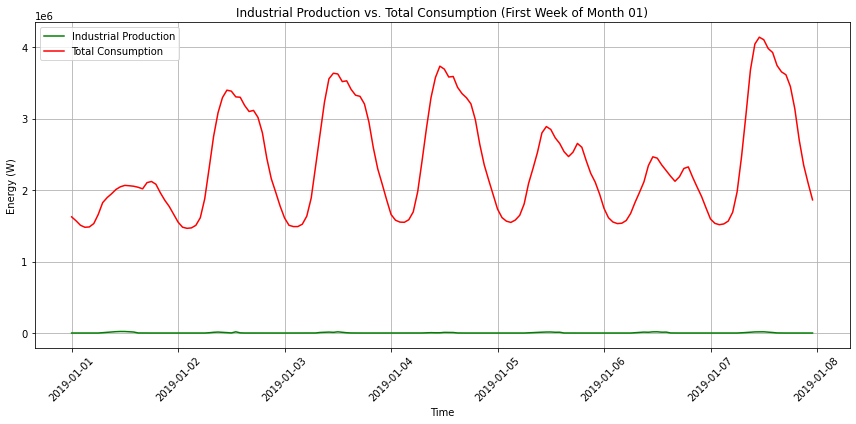

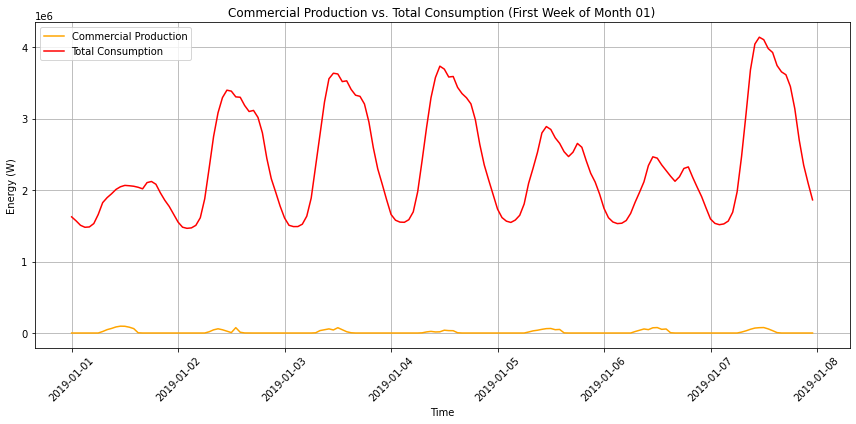

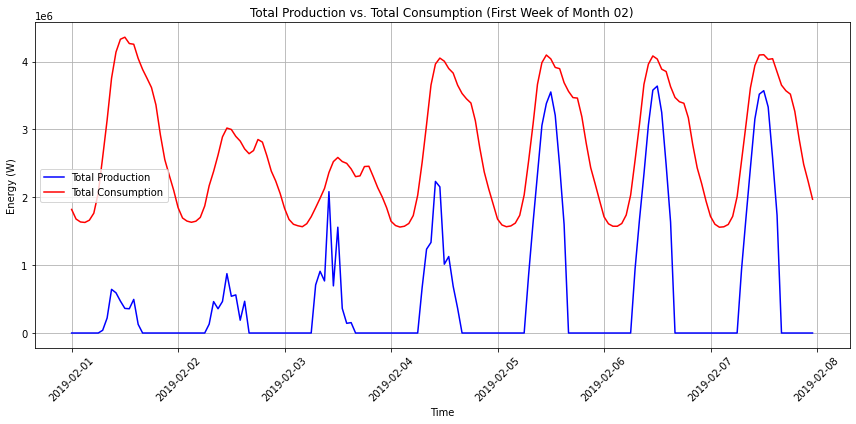

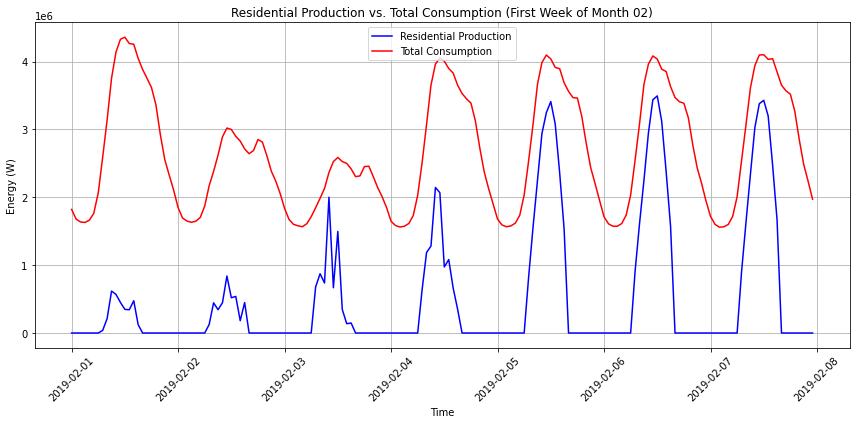

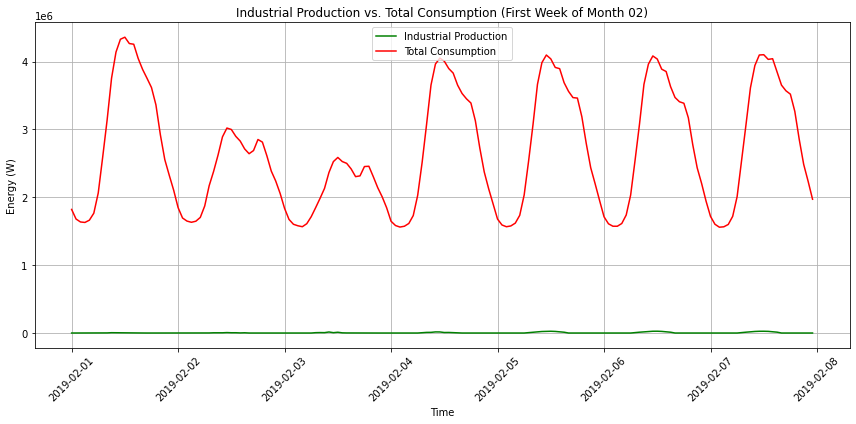

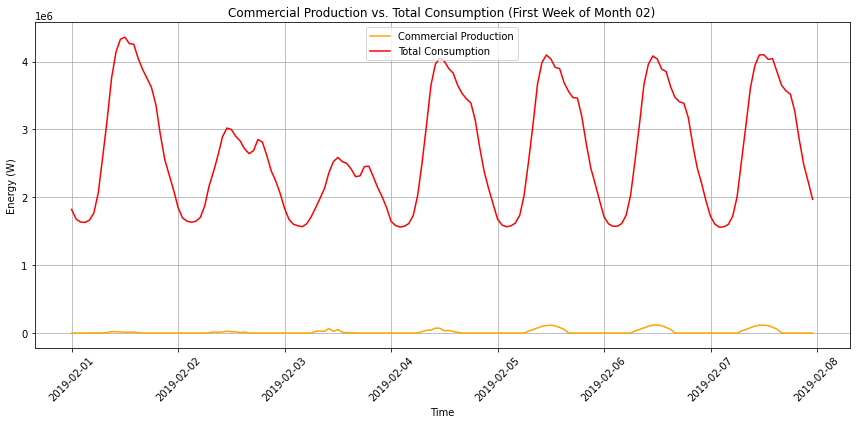

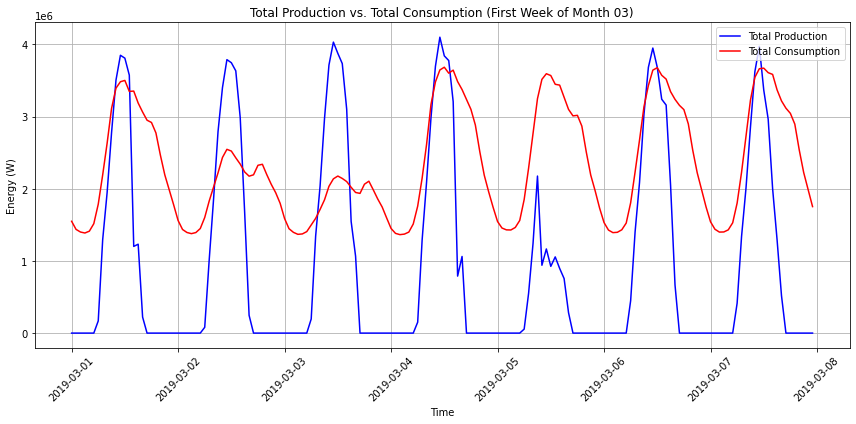

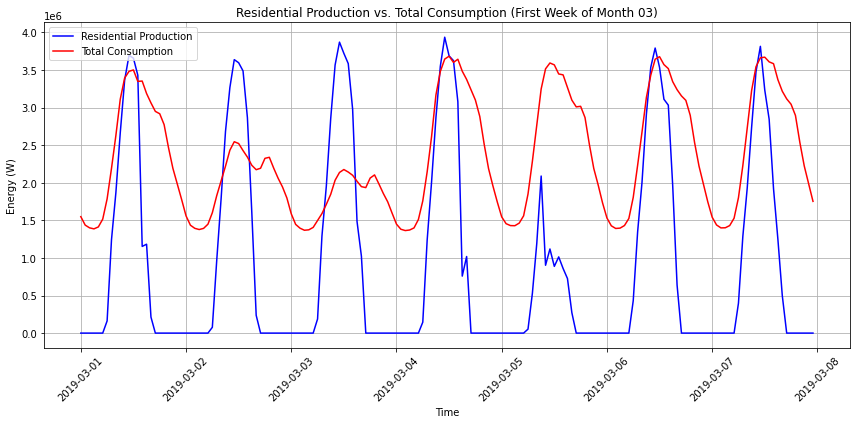

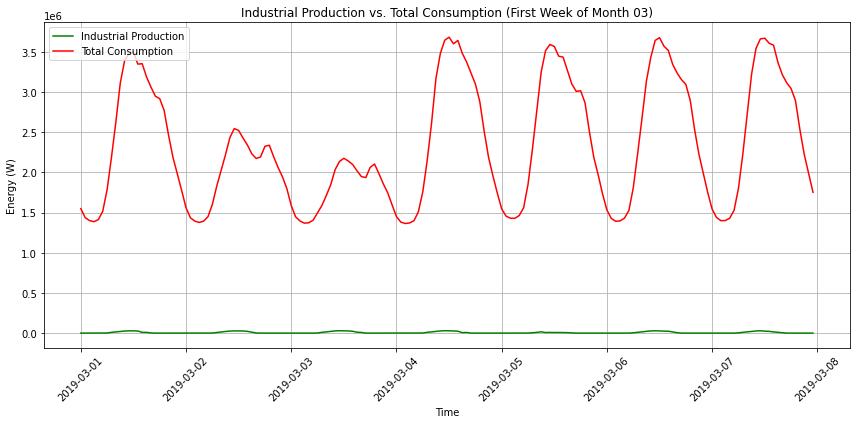

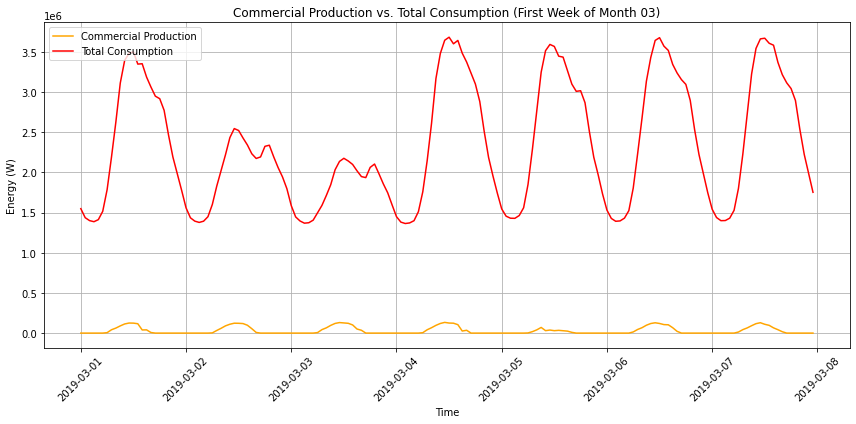

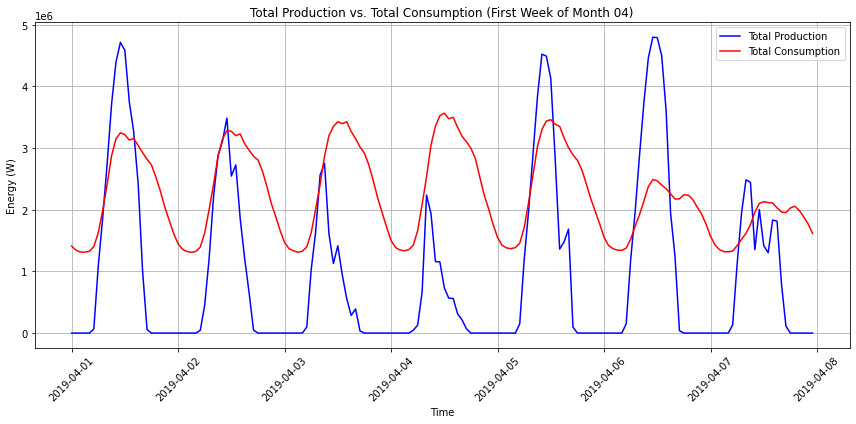

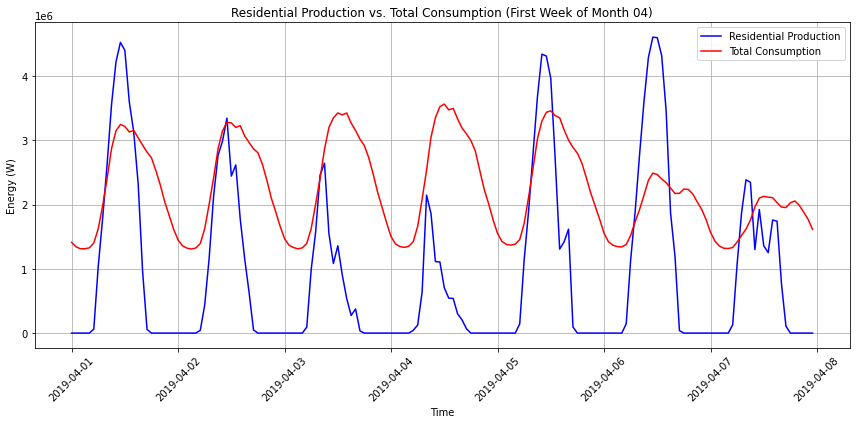

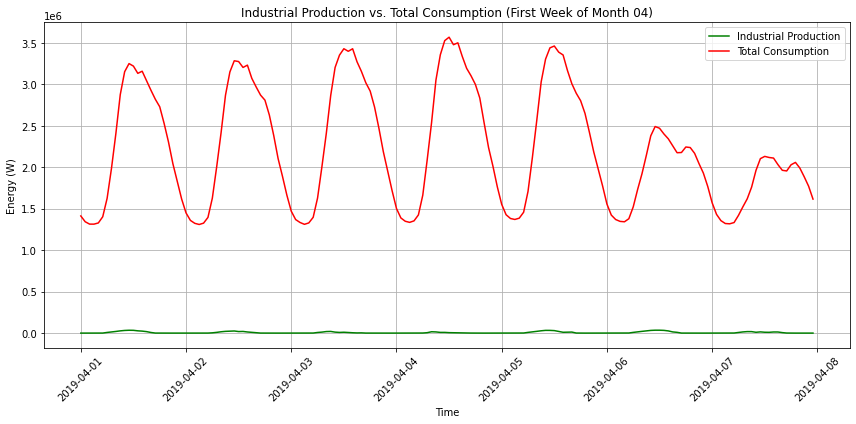

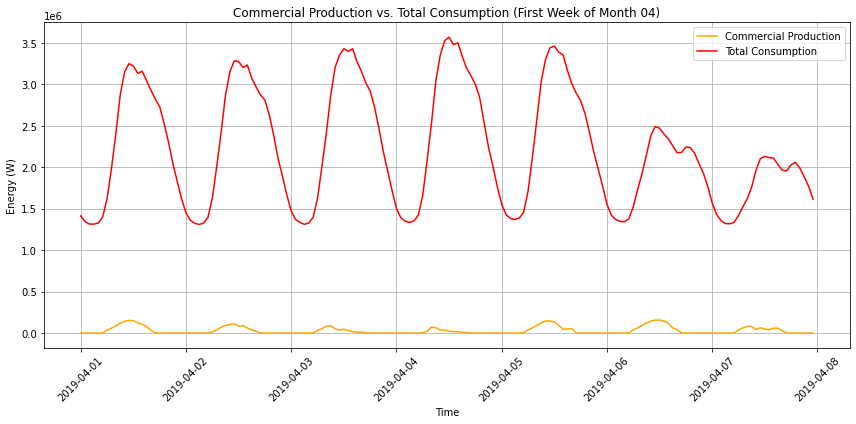

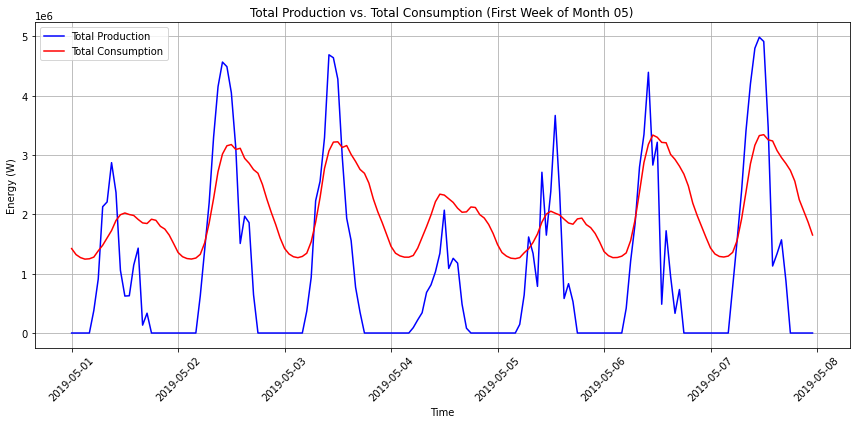

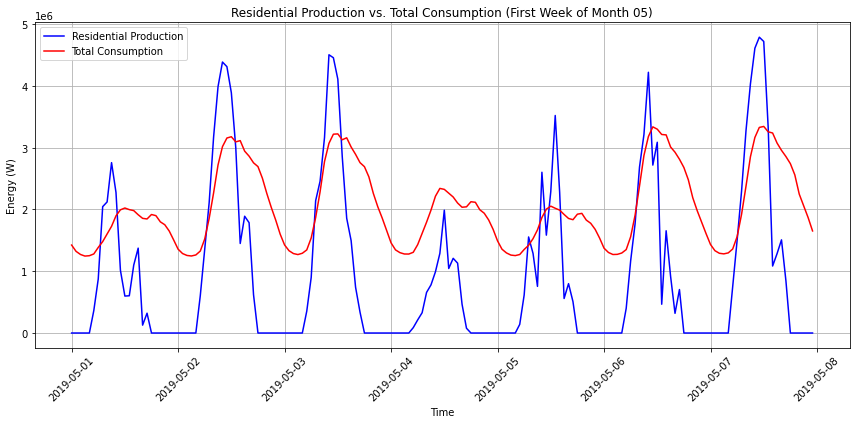

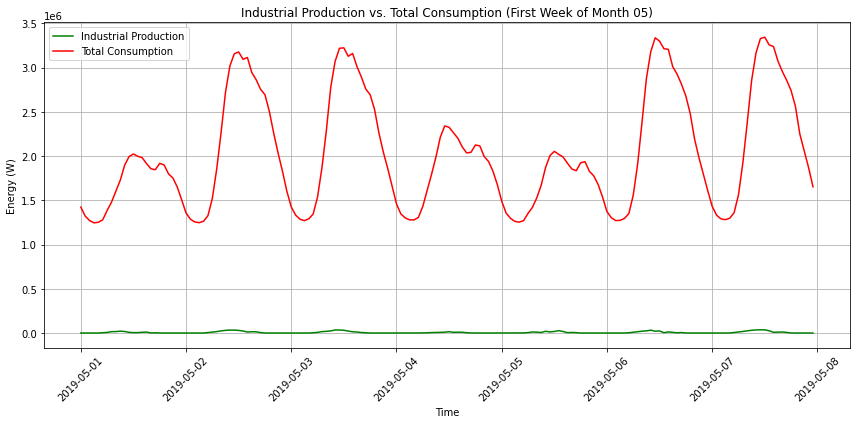

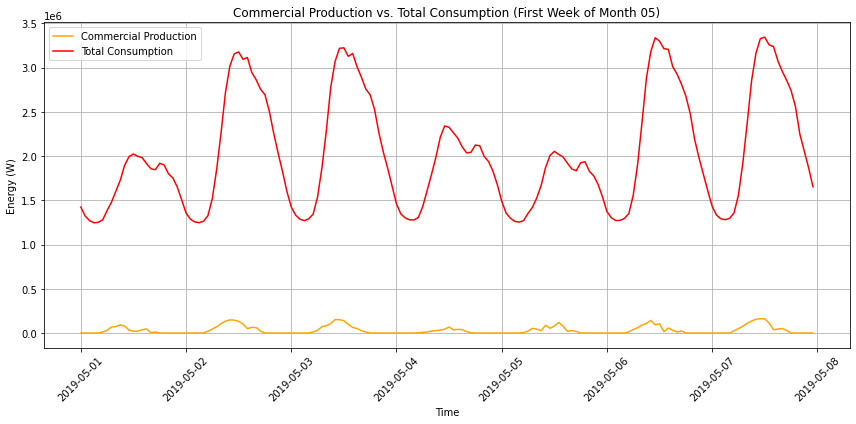

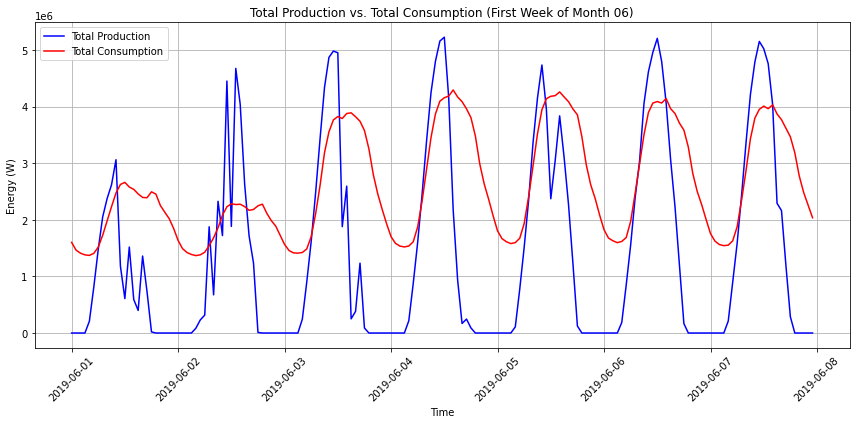

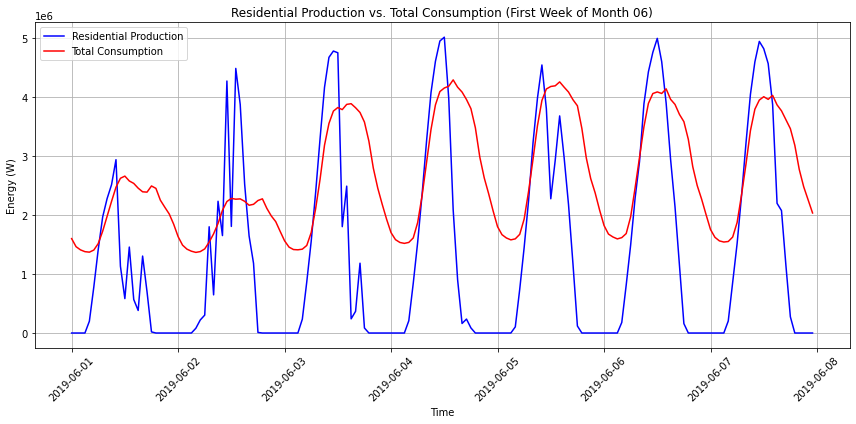

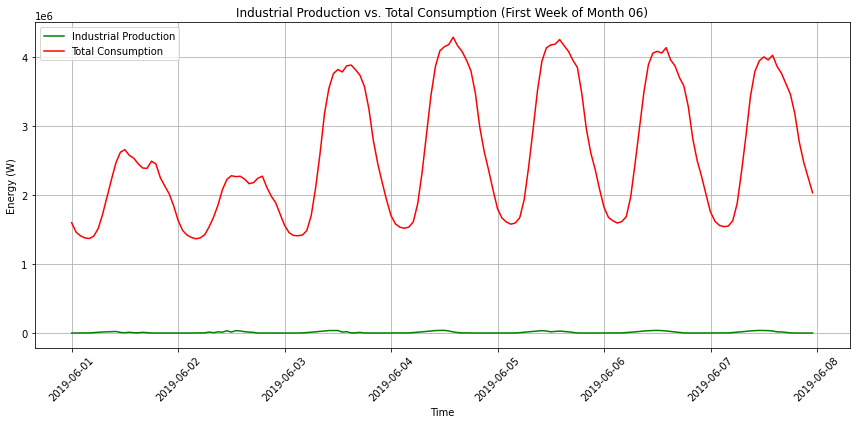

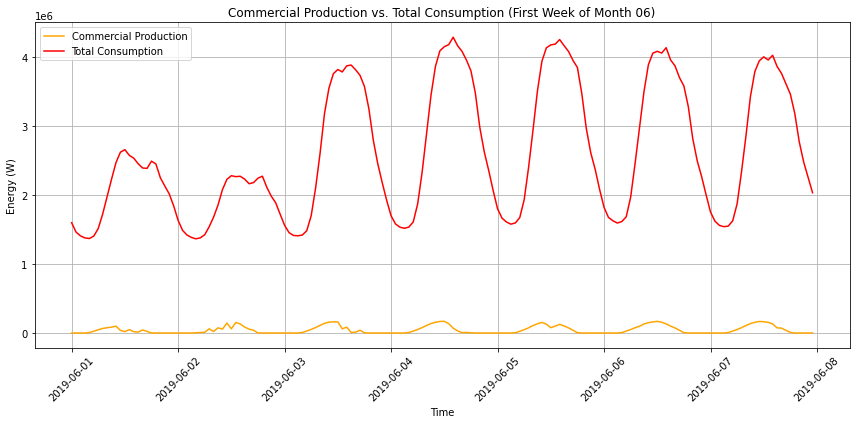

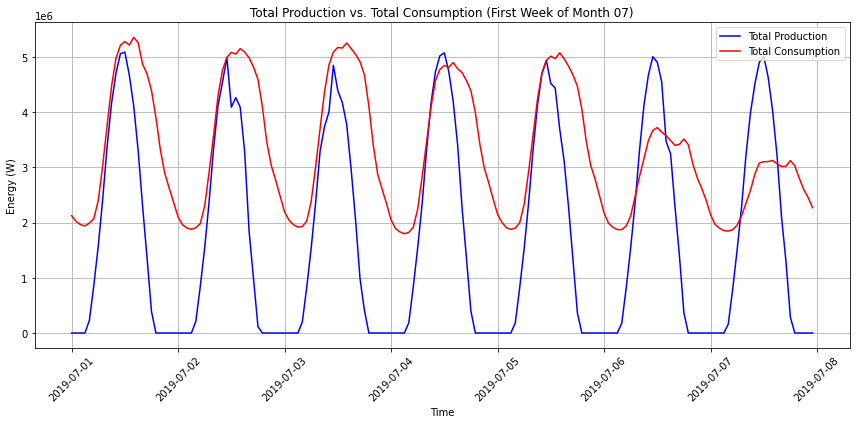

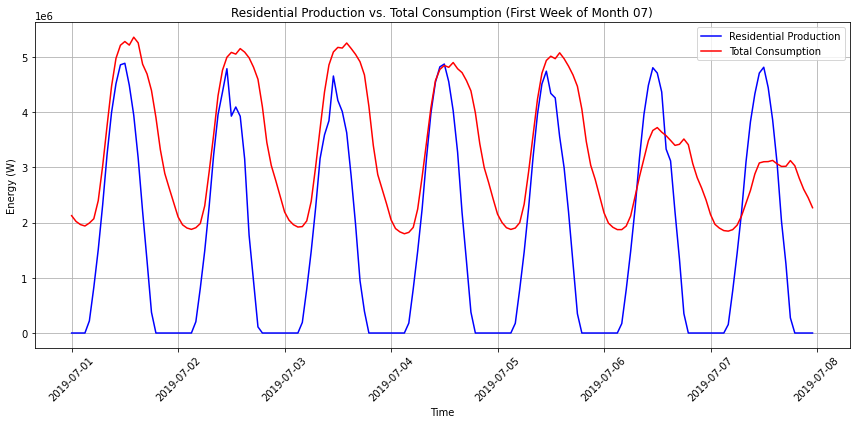

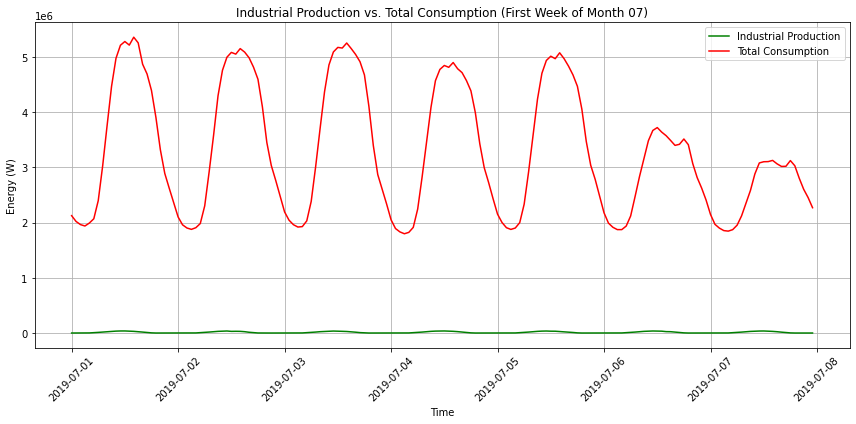

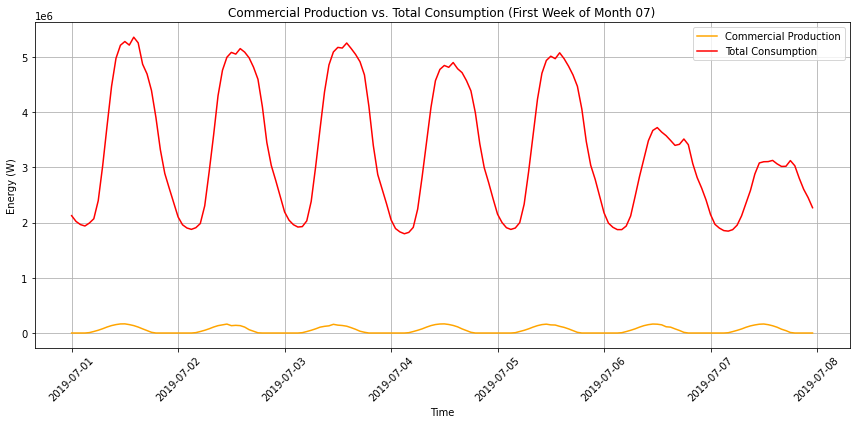

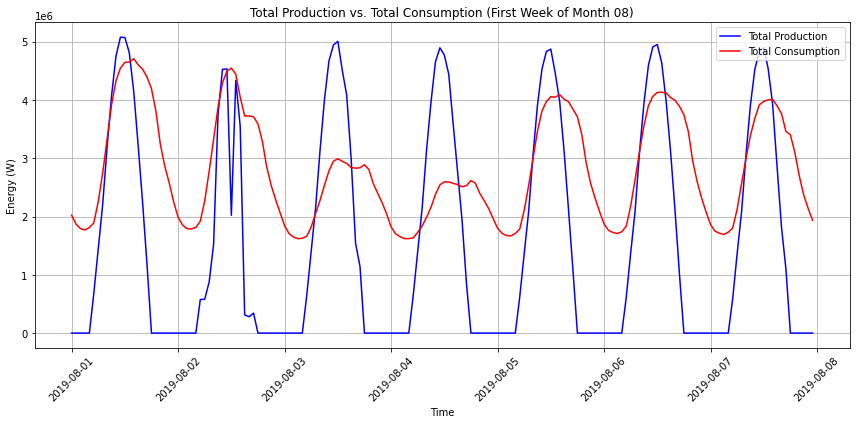

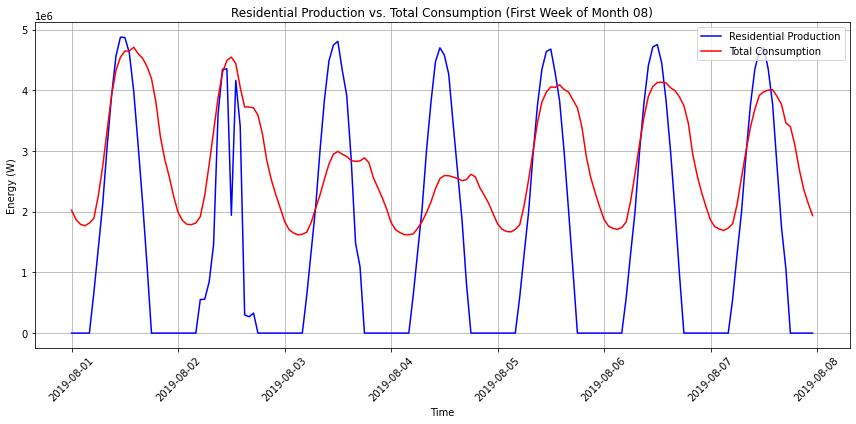

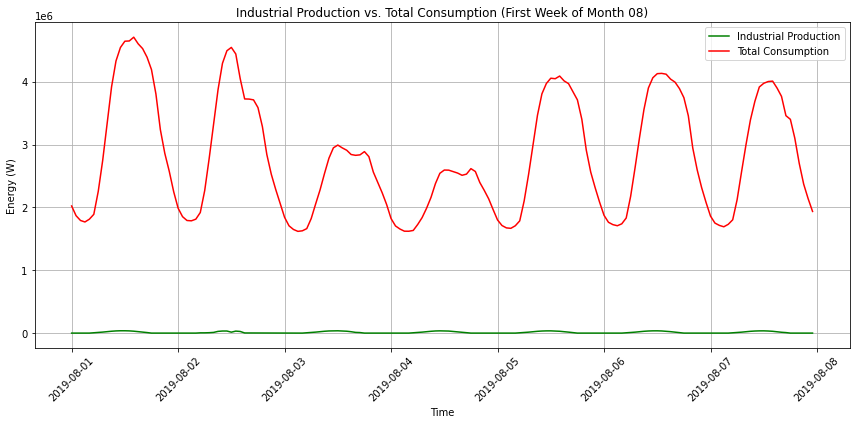

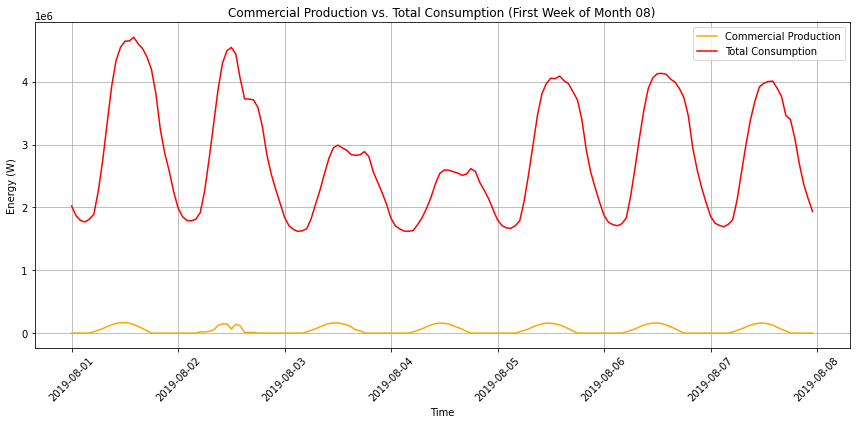

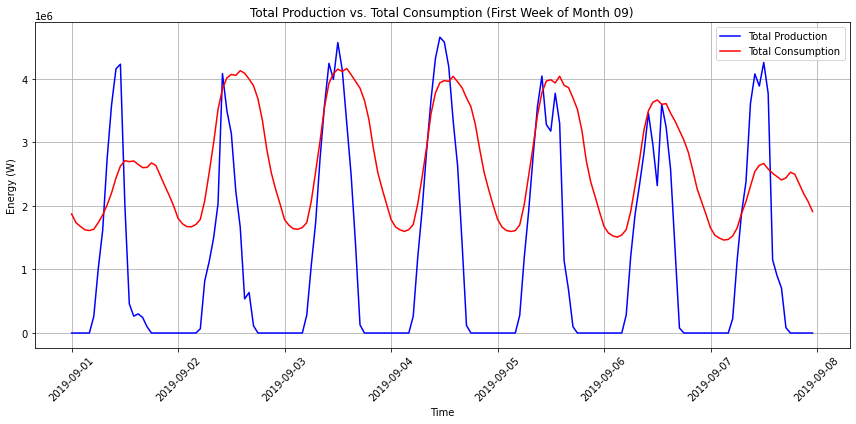

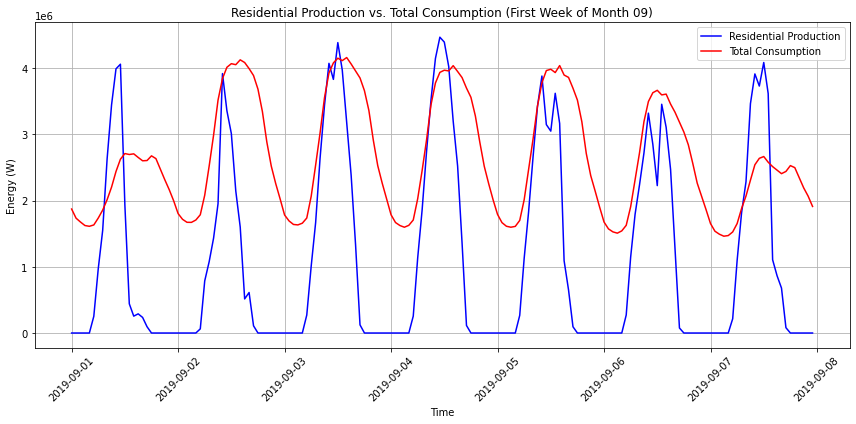

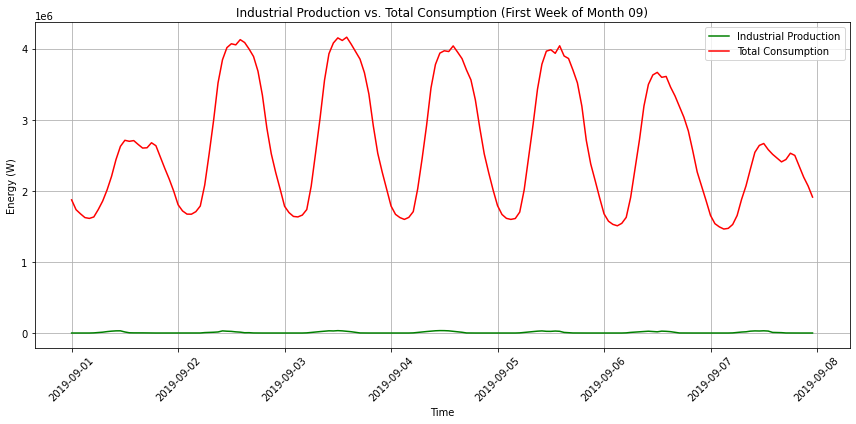

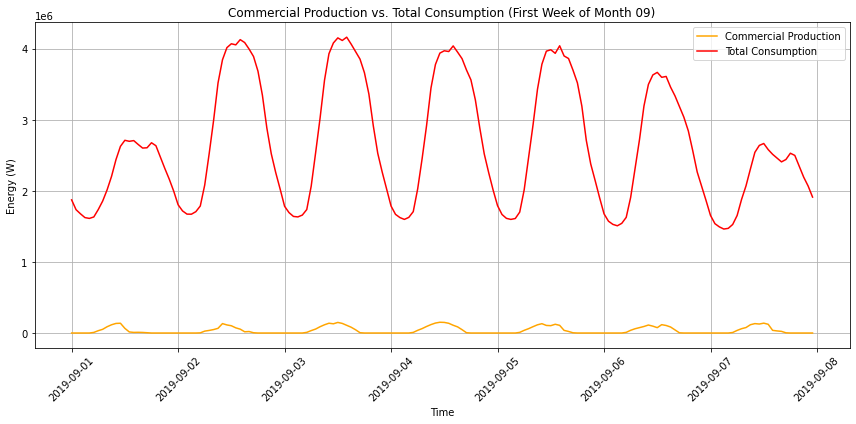

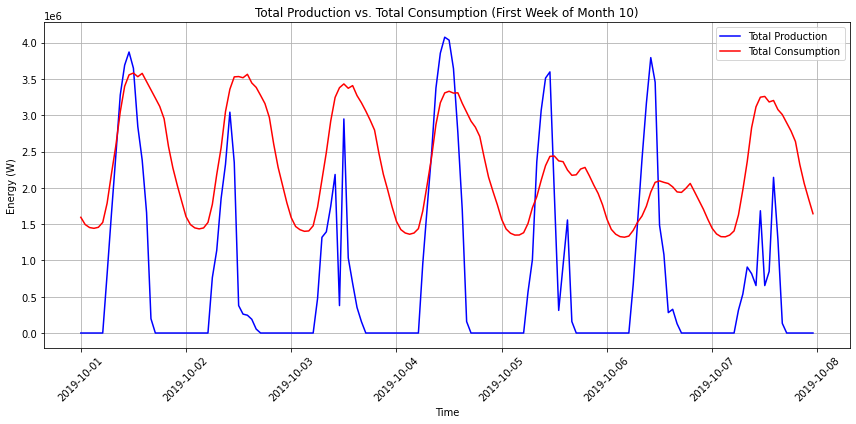

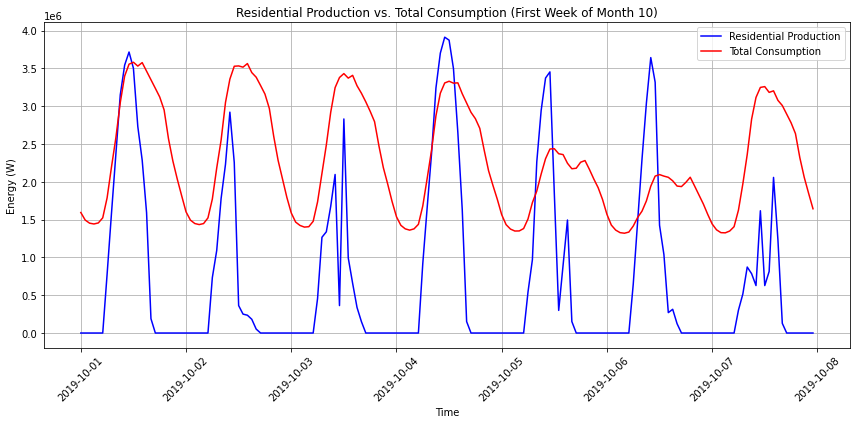

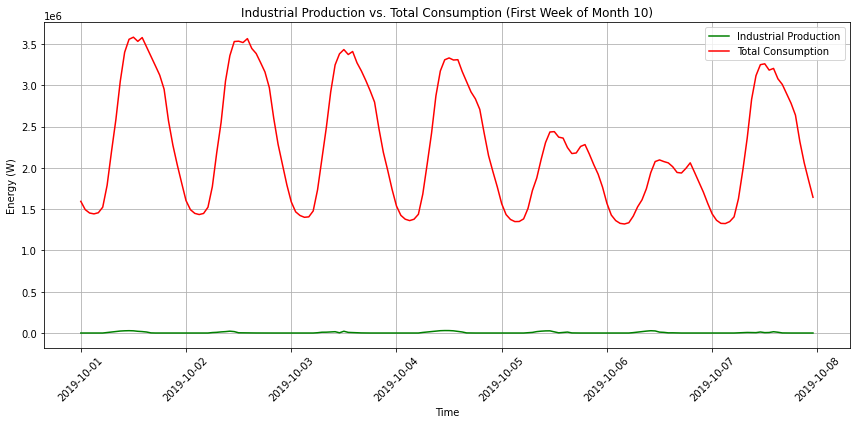

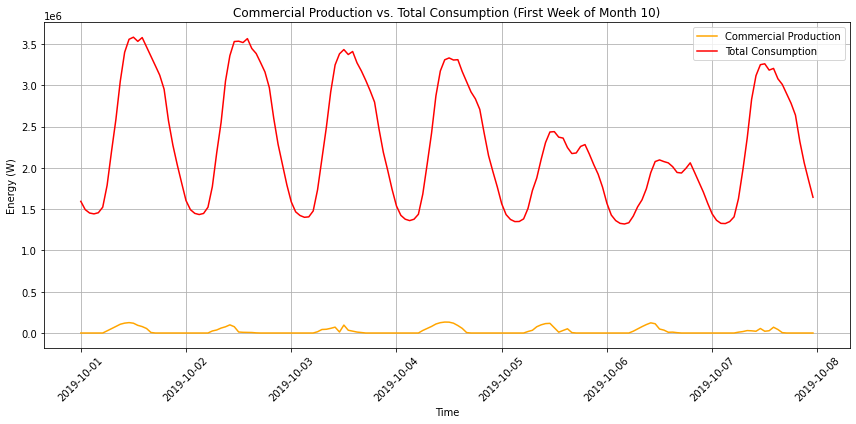

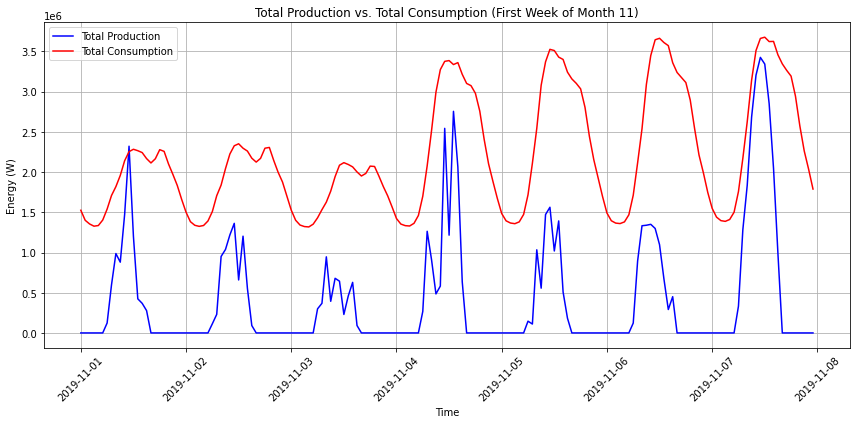

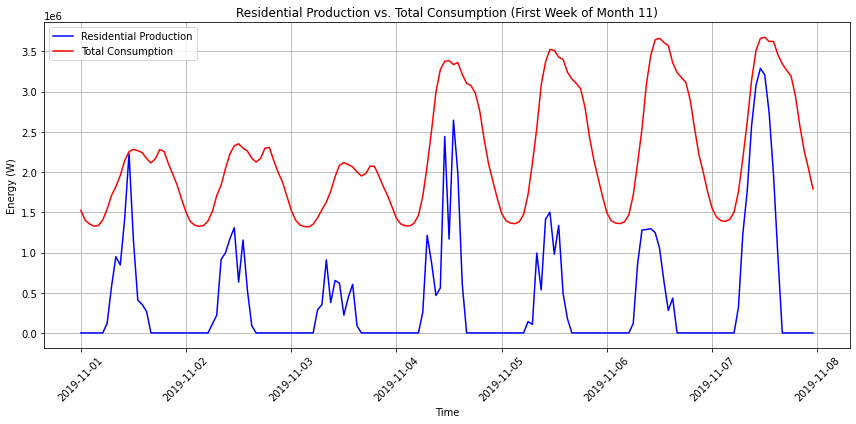

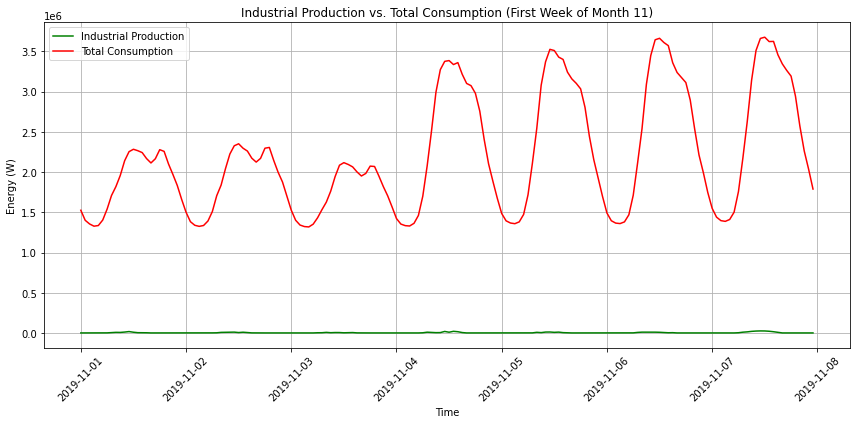

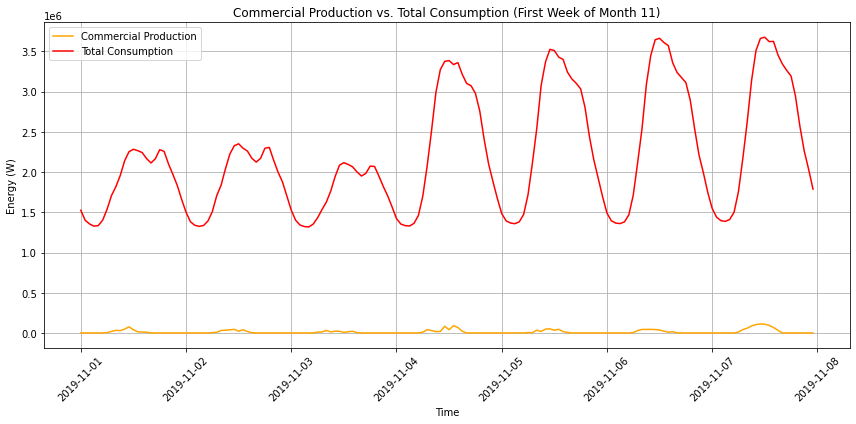

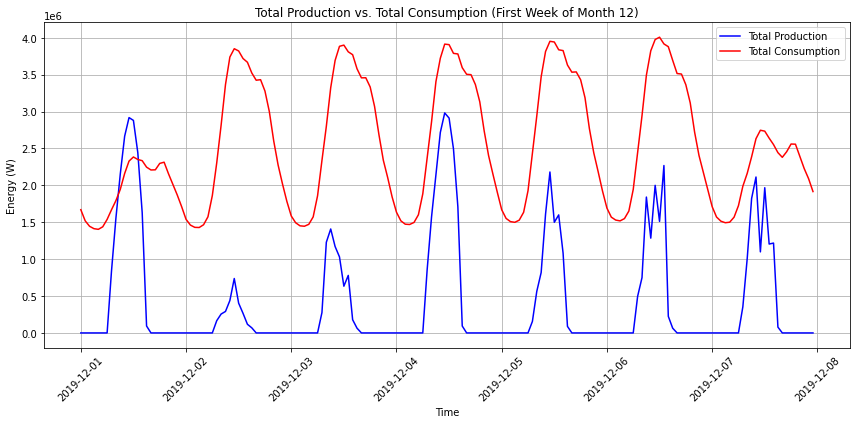

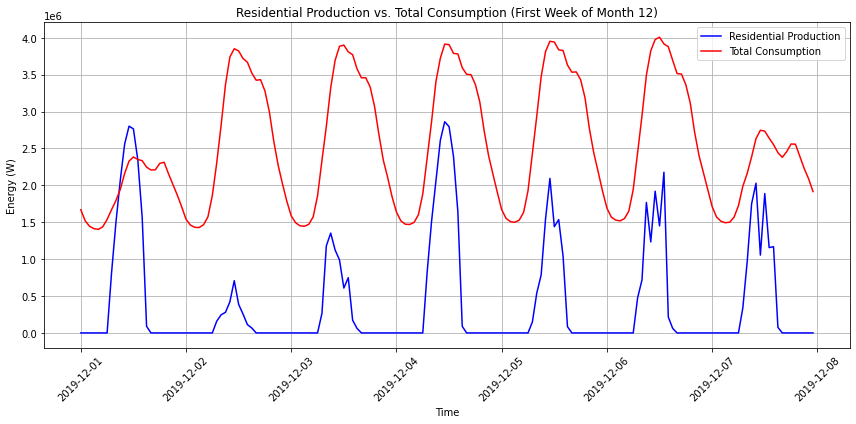

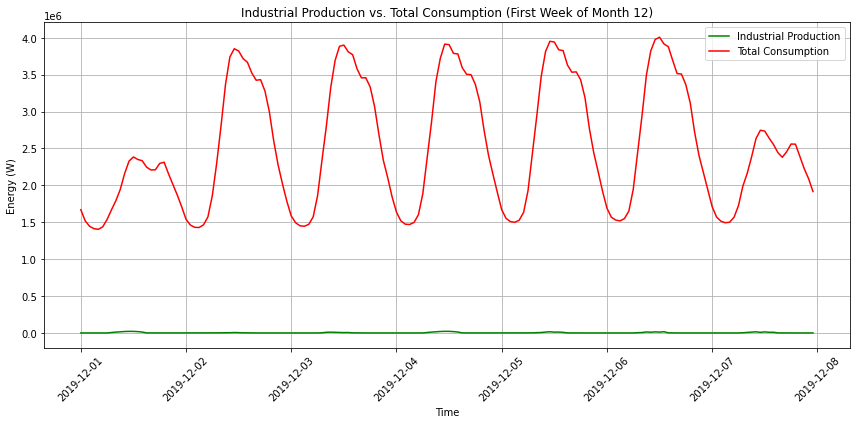

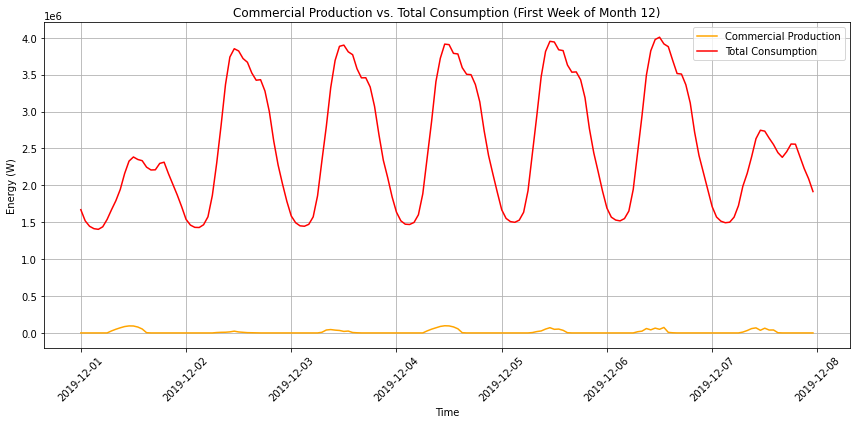

Results saved to C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-11_17-35-59_BinaryProduction\Plot\Weekly_Plot\Weekly_Percentage_Results.xlsx and C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-11_17-35-59_BinaryProduction\Plot\Weekly_Plot\Weekly_Percentage_Results.csv


In [52]:
# Initialize a dictionary to store the results
weekly_results = {
    'Month': [],
    'F1_Percentage': [],
    'F2_Percentage': [],
    'F3_Percentage': [],
    '10am_to_4pm_Percentage': []
}

# Ensure plot directories exist
os.makedirs(weekly_plot_dir, exist_ok=True)

# Loop through each month to calculate percentages for each period and plot the first week of each month
for month in range(1, 13):
    start_date = f'2019-{month:02d}-01'
    end_date = f'2019-{month:02d}-07'

    # Filter data for the first week of the month
    week_data = DF_Consumption.loc[start_date:end_date]

    # Calculate production for each user type
    week_production_residential = [
        sum(RP_values[user] * Residential_user_production_df.loc[date, user] for user in DF_m2_Residential['full_id']) 
        for date in week_data.index
    ]
    week_production_industrial = [
        sum(IP_values[user] * Industrial_user_production_df.loc[date, user] for user in DF_m2_Industrial['full_id']) 
        for date in week_data.index
    ]
    week_production_commercial = [
        sum(CP_values[user] * Commercial_user_production_df.loc[date, user] for user in DF_m2_Commercial['full_id']) 
        for date in week_data.index
    ]
    week_production_total = [
        week_production_residential[i] + week_production_industrial[i] + week_production_commercial[i] for i in range(len(week_data.index))
    ]

    # Total consumption for the week
    week_consumption_total = week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max

    # Convert index to datetime if not already
    week_data.index = pd.to_datetime(week_data.index)

    # Define F1, F2, F3 periods and 10am to 4pm
    F1_mask = (week_data.index.weekday < 5) & (week_data.index.hour >= 8) & (week_data.index.hour < 19)
    F2_mask = ((week_data.index.weekday < 5) & ((week_data.index.hour >= 7) & (week_data.index.hour < 8) | (week_data.index.hour >= 19) & (week_data.index.hour < 23))) | \
              ((week_data.index.weekday == 5) & (week_data.index.hour >= 7) & (week_data.index.hour < 23))
    F3_mask = ((week_data.index.weekday < 6) & (week_data.index.hour >= 23)) | (week_data.index.hour < 7) | (week_data.index.weekday == 6)
    time_10am_4pm_mask = (week_data.index.hour >= 10) & (week_data.index.hour < 16)

    # Calculate total production and consumption for each period
    total_production_F1 = sum([week_production_total[i] for i in range(len(week_data)) if F1_mask[i]])
    total_consumption_F1 = sum([week_consumption_total[i] for i in range(len(week_data)) if F1_mask[i]])
    F1_percentage = (total_production_F1 / total_consumption_F1) * 100 if total_consumption_F1 > 0 else 0

    total_production_F2 = sum([week_production_total[i] for i in range(len(week_data)) if F2_mask[i]])
    total_consumption_F2 = sum([week_consumption_total[i] for i in range(len(week_data)) if F2_mask[i]])
    F2_percentage = (total_production_F2 / total_consumption_F2) * 100 if total_consumption_F2 > 0 else 0

    total_production_F3 = sum([week_production_total[i] for i in range(len(week_data)) if F3_mask[i]])
    total_consumption_F3 = sum([week_consumption_total[i] for i in range(len(week_data)) if F3_mask[i]])
    F3_percentage = (total_production_F3 / total_consumption_F3) * 100 if total_consumption_F3 > 0 else 0

    total_production_10am_4pm = sum([week_production_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    total_consumption_10am_4pm = sum([week_consumption_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    percentage_10am_4pm = (total_production_10am_4pm / total_consumption_10am_4pm) * 100 if total_consumption_10am_4pm > 0 else 0

    # Append results for each month
    weekly_results['Month'].append(month)
    weekly_results['F1_Percentage'].append(F1_percentage)
    weekly_results['F2_Percentage'].append(F2_percentage)
    weekly_results['F3_Percentage'].append(F3_percentage)
    weekly_results['10am_to_4pm_Percentage'].append(percentage_10am_4pm)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(week_data.index, week_production_total, label='Total Production', color='blue')
    plt.plot(week_data.index, week_consumption_total, label='Total Consumption', color='red')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title(f'Total Production vs. Total Consumption (First Week of Month {month:02d})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(weekly_plot_dir, f'Total_Production_vs_Total_Consumption_Week_{month:02d}.png'))
    plt.show()

    # Plot for each user type
    for label, production, color in zip(
        ['Residential', 'Industrial', 'Commercial'], 
        [week_production_residential, week_production_industrial, week_production_commercial], 
        ['blue', 'green', 'orange']
    ):
        plt.figure(figsize=(12, 6))
        plt.plot(week_data.index, production, label=f'{label} Production', color=color)
        plt.plot(week_data.index, week_consumption_total, label='Total Consumption', color='red')
        plt.xlabel('Time')
        plt.ylabel('Energy (W)')
        plt.title(f'{label} Production vs. Total Consumption (First Week of Month {month:02d})')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(weekly_plot_dir, f'{label}_Production_vs_Total_Consumption_Week_{month:02d}.png'))
        plt.show()

# Convert results to DataFrame
weekly_results_df = pd.DataFrame(weekly_results)

# Save the results to Excel and CSV
output_file_path_excel = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.xlsx')
output_file_path_csv = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.csv')

weekly_results_df.to_excel(output_file_path_excel, index=False)
weekly_results_df.to_csv(output_file_path_csv, index=False)

print(f'Results saved to {output_file_path_excel} and {output_file_path_csv}')


### Daily Plots

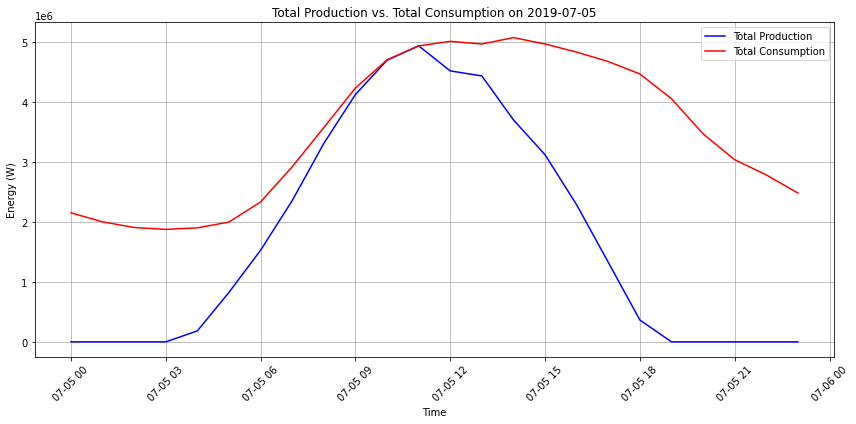

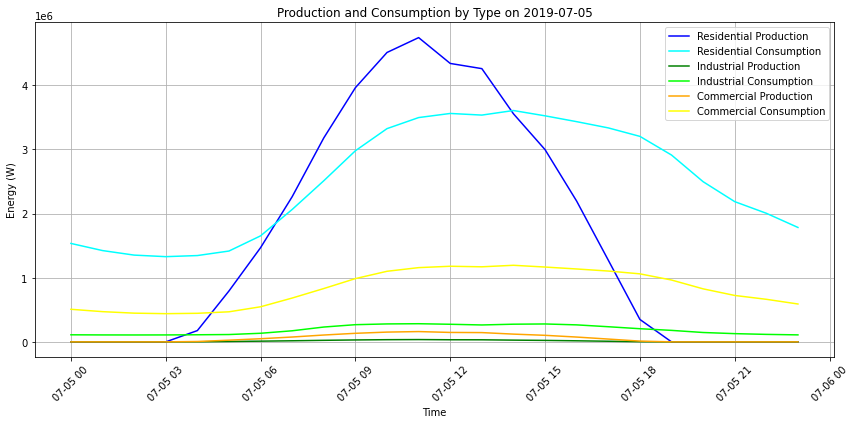

In [53]:
# Define the specific day for the detailed plot
specific_day_str = '2019-07-05'

# Filter data for the specific day
specific_day_data_residential = Residential_user_production_df.loc[Residential_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]
specific_day_data_industrial = Industrial_user_production_df.loc[Industrial_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]
specific_day_data_commercial = Commercial_user_production_df.loc[Commercial_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]

# Filter consumption data for the specific day
specific_day_consumption = DF_Consumption.loc[DF_Consumption.index.strftime('%Y-%m-%d') == specific_day_str]

# Calculate production data for the specific day
specific_day_production_residential = specific_day_data_residential.apply(
    lambda col: sum(RP_values[user] * col[user] for user in DF_m2_Residential['full_id']), axis=1)
specific_day_production_industrial = specific_day_data_industrial.apply(
    lambda col: sum(IP_values[user] * col[user] for user in DF_m2_Industrial['full_id']), axis=1)
specific_day_production_commercial = specific_day_data_commercial.apply(
    lambda col: sum(CP_values[user] * col[user] for user in DF_m2_Commercial['full_id']), axis=1)

# Calculate total production for the specific day
total_specific_day_production = specific_day_production_residential + specific_day_production_industrial + specific_day_production_commercial

# Calculate total consumption for the specific day
total_specific_day_consumption = (
    specific_day_consumption['Residential'] * Area_Res_Max + 
    specific_day_consumption['Industrial'] * Area_Ind_Max + 
    specific_day_consumption['Commercial'] * Area_Com_Max
)

# Plot total production vs total consumption for the specific day
plt.figure(figsize=(12, 6))
plt.plot(specific_day_data_residential.index, total_specific_day_production, label='Total Production', color='blue')
plt.plot(specific_day_consumption.index, total_specific_day_consumption, label='Total Consumption', color='red')
plt.xlabel('Time')
plt.ylabel('Energy (W)')
plt.title(f'Total Production vs. Total Consumption on {specific_day_str}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(yearly_plot_dir, f'Total_Production_vs_Consumption_{specific_day_str}.png'))
plt.show()

# Plot production vs consumption for each type for the specific day
plt.figure(figsize=(12, 6))
plt.plot(specific_day_data_residential.index, specific_day_production_residential, label='Residential Production', color='blue')
plt.plot(specific_day_consumption.index, specific_day_consumption['Residential'] * Area_Res_Max, label='Residential Consumption', color='cyan')
plt.plot(specific_day_data_industrial.index, specific_day_production_industrial, label='Industrial Production', color='green')
plt.plot(specific_day_consumption.index, specific_day_consumption['Industrial'] * Area_Ind_Max, label='Industrial Consumption', color='lime')
plt.plot(specific_day_data_commercial.index, specific_day_production_commercial, label='Commercial Production', color='orange')
plt.plot(specific_day_consumption.index, specific_day_consumption['Commercial'] * Area_Com_Max, label='Commercial Consumption', color='yellow')
plt.xlabel('Time')
plt.ylabel('Energy (W)')
plt.title(f'Production and Consumption by Type on {specific_day_str}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(yearly_plot_dir, f'Production_vs_Consumption_By_Type_{specific_day_str}.png'))
plt.show()



Peak Analysis for Total Production and Consumption:
Peak Production: 8148416.46 W at 2019-06-30 11:00:00
Peak Consumption: 5550884.00 W at 2019-06-28 12:00:00


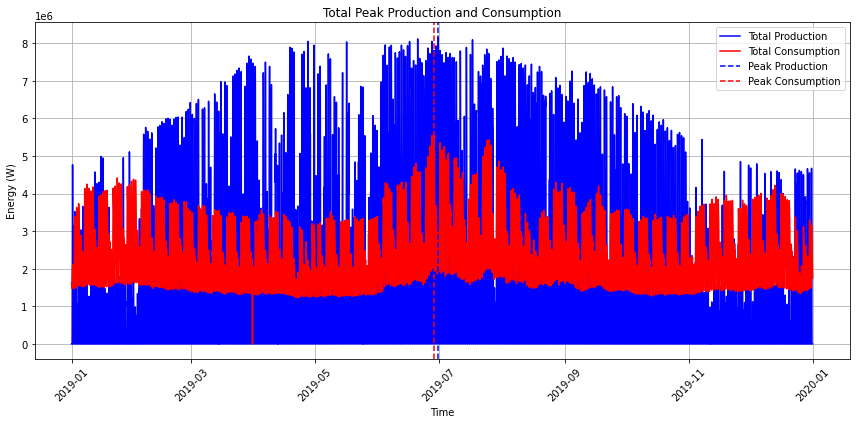

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


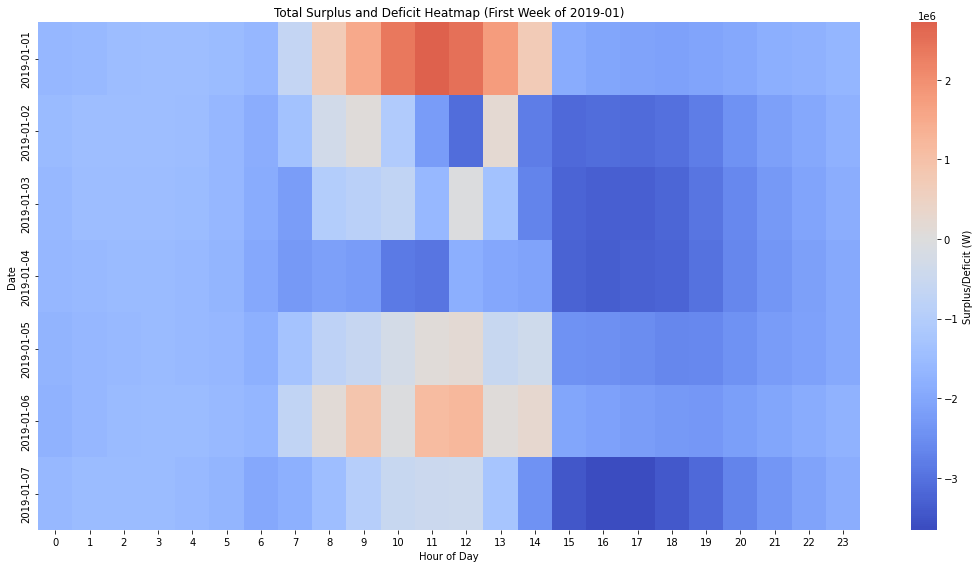

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


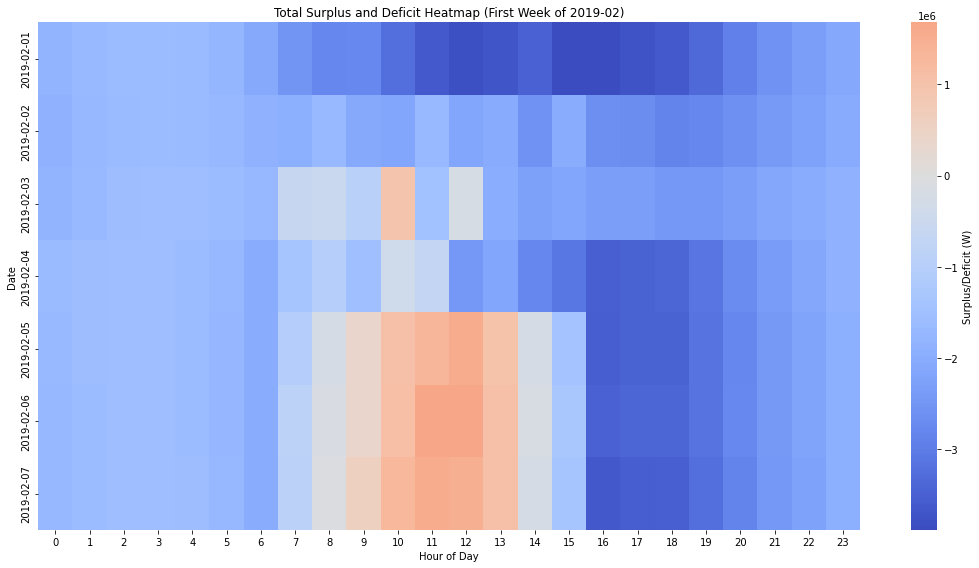

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


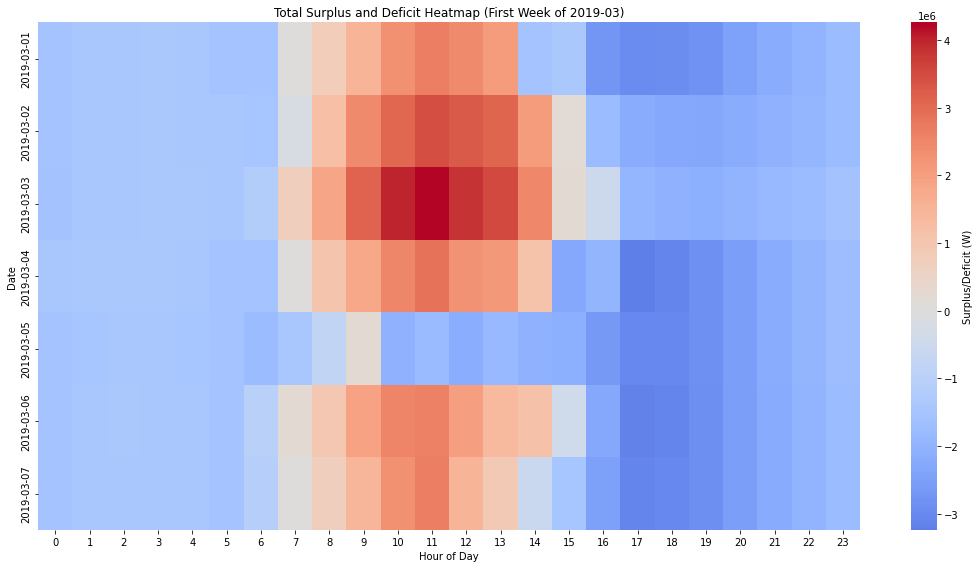

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


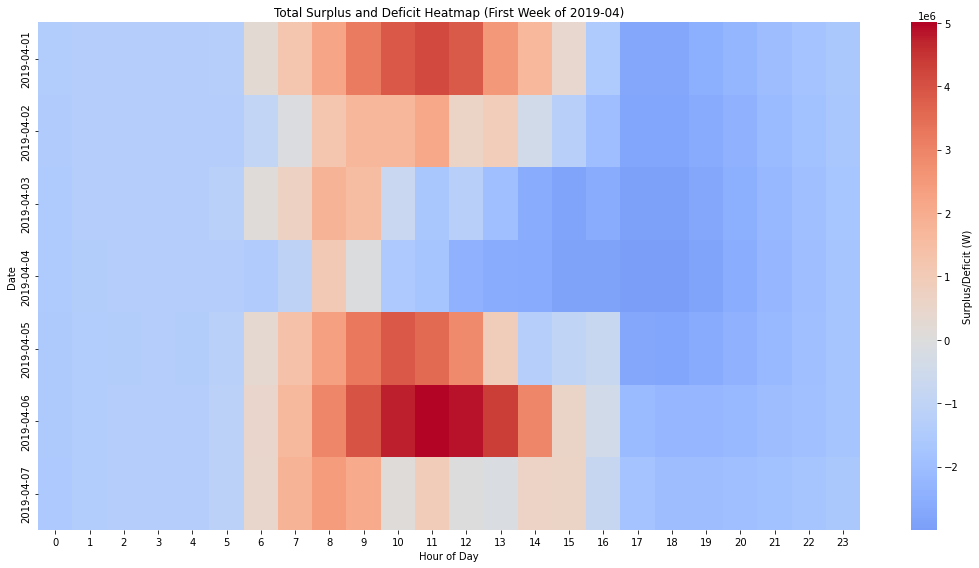

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


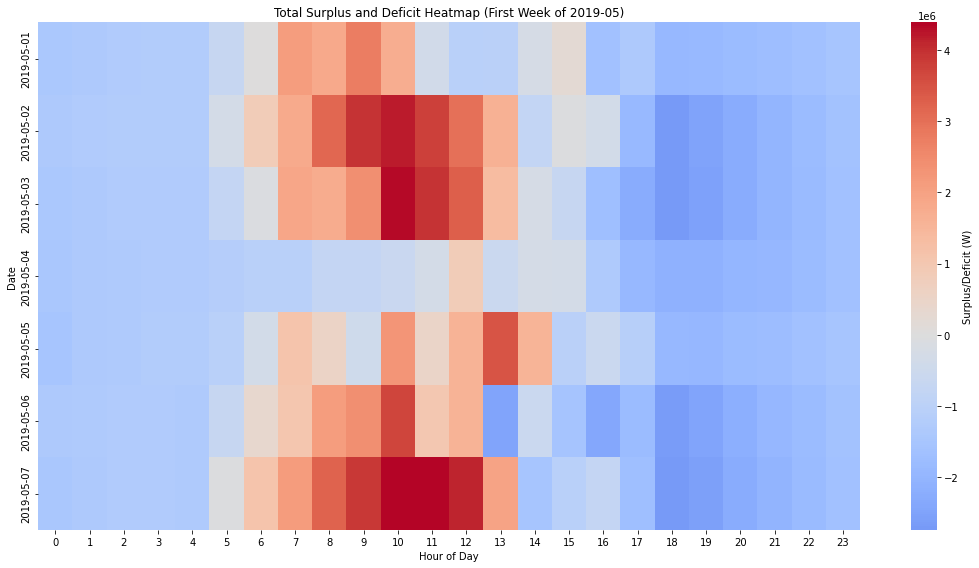

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


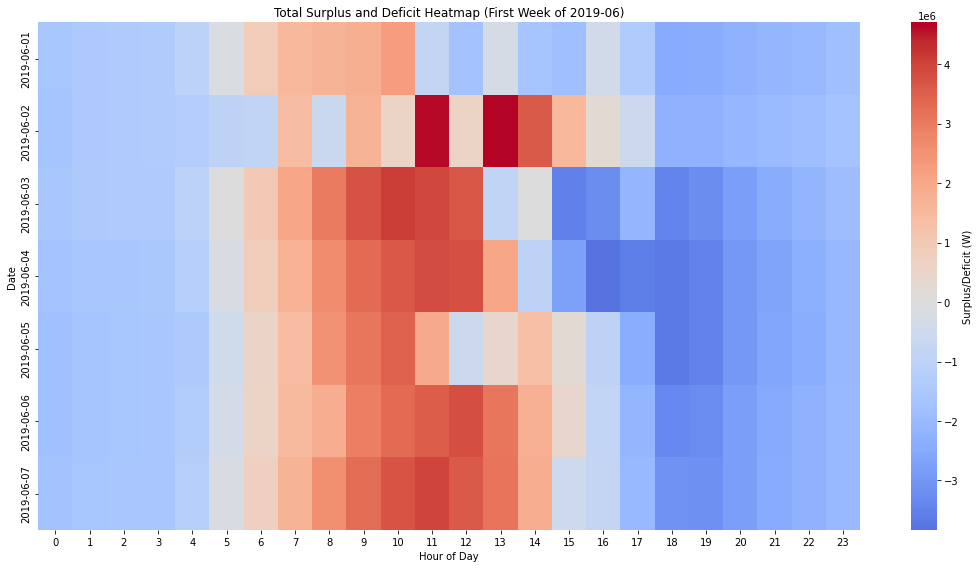

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


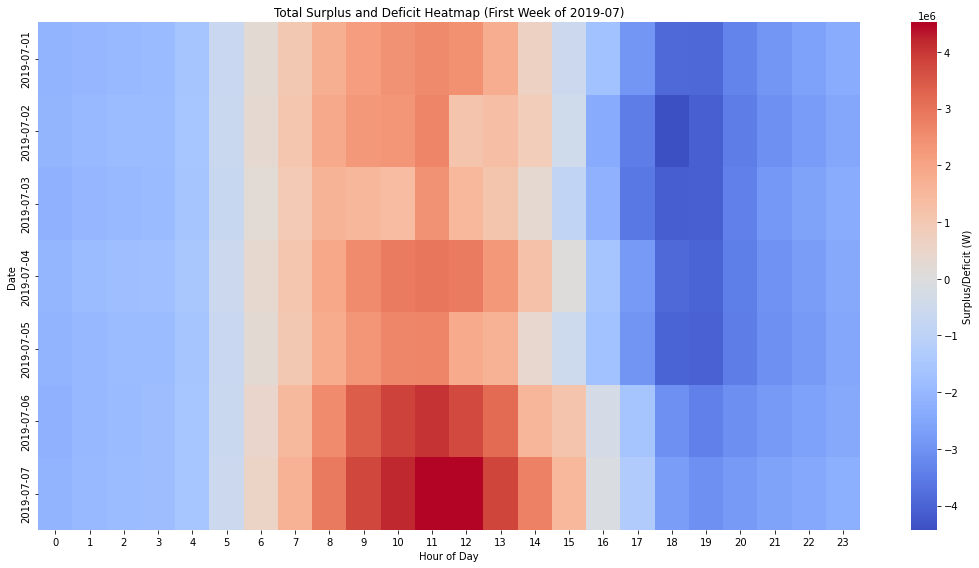

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


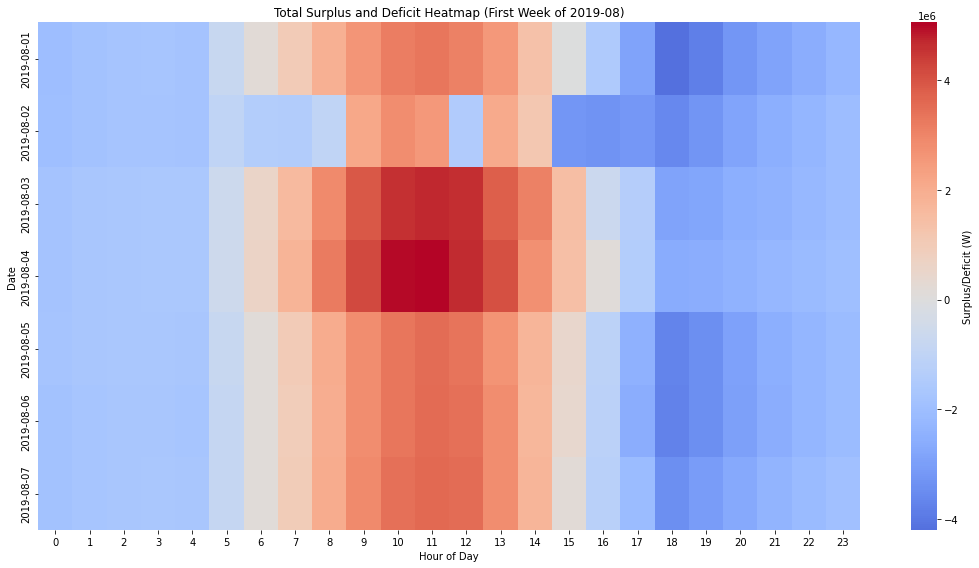

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


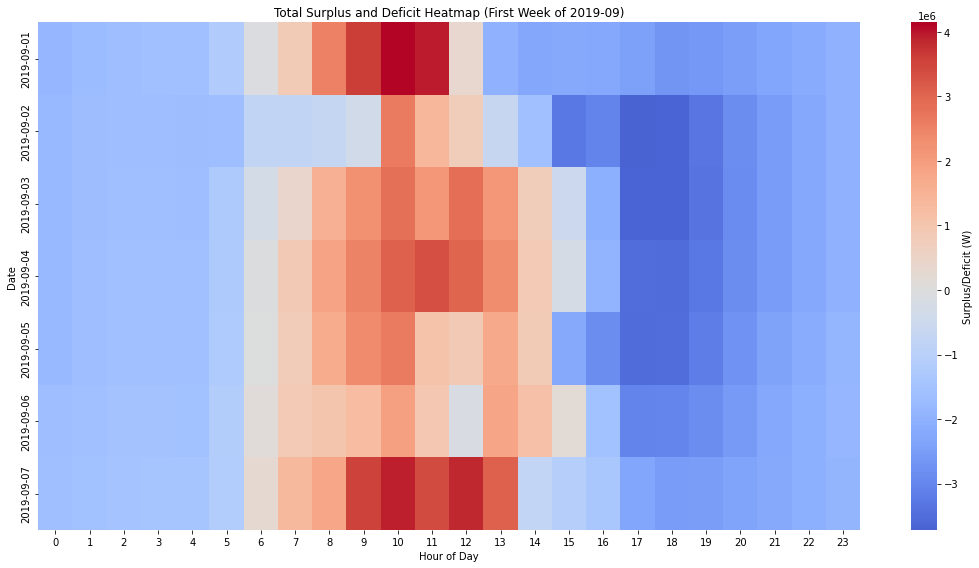

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


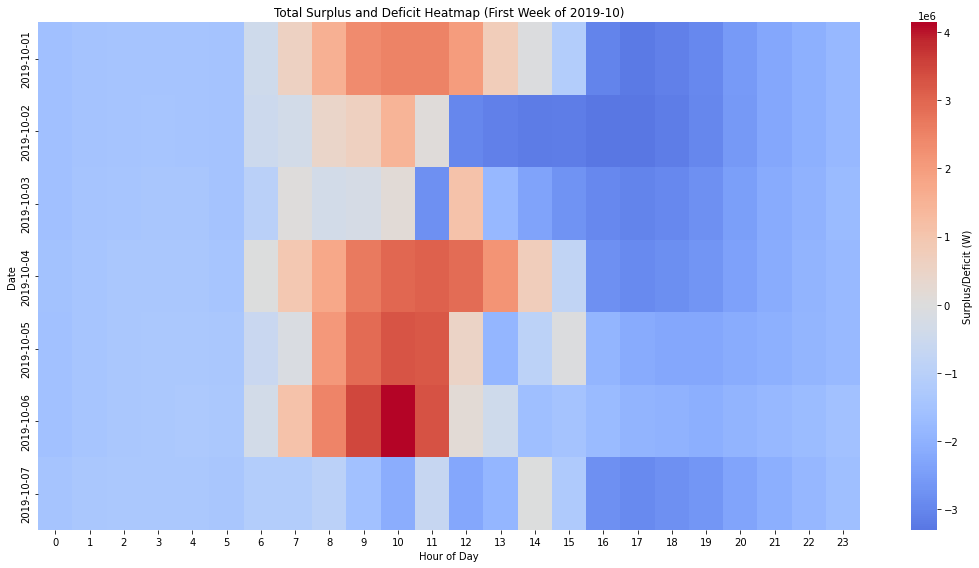

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


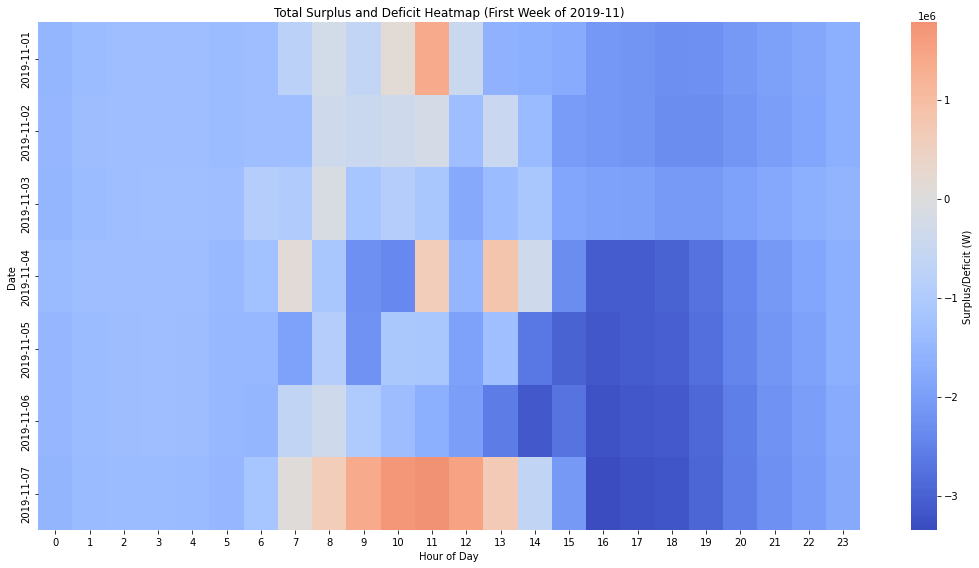

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/832888292.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


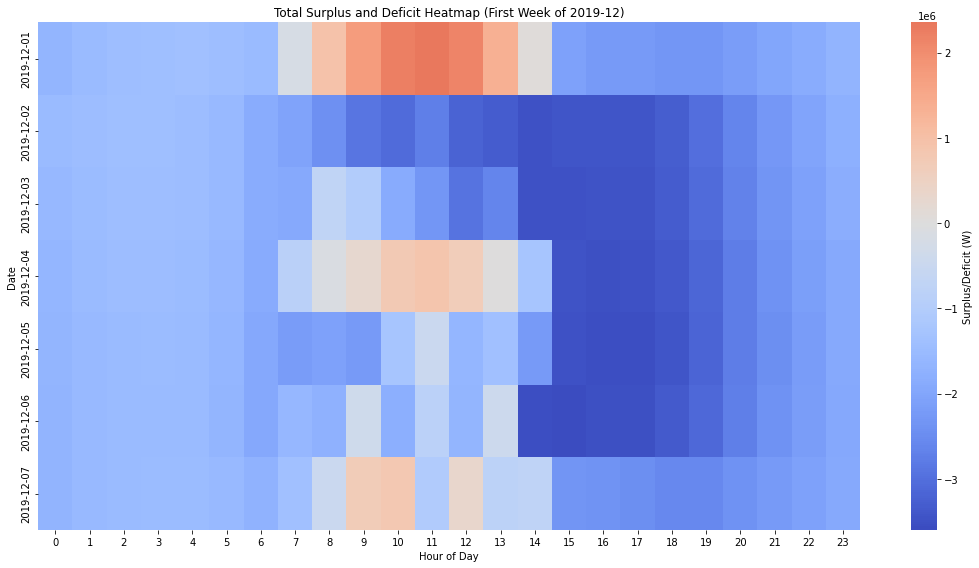

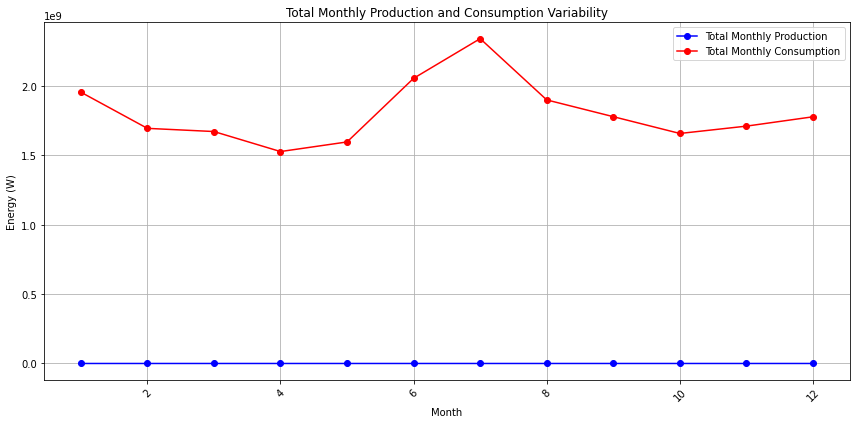

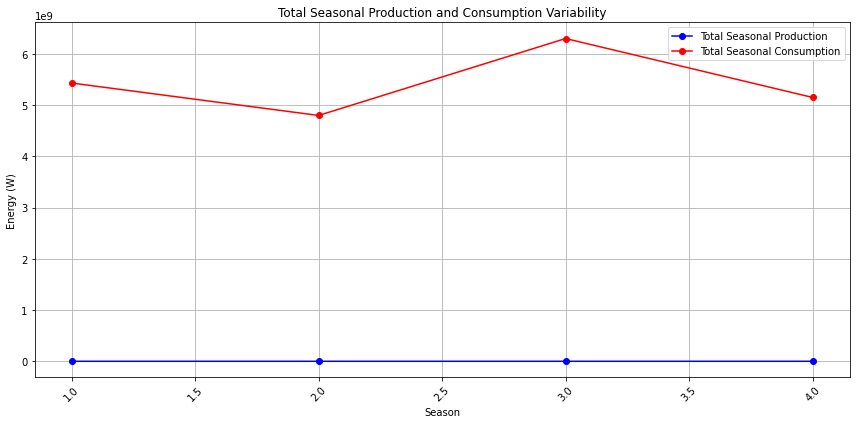

In [54]:
# 1. Peak Production and Consumption Analysis
def peak_analysis(production_dfs, consumption_df, area_maxes, category_names):
    # Combine production DataFrames for total production
    total_production = sum(df.sum(axis=1) for df in production_dfs)
    total_consumption = sum(consumption_df[category] * area_max for category, area_max in zip(category_names, area_maxes))
    
    # Find peak production and consumption hours
    peak_production_hour = total_production.idxmax()
    peak_production_value = total_production.max()
    
    peak_consumption_hour = total_consumption.idxmax()
    peak_consumption_value = total_consumption.max()
    
    print(f"\nPeak Analysis for Total Production and Consumption:")
    print(f"Peak Production: {peak_production_value:.2f} W at {peak_production_hour}")
    print(f"Peak Consumption: {peak_consumption_value:.2f} W at {peak_consumption_hour}")
    
    # Plot peak production and consumption
    plt.figure(figsize=(12, 6))
    plt.plot(total_production.index, total_production, label='Total Production', color='blue')
    plt.plot(total_consumption.index, total_consumption, label='Total Consumption', color='red')
    plt.axvline(peak_production_hour, color='blue', linestyle='--', label='Peak Production')
    plt.axvline(peak_consumption_hour, color='red', linestyle='--', label='Peak Consumption')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title('Total Peak Production and Consumption')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Peak_Production_Consumption.png'))
    plt.show()

# Run peak analysis for total production and consumption
peak_analysis(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)

# 2. Energy Surplus and Deficit Analysis with Heatmap for Each First Week of the Month (Total)
def surplus_deficit_heatmap_first_week(production_dfs, consumption_df, area_maxes, category_names):
    for month in range(1, 13):
        start_date = f'2019-{month:02d}-01'
        end_date = f'2019-{month:02d}-07'

        # Filter data for the first week of the month
        week_production_dfs = [df.loc[start_date:end_date] for df in production_dfs]
        week_consumption_df = consumption_df.loc[start_date:end_date]

        # Calculate total production and consumption for each hour
        total_production = sum(df.sum(axis=1) for df in week_production_dfs)
        total_consumption = sum(week_consumption_df[category] * area_max for category, area_max in zip(category_names, area_maxes))

        # Calculate surplus and deficit
        surplus_deficit = total_production - total_consumption

        # Prepare data for heatmap by pivoting the daily data into a matrix of days vs. hours
        daily_surplus_deficit = surplus_deficit.reset_index()
        daily_surplus_deficit.rename(columns={daily_surplus_deficit.columns[0]: 'Datetime'}, inplace=True)
        daily_surplus_deficit['Date'] = daily_surplus_deficit['Datetime'].dt.date
        daily_surplus_deficit['Hour'] = daily_surplus_deficit['Datetime'].dt.hour
        heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)

        # Plot the heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(heatmap_data, cmap='coolwarm', center=0, cbar_kws={'label': 'Surplus/Deficit (W)'})
        plt.title(f'Total Surplus and Deficit Heatmap (First Week of {start_date[:7]})')
        plt.xlabel('Hour of Day')
        plt.ylabel('Date')
        plt.tight_layout()
        plt.savefig(os.path.join(weekly_plot_dir, f'Total_Surplus_Deficit_Heatmap_Week_{month:02d}.png'))
        plt.show()

# Run surplus and deficit heatmap analysis for total production and consumption
surplus_deficit_heatmap_first_week(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)


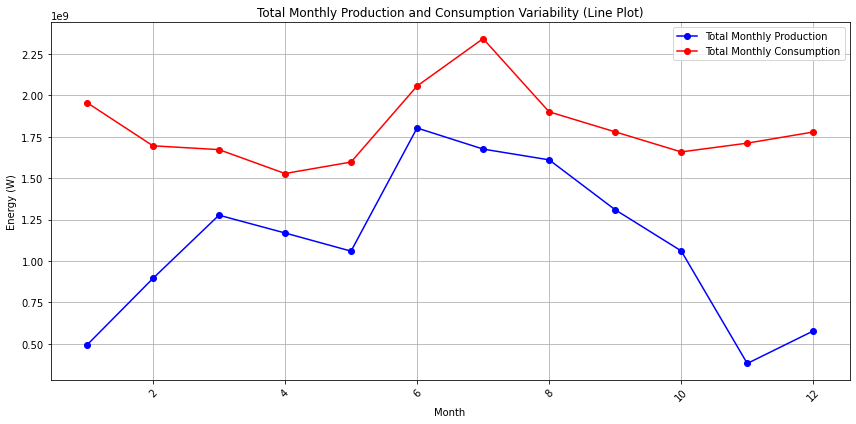

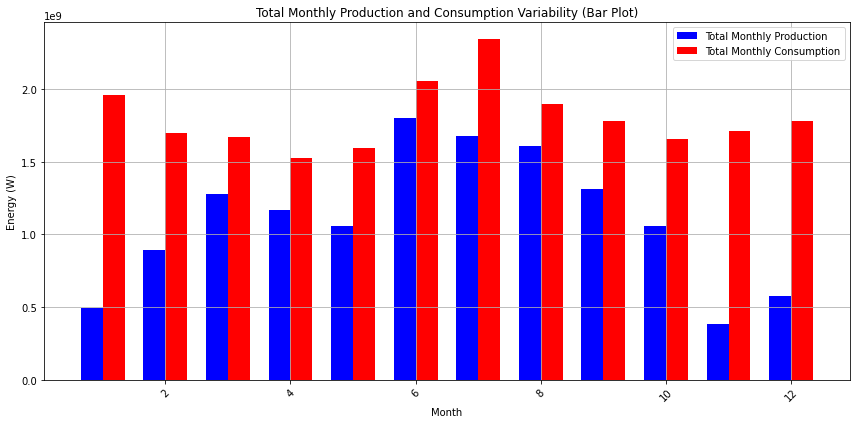

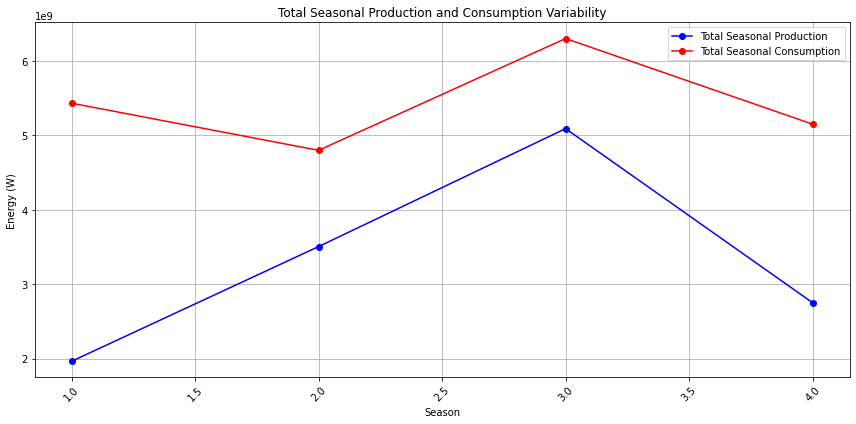

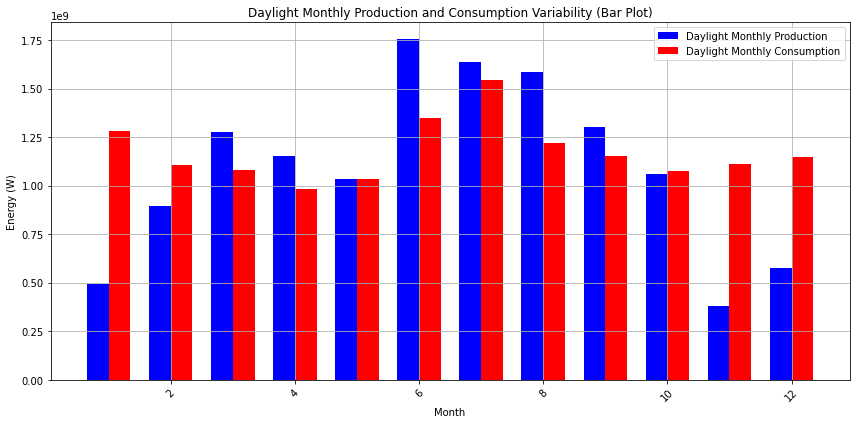

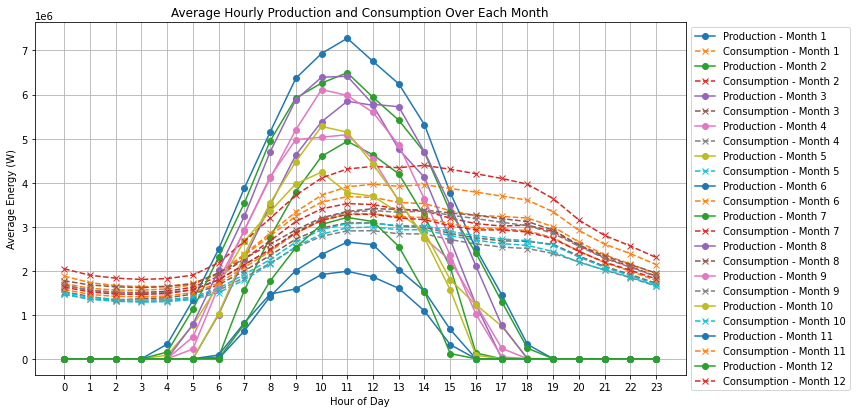

In [61]:
# 4. Seasonal and Monthly Variability Analysis (Total)
def seasonal_monthly_variability(production_dfs, consumption_df, area_maxes, category_names):
    # Ensure all production DataFrames have the same index
    total_production_df = pd.concat(production_dfs, axis=1).sum(axis=1)  # Sum across all production DataFrames
    total_production_df = total_production_df.to_frame(name='Total Production')  # Convert to DataFrame

    # Add 'Month', 'Season', and 'Hour' columns
    total_production_df['Month'] = total_production_df.index.month
    total_production_df['Season'] = total_production_df.index.to_series().dt.month % 12 // 3 + 1
    total_production_df['Hour'] = total_production_df.index.hour

    # Ensure consumption DataFrame is indexed properly
    consumption_df['Month'] = consumption_df.index.month
    consumption_df['Season'] = consumption_df.index.to_series().dt.month % 12 // 3 + 1
    consumption_df['Hour'] = consumption_df.index.hour

    # Calculate monthly total production and consumption
    monthly_production = total_production_df.groupby('Month')['Total Production'].sum()

    # Correct calculation of monthly consumption
    monthly_consumption = consumption_df.groupby('Month').apply(
        lambda x: sum((x[category] * area_max).sum() for category, area_max in zip(category_names, area_maxes))
    )

    # Calculate seasonal total production and consumption
    seasonal_production = total_production_df.groupby('Season')['Total Production'].sum()

    # Correct calculation of seasonal consumption
    seasonal_consumption = consumption_df.groupby('Season').apply(
        lambda x: sum((x[category] * area_max).sum() for category, area_max in zip(category_names, area_maxes))
    )

    # Plot monthly variability line plot
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_production.index, monthly_production, label='Total Monthly Production', marker='o', color='blue')
    plt.plot(monthly_consumption.index, monthly_consumption, label='Total Monthly Consumption', marker='o', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title('Total Monthly Production and Consumption Variability (Line Plot)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Monthly_Variability_Line.png'))
    plt.show()
    
    # Plot monthly variability as bar plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    plt.bar(monthly_production.index - bar_width / 2, monthly_production, width=bar_width, label='Total Monthly Production', color='blue')
    plt.bar(monthly_consumption.index + bar_width / 2, monthly_consumption, width=bar_width, label='Total Monthly Consumption', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title('Total Monthly Production and Consumption Variability (Bar Plot)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Monthly_Variability_Bar.png'))
    plt.show()

    # Plot seasonal variability line plot
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_production.index, seasonal_production, label='Total Seasonal Production', marker='o', color='blue')
    plt.plot(seasonal_consumption.index, seasonal_consumption, label='Total Seasonal Consumption', marker='o', color='red')
    plt.xlabel('Season')
    plt.ylabel('Energy (W)')
    plt.title('Total Seasonal Production and Consumption Variability')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Seasonal_Variability.png'))
    plt.show()

    # Filter for daylight hours (e.g., 6:00 to 18:00) where production is typically non-zero
    daylight_hours = total_production_df[(total_production_df['Hour'] >= 6) & (total_production_df['Hour'] <= 18)]
    daylight_production = daylight_hours.groupby('Month')['Total Production'].sum()

    daylight_consumption = consumption_df[(consumption_df['Hour'] >= 6) & (consumption_df['Hour'] <= 18)].groupby('Month').apply(
        lambda x: sum((x[category] * area_max).sum() for category, area_max in zip(category_names, area_maxes))
    )

    # Plot daylight variability as bar plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    plt.bar(daylight_production.index - bar_width / 2, daylight_production, width=bar_width, label='Daylight Monthly Production', color='blue')
    plt.bar(daylight_consumption.index + bar_width / 2, daylight_consumption, width=bar_width, label='Daylight Monthly Consumption', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title('Daylight Monthly Production and Consumption Variability (Bar Plot)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Daylight_Monthly_Variability_Bar.png'))
    plt.show()

    # Calculate average hourly production and consumption for each month
    avg_hourly_production = total_production_df.groupby(['Month', 'Hour'])['Total Production'].mean().reset_index()
    avg_hourly_consumption = consumption_df.groupby(['Month', 'Hour']).apply(
        lambda x: sum((x[category] * area_max).mean() for category, area_max in zip(category_names, area_maxes))
    ).reset_index(name='Total Consumption')

    # Plot average hourly production and consumption for each month
    plt.figure(figsize=(12, 6))
    for month in range(1, 13):
        plt.plot(avg_hourly_production[avg_hourly_production['Month'] == month]['Hour'],
                 avg_hourly_production[avg_hourly_production['Month'] == month]['Total Production'],
                 label=f'Production - Month {month}', linestyle='-', marker='o')
        plt.plot(avg_hourly_consumption[avg_hourly_consumption['Month'] == month]['Hour'],
                 avg_hourly_consumption[avg_hourly_consumption['Month'] == month]['Total Consumption'],
                 label=f'Consumption - Month {month}', linestyle='--', marker='x')
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy (W)')
    plt.title('Average Hourly Production and Consumption Over Each Month')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Average_Hourly_Production_Consumption_Per_Month.png'))
    plt.show()

# Run seasonal and monthly variability analysis for total production and consumption
seasonal_monthly_variability(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)



Peak Analysis for Residential:
Peak Production: 7824184.91 W at 2019-06-30 11:00:00
Peak Consumption: 3951200.00 W at 2019-06-28 12:00:00


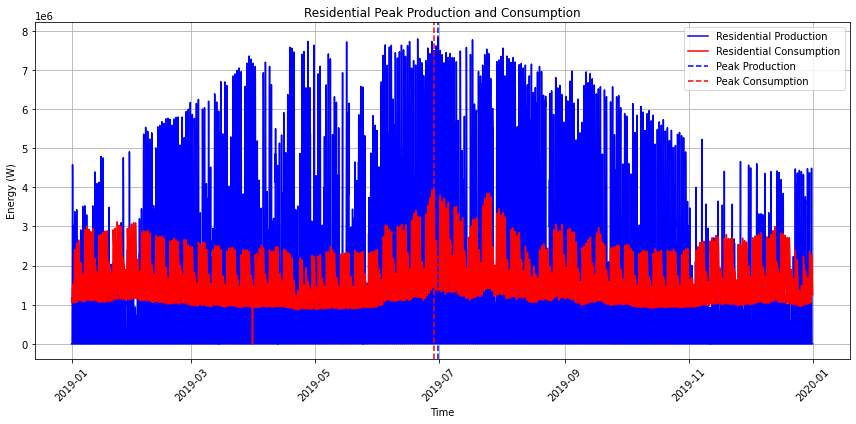


Peak Analysis for Industrial:
Peak Production: 59901.89 W at 2019-06-30 11:00:00
Peak Consumption: 314112.00 W at 2019-06-27 11:00:00


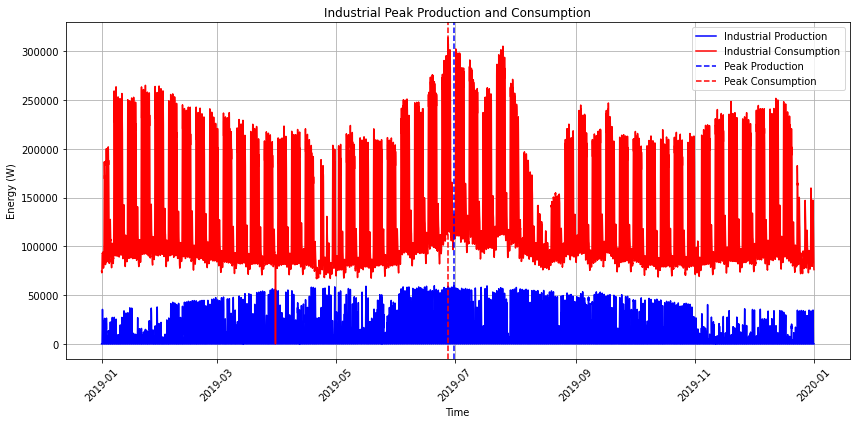


Peak Analysis for Commercial:
Peak Production: 264329.67 W at 2019-06-30 11:00:00
Peak Consumption: 1307980.00 W at 2019-06-28 12:00:00


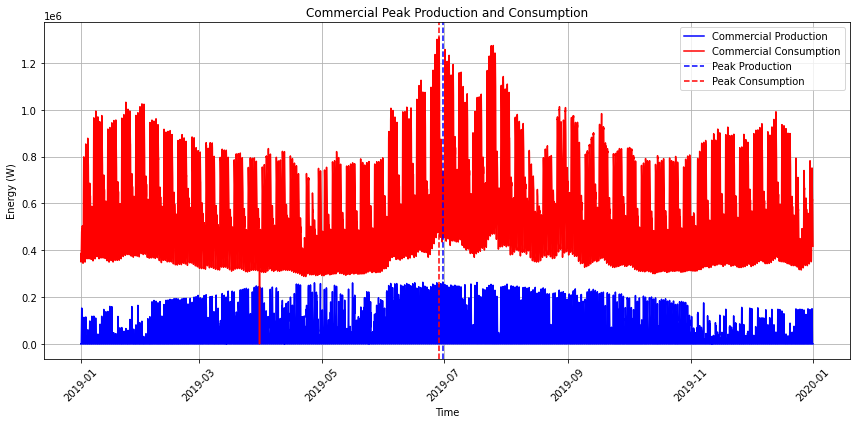

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


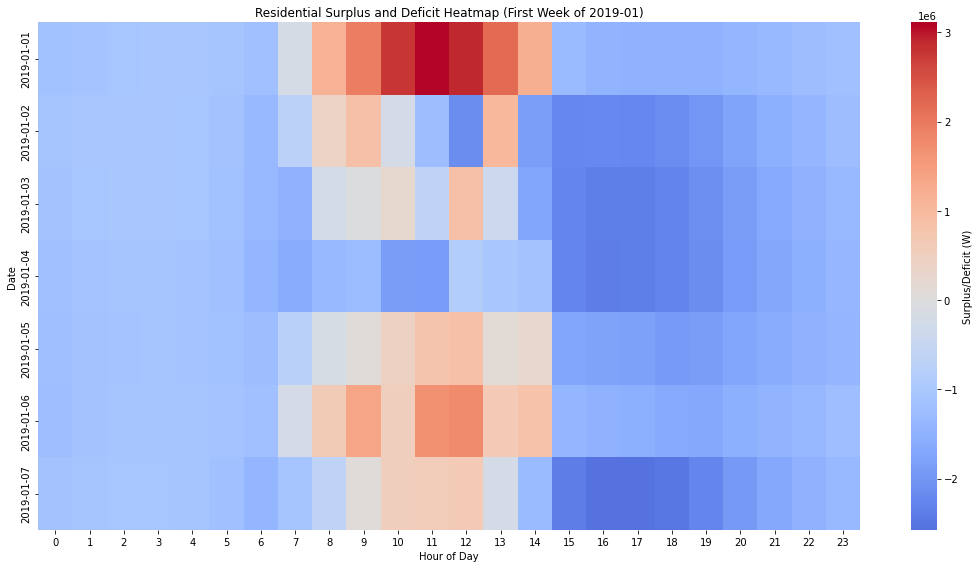

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


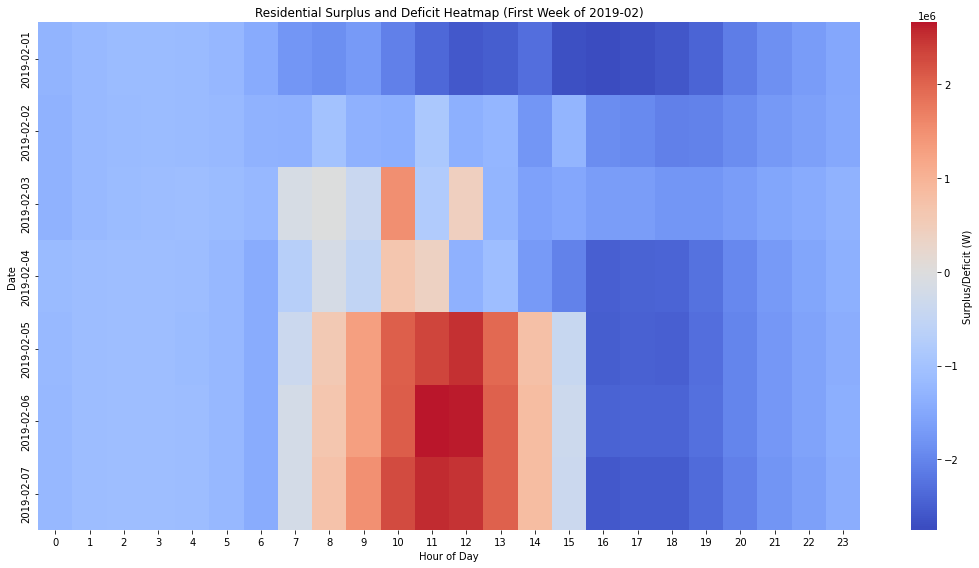

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


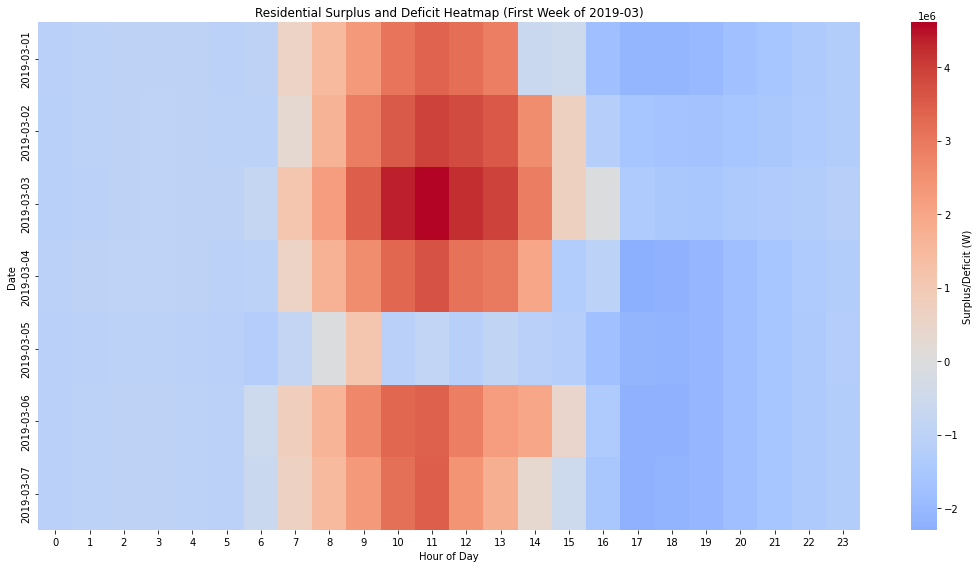

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


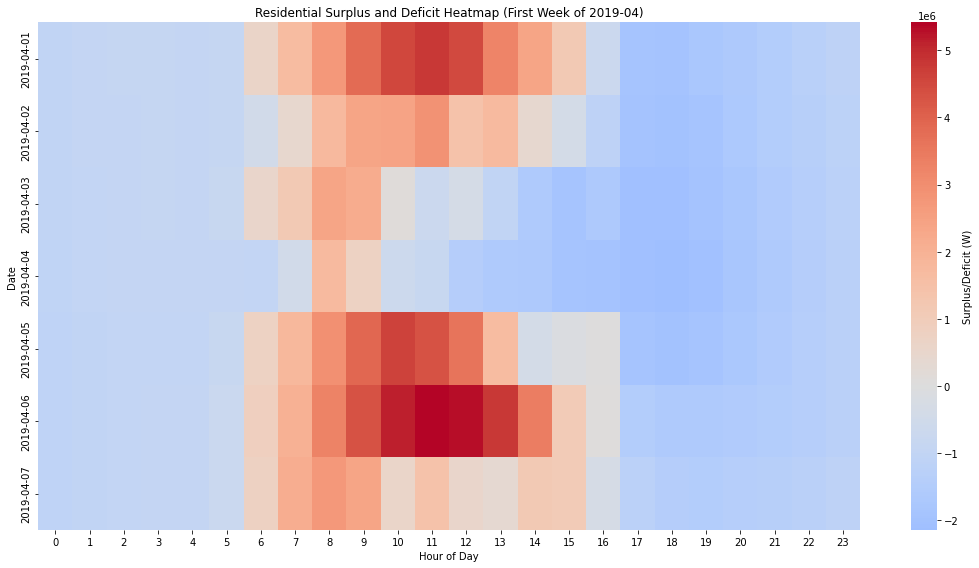

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


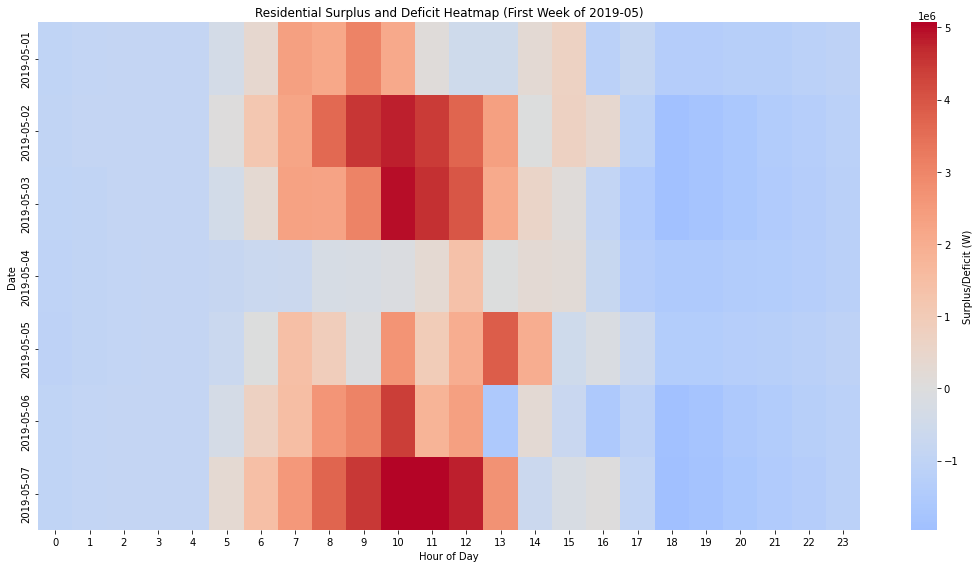

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


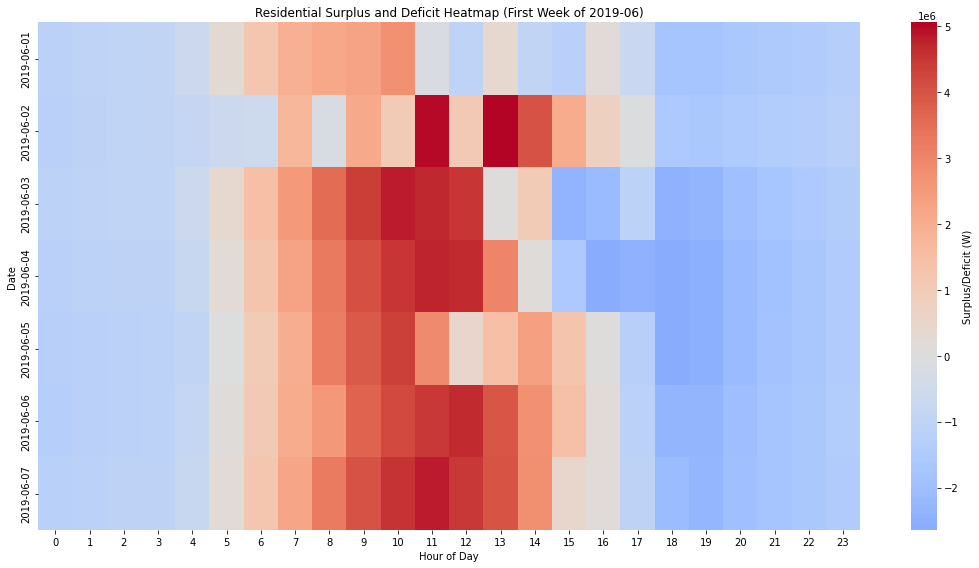

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


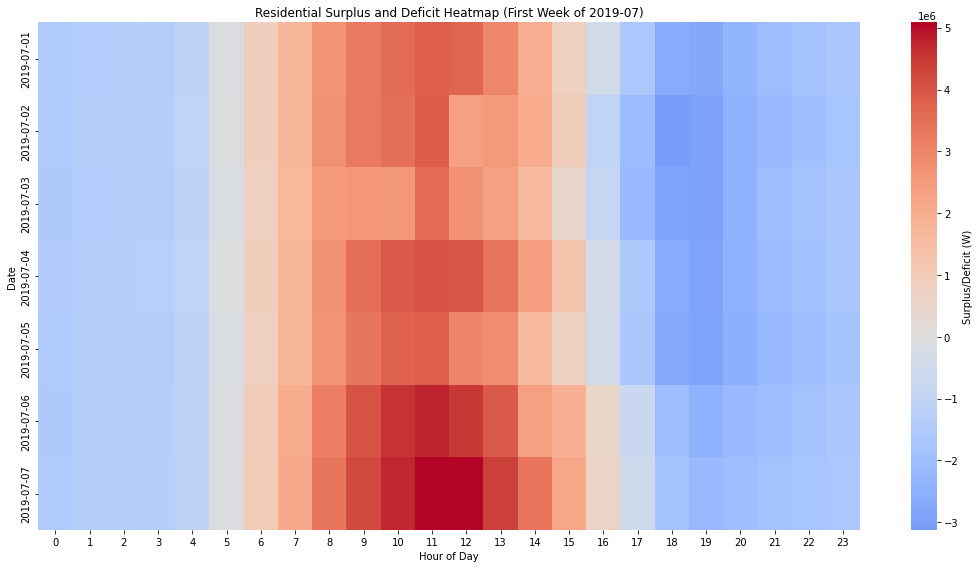

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


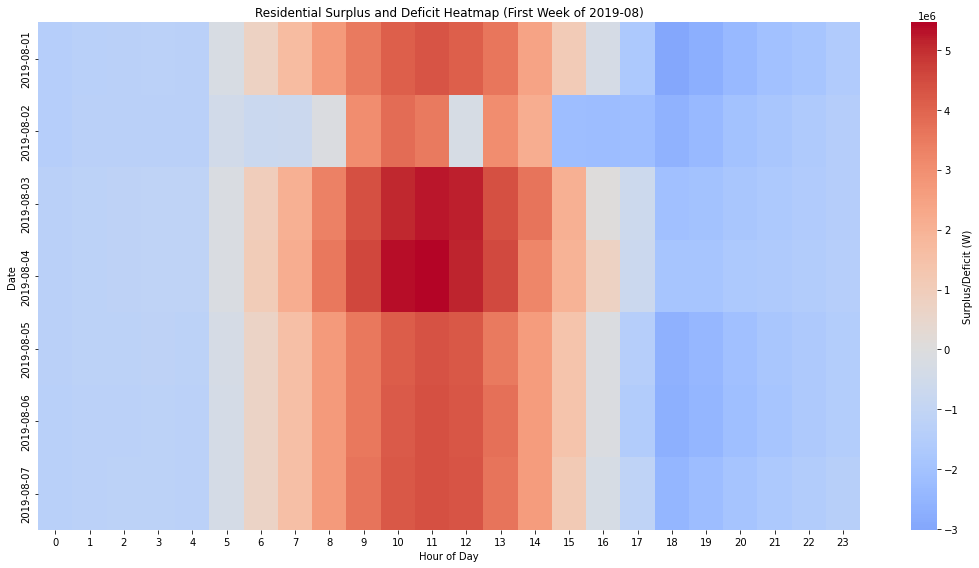

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


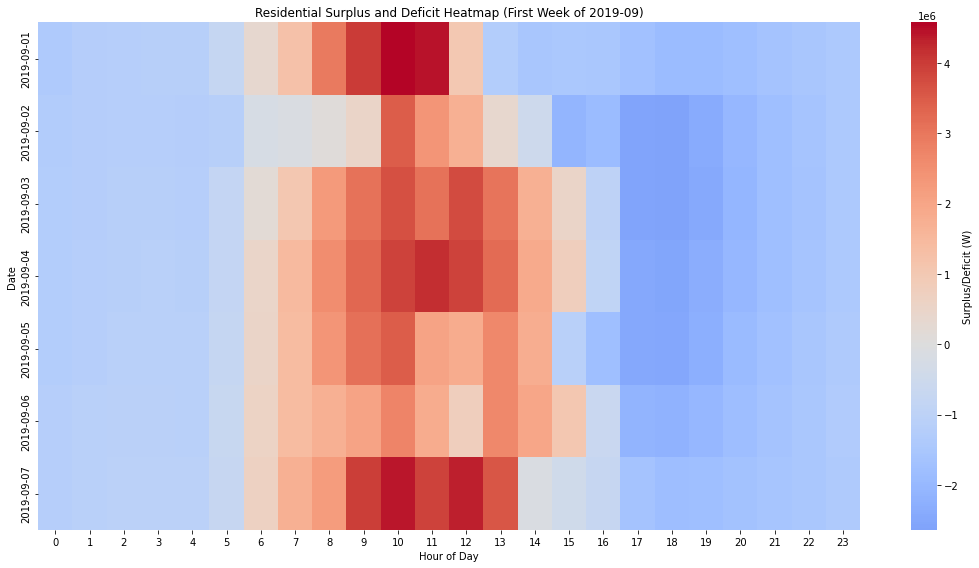

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


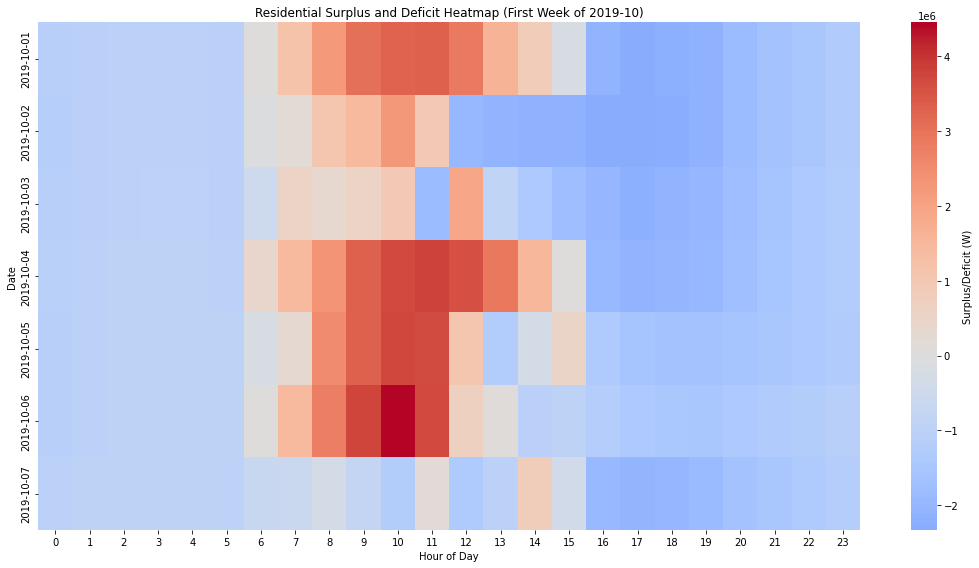

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


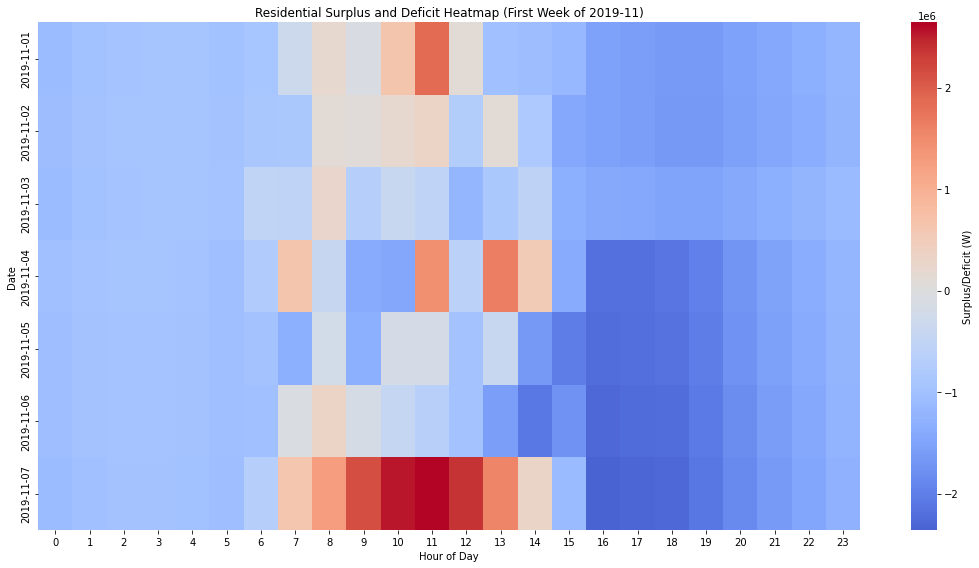

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


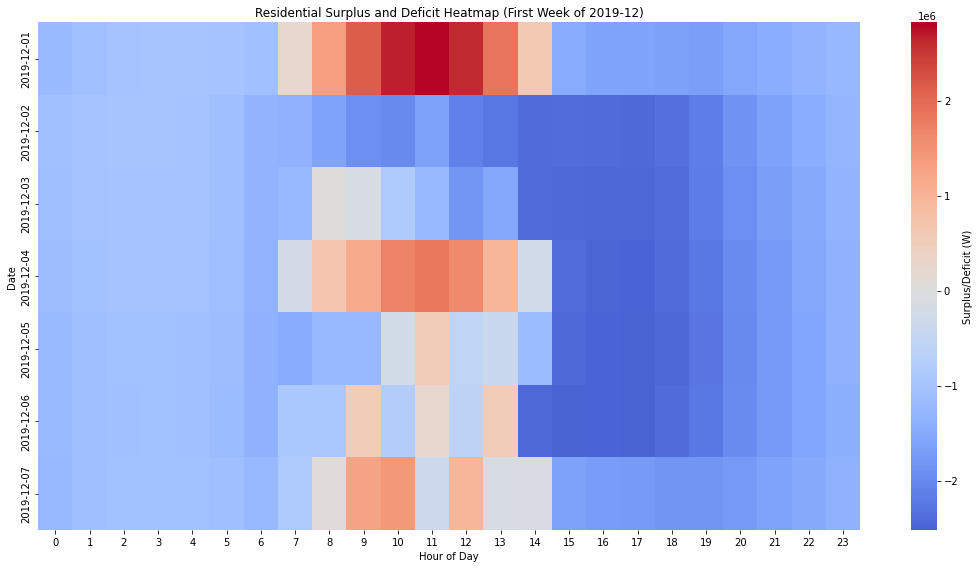

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


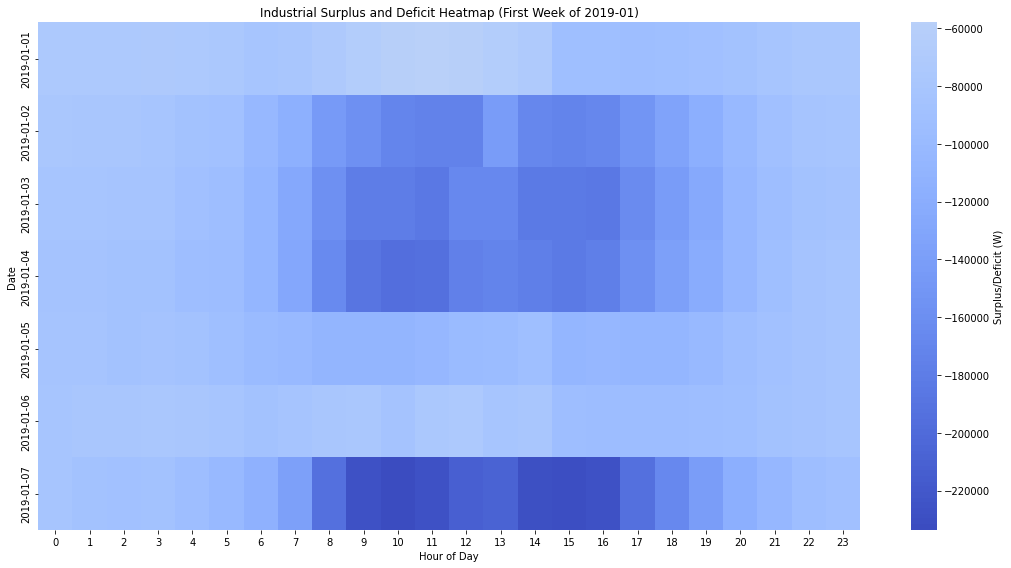

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


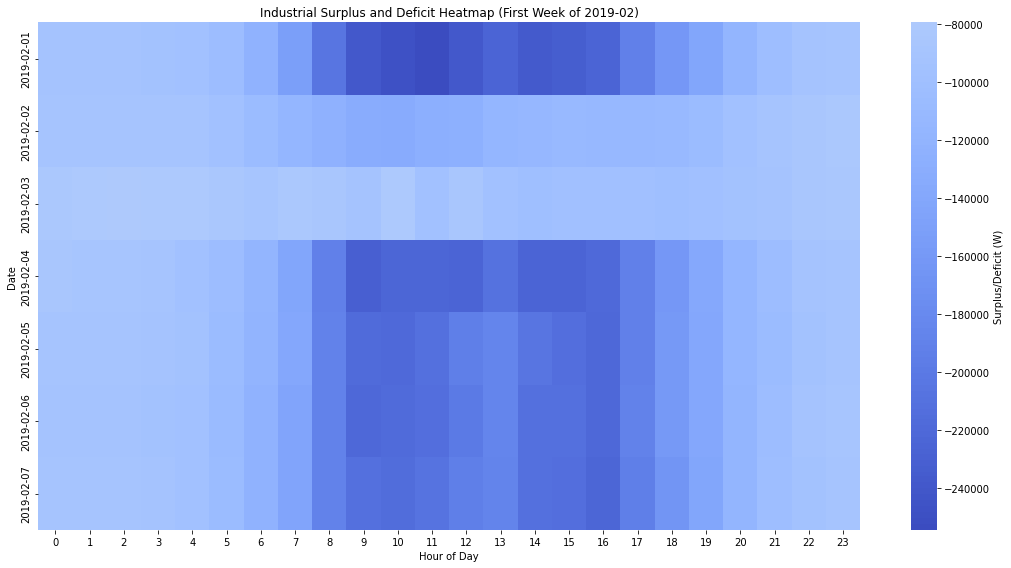

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


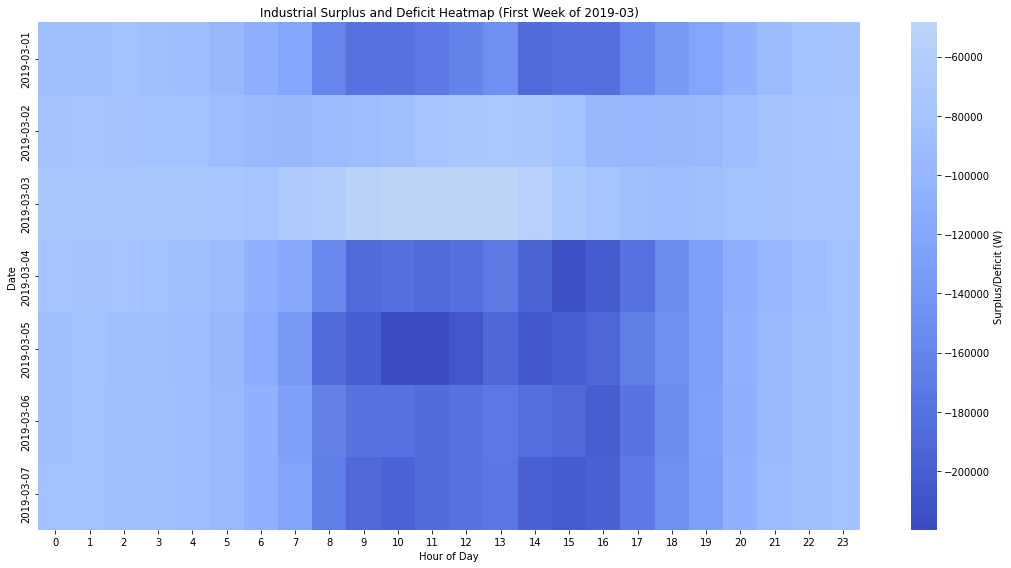

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


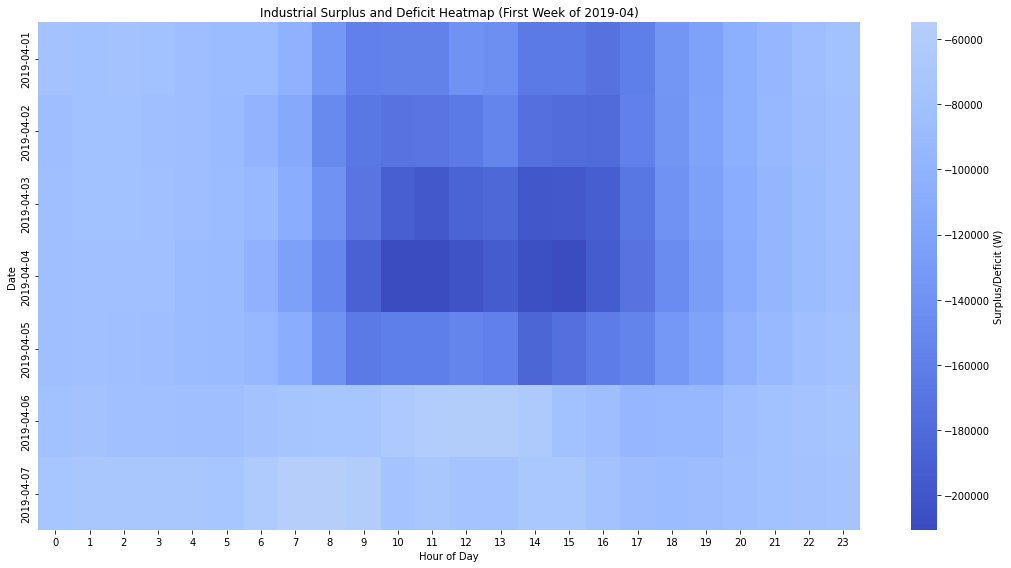

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


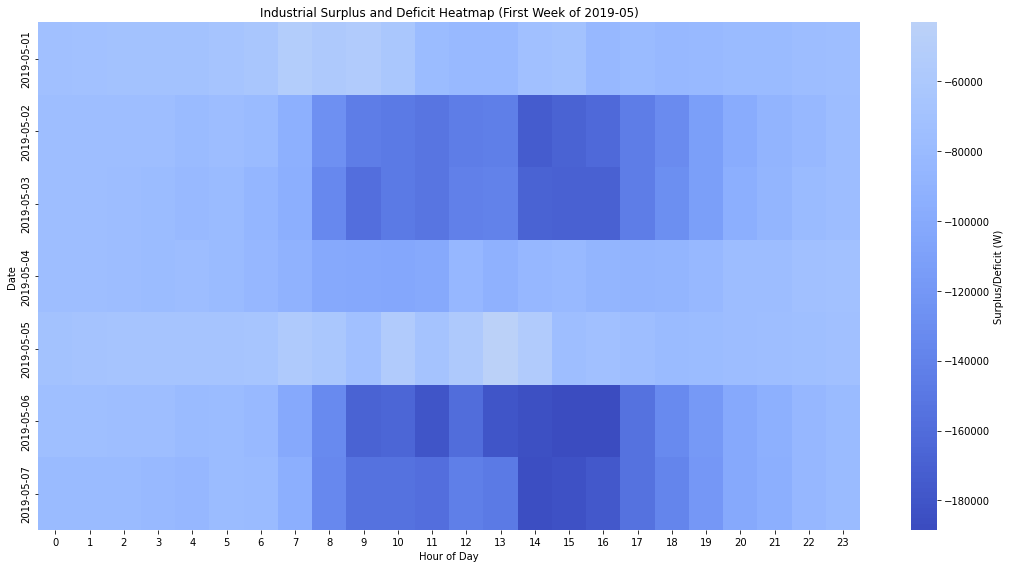

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


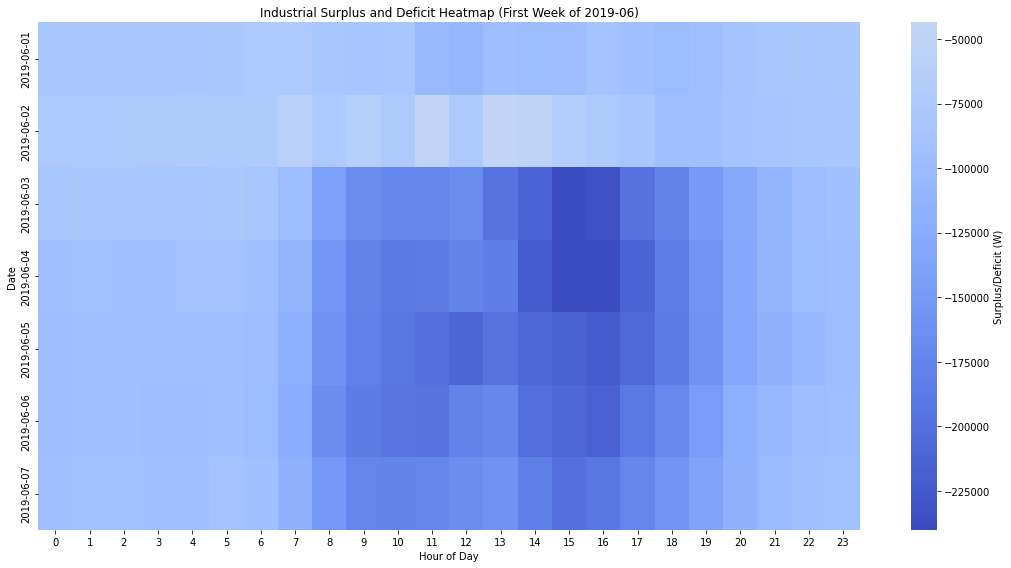

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


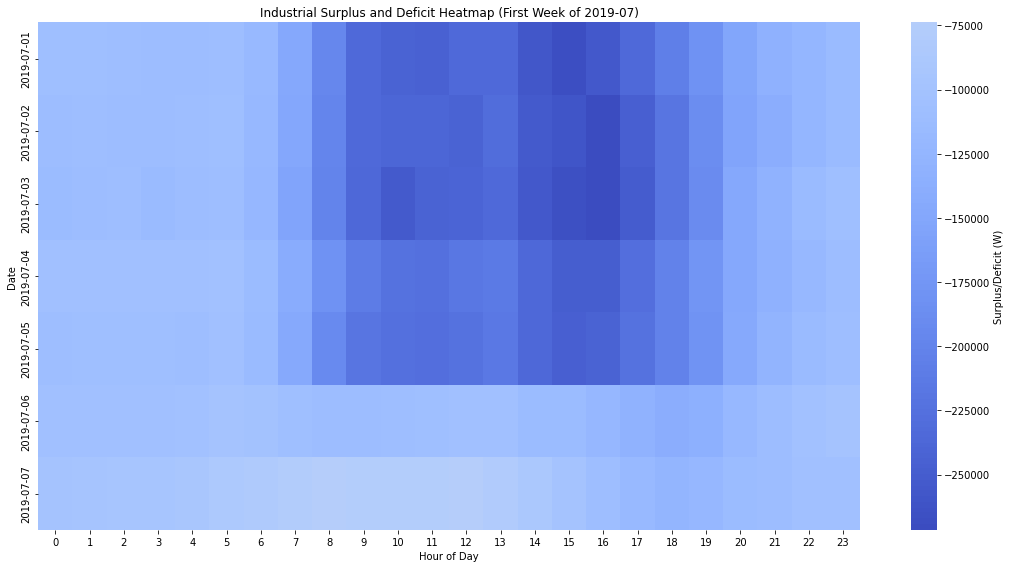

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


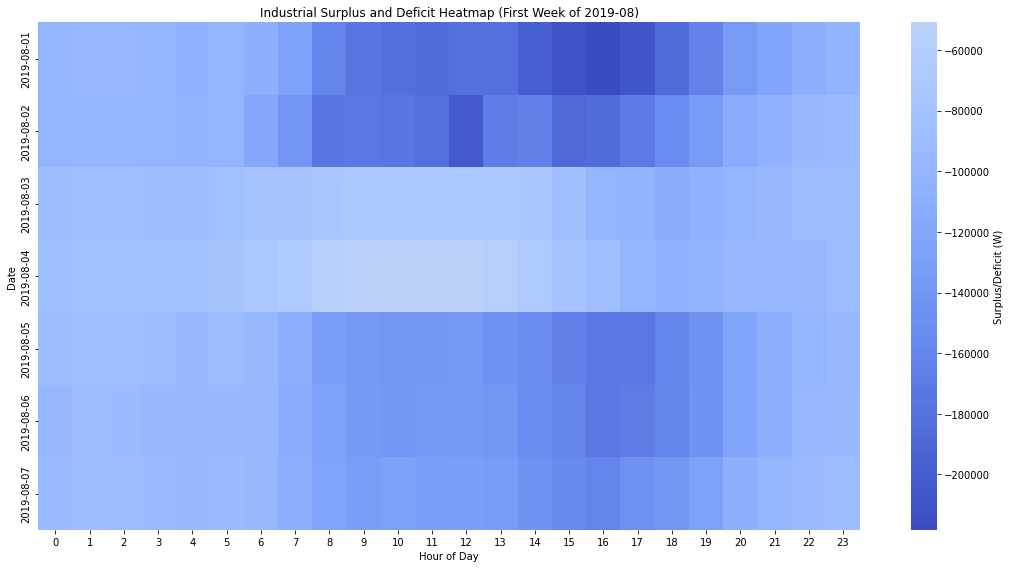

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


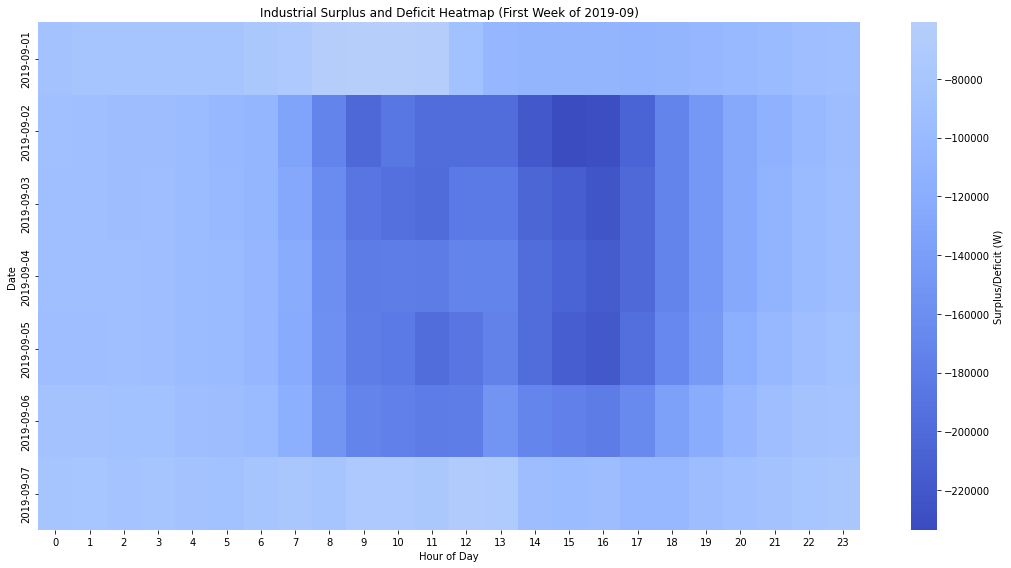

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


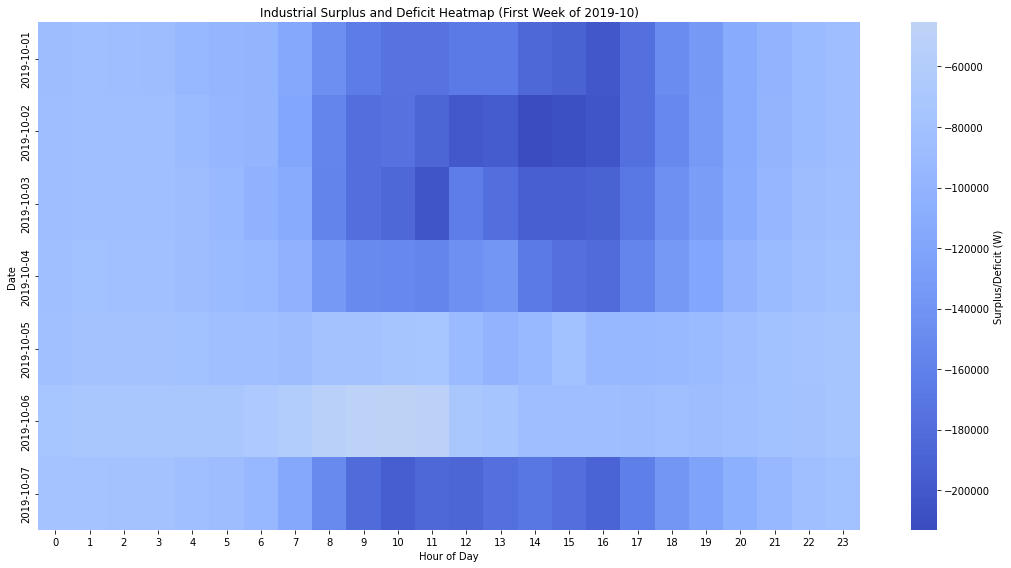

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


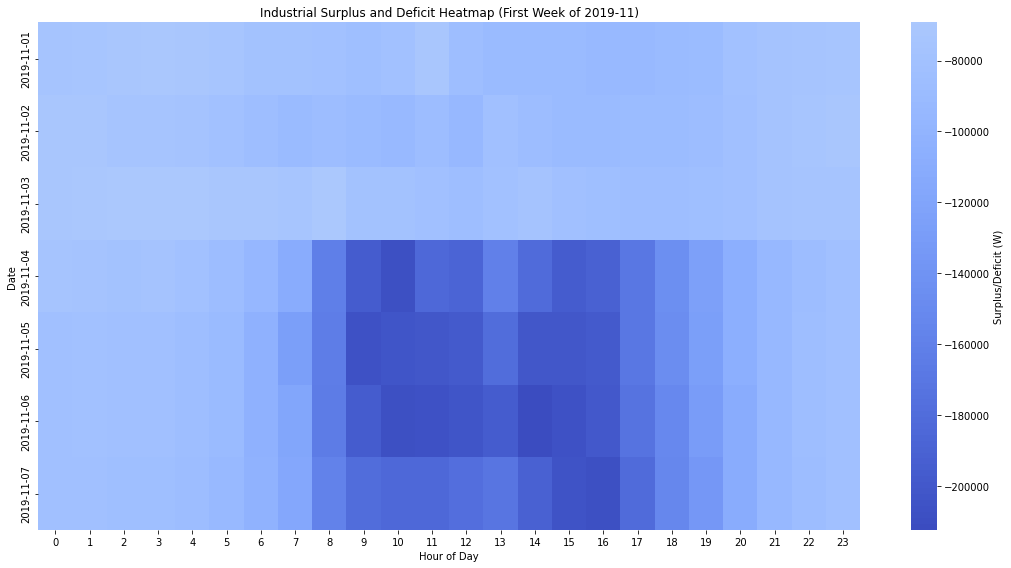

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


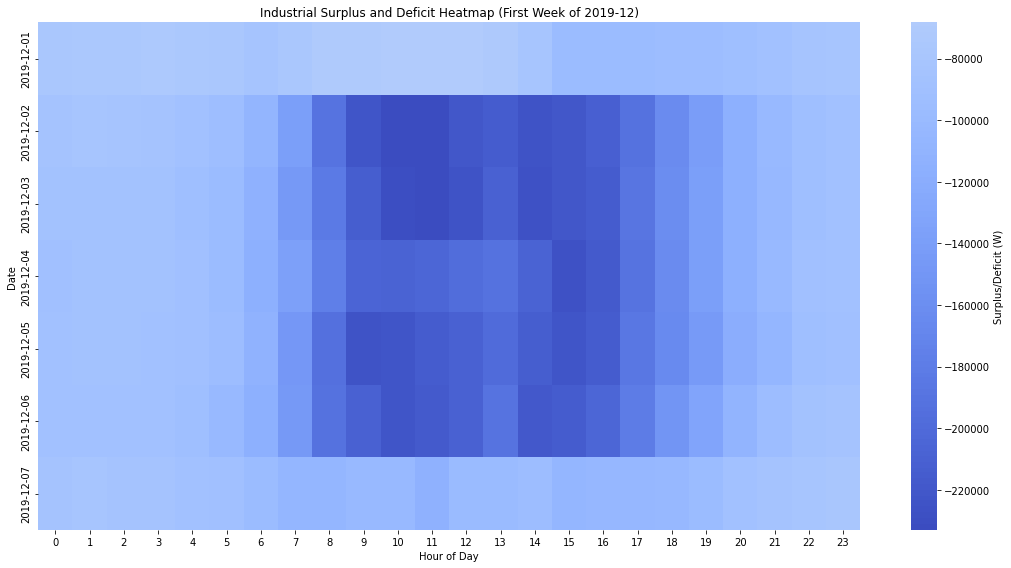

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


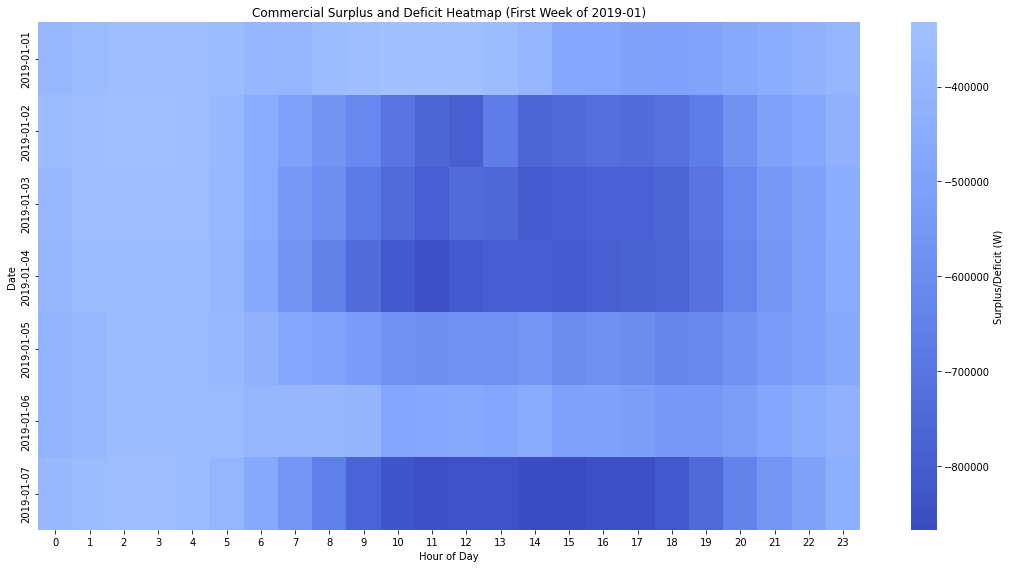

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


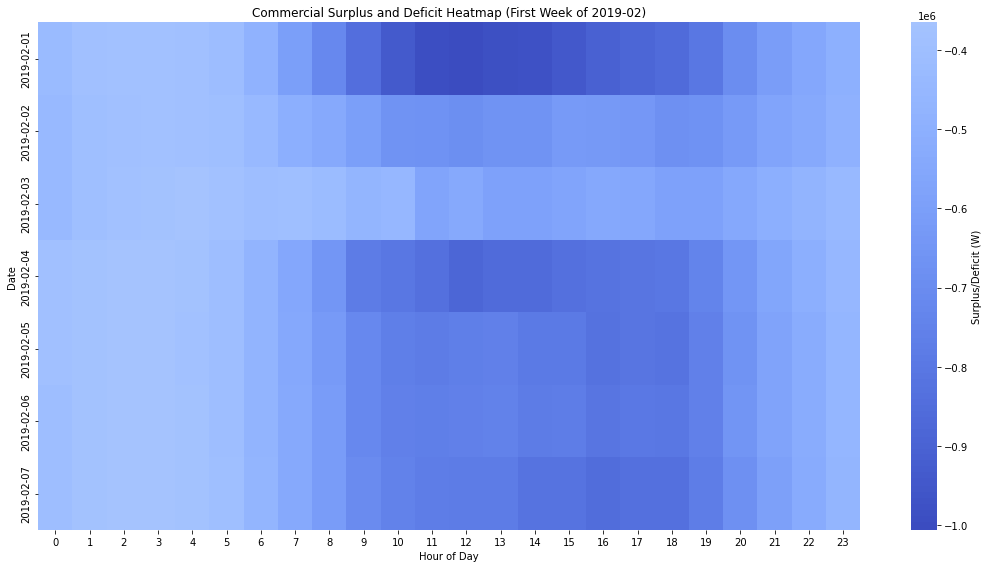

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


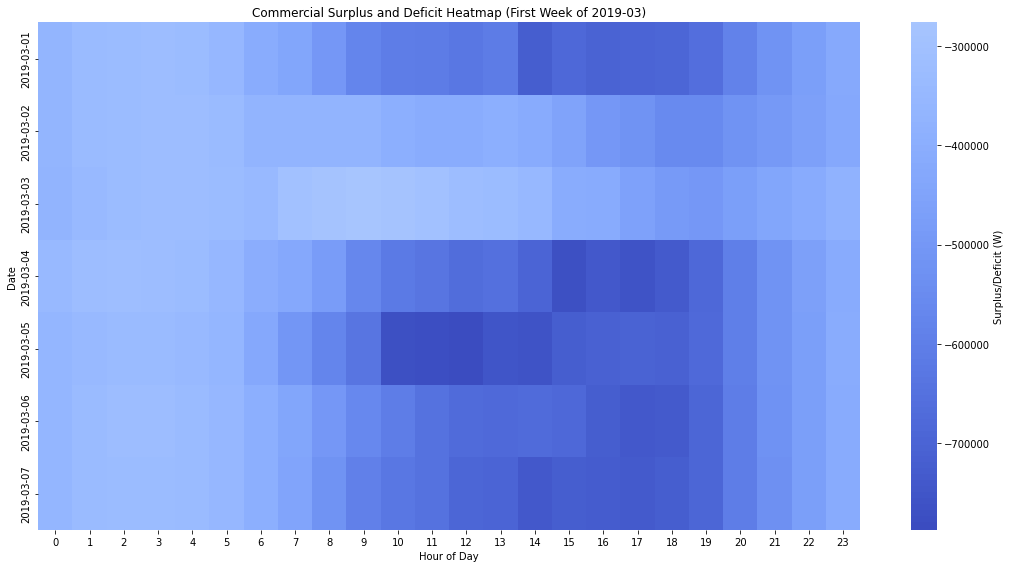

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


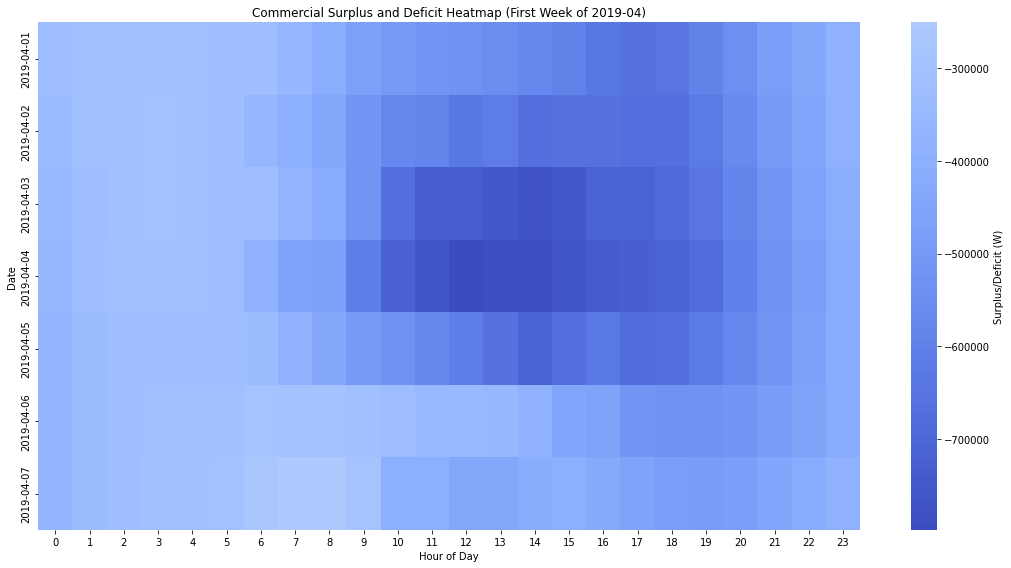

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


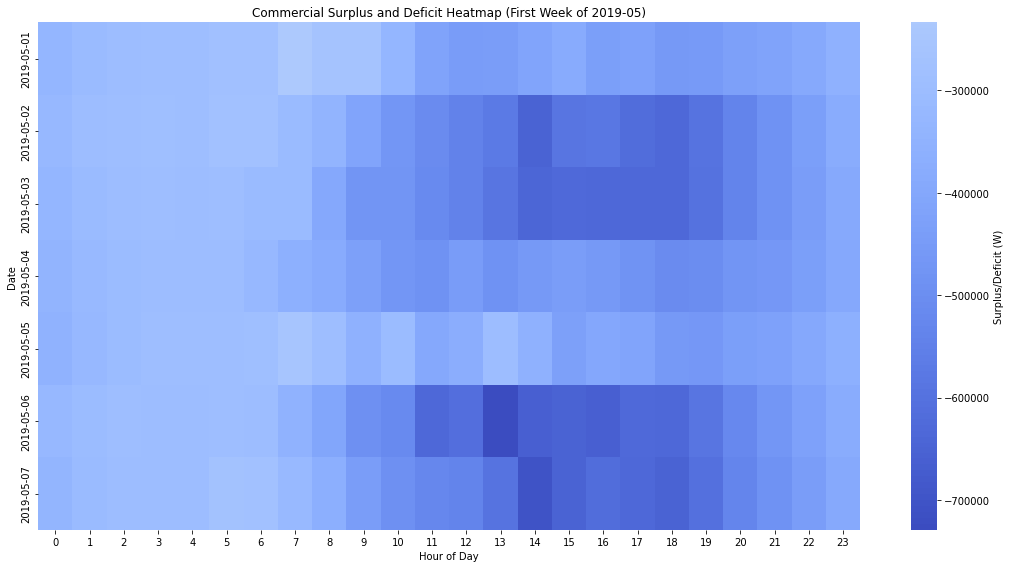

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


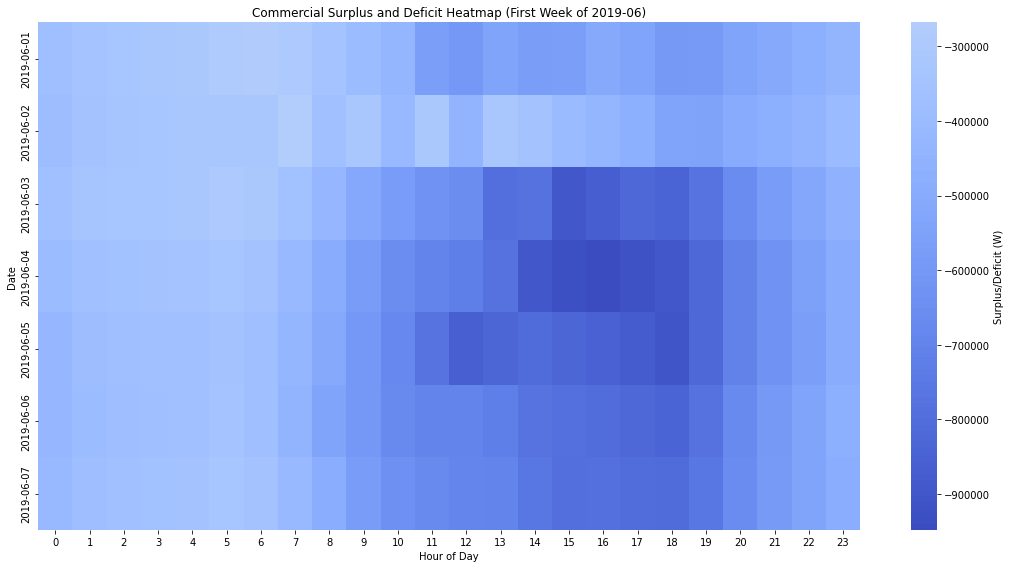

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


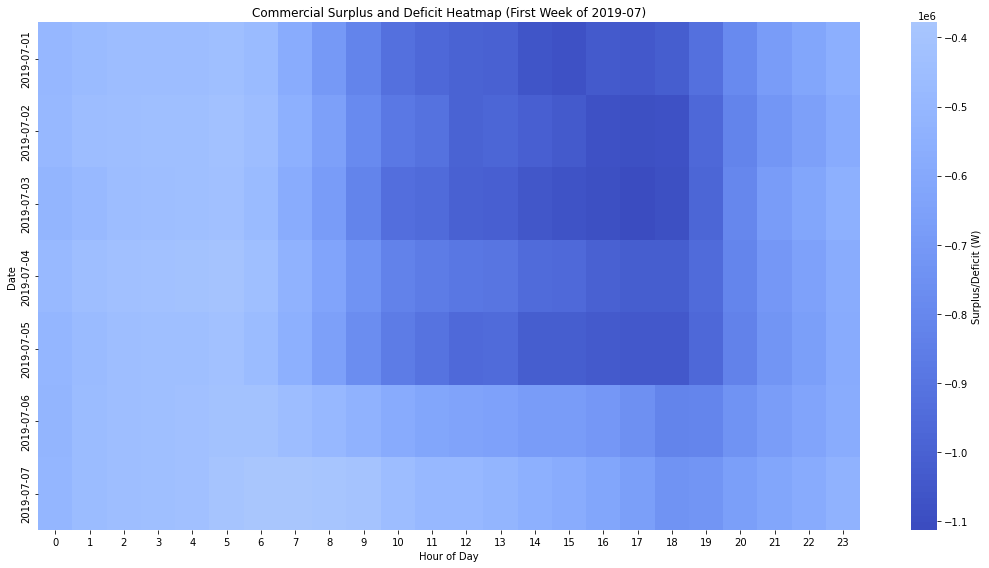

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


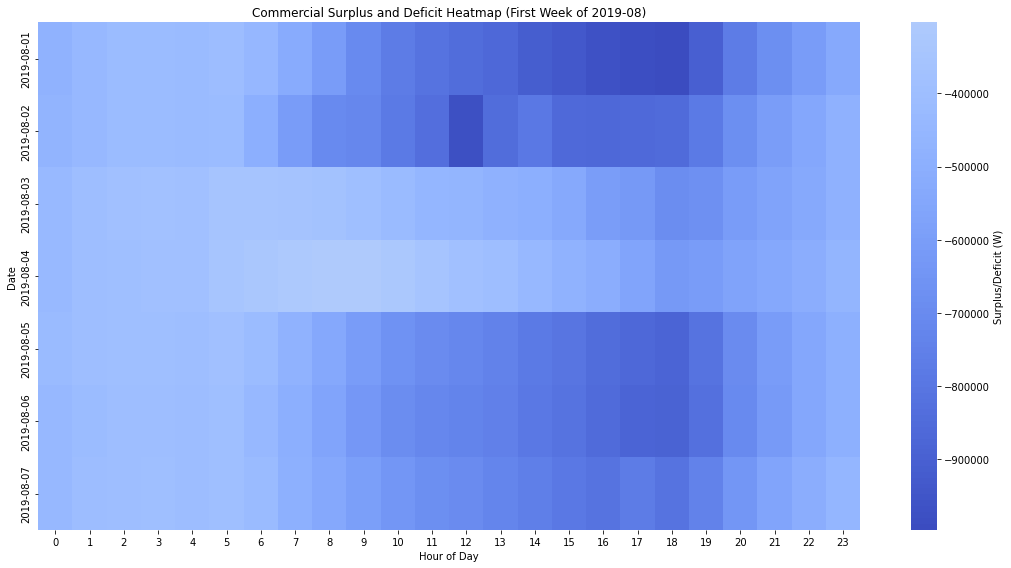

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


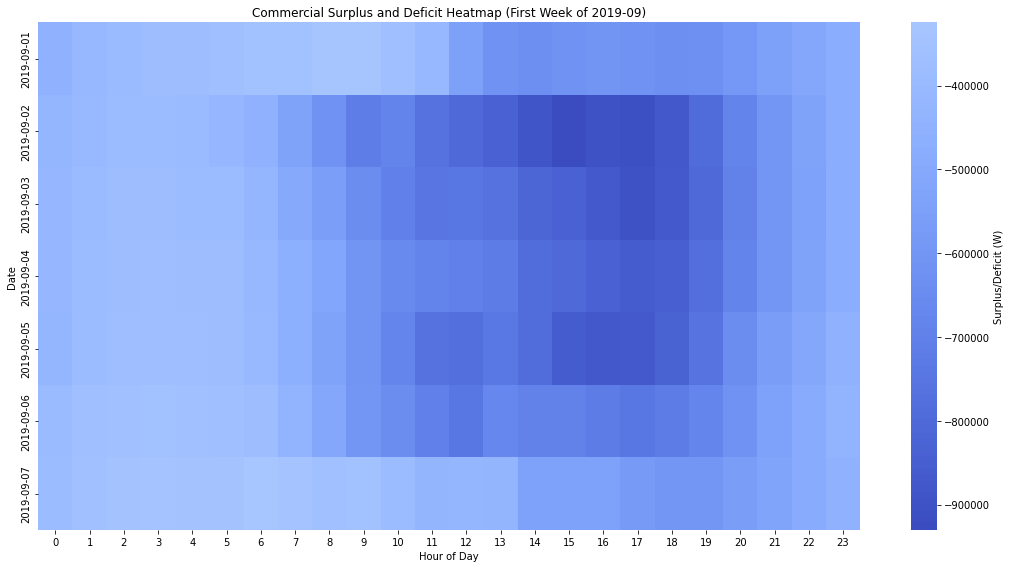

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


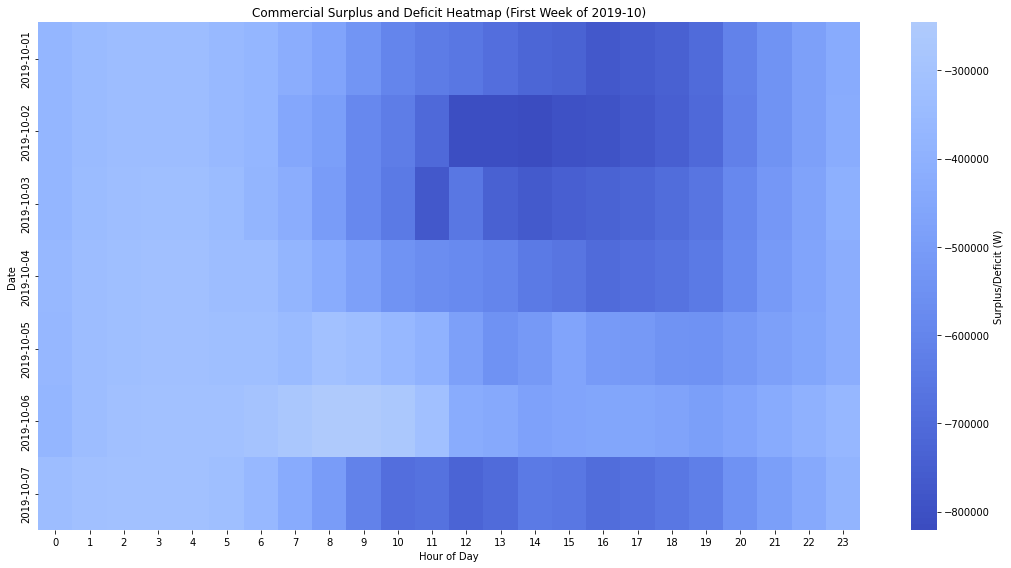

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


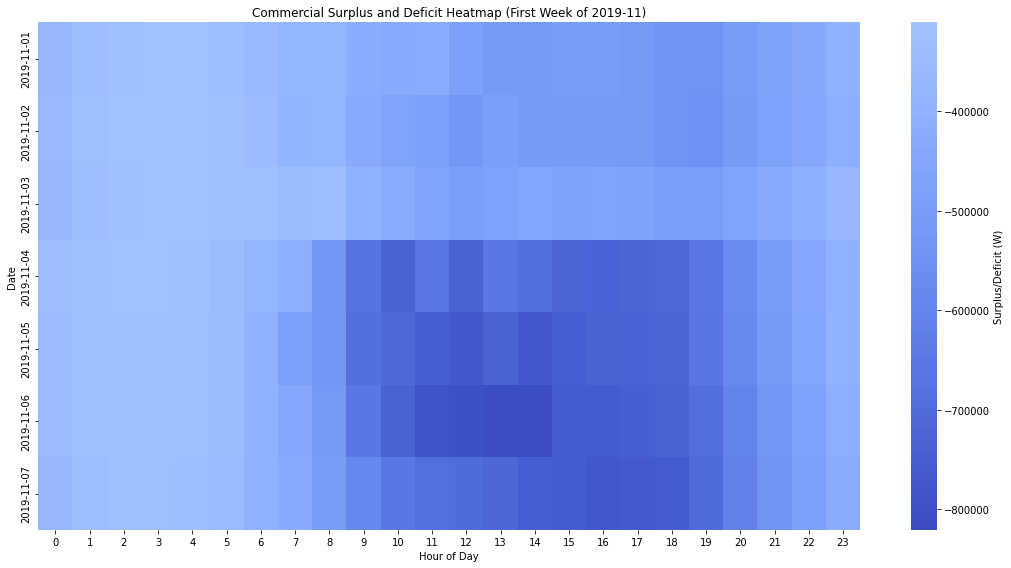

C:\Users\Nik\AppData\Local\Temp/ipykernel_17656/2442243872.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


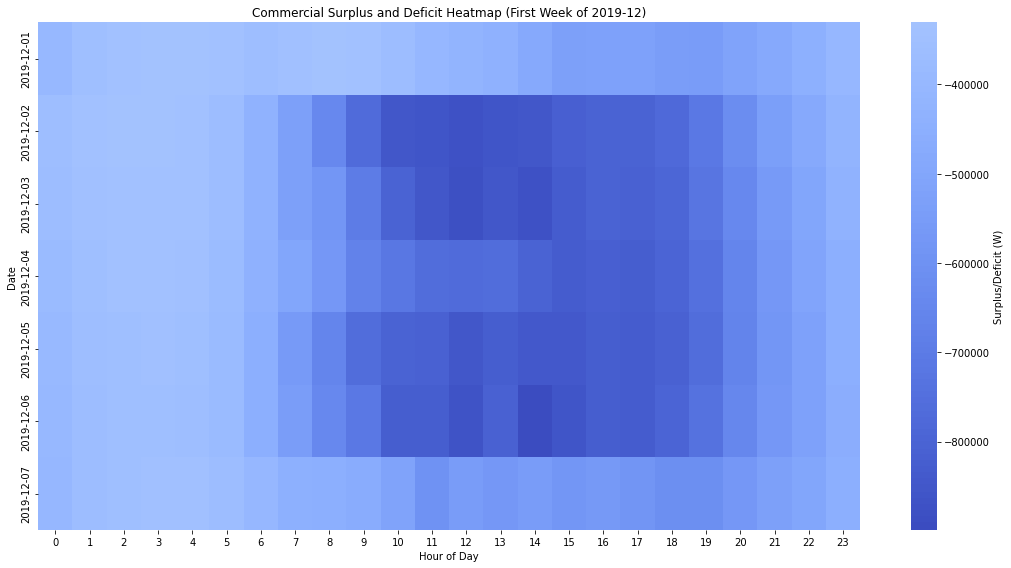

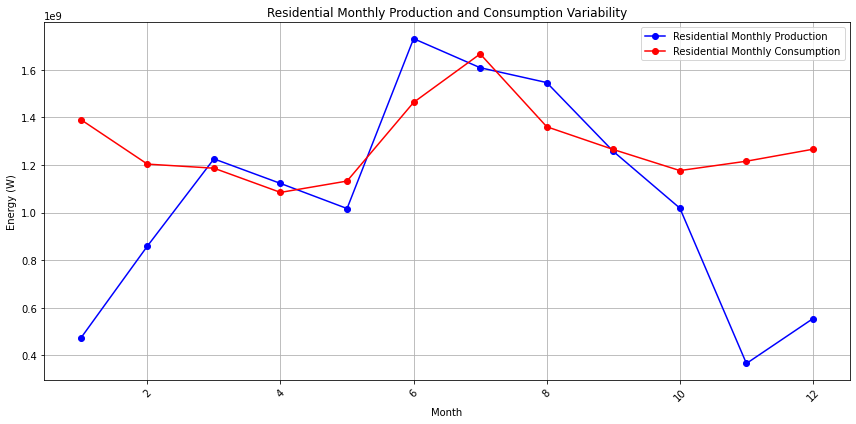

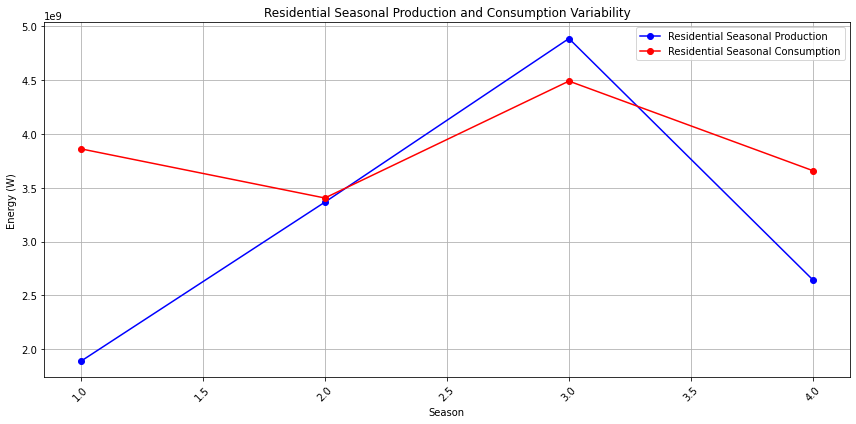

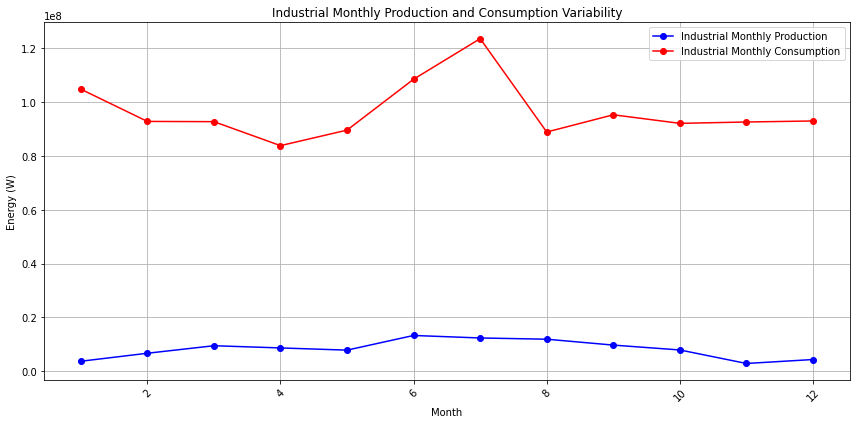

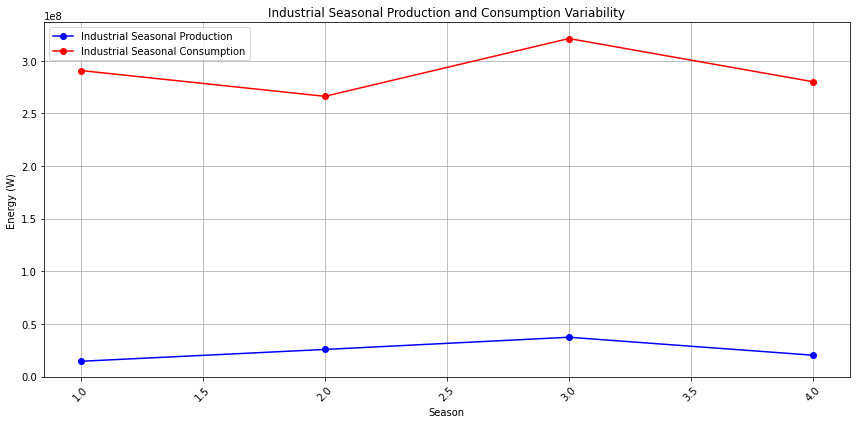

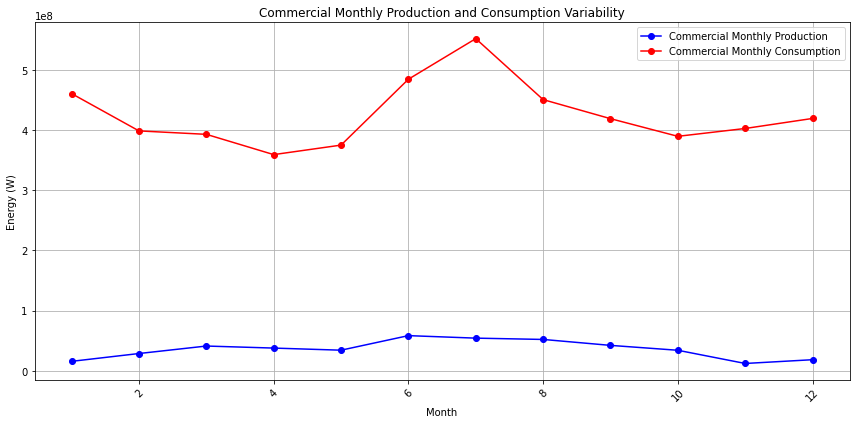

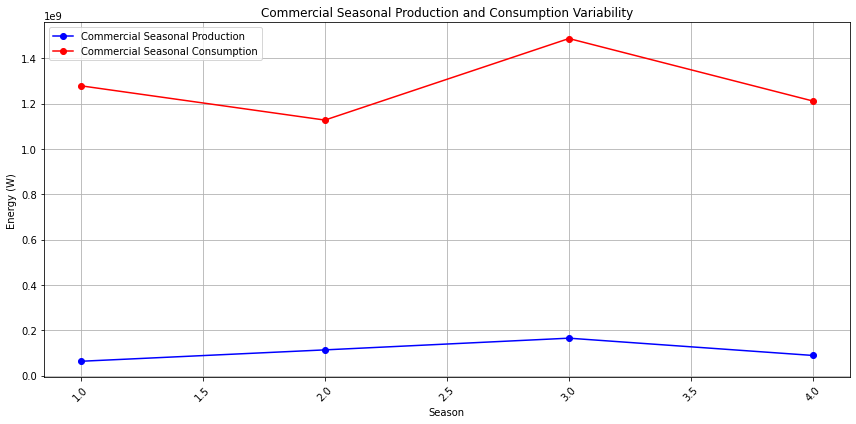

In [55]:
# 1. Peak Production and Consumption Analysis
def peak_analysis(production_df, consumption_df, category_name, area_max):
    # Calculate total production and consumption for each hour
    total_production = production_df.sum(axis=1)
    total_consumption = consumption_df[category_name] * area_max
    
    # Find peak production and consumption hours
    peak_production_hour = total_production.idxmax()
    peak_production_value = total_production.max()
    
    peak_consumption_hour = total_consumption.idxmax()
    peak_consumption_value = total_consumption.max()
    
    print(f"\nPeak Analysis for {category_name}:")
    print(f"Peak Production: {peak_production_value:.2f} W at {peak_production_hour}")
    print(f"Peak Consumption: {peak_consumption_value:.2f} W at {peak_consumption_hour}")
    
    # Plot peak production and consumption
    plt.figure(figsize=(12, 6))
    plt.plot(total_production.index, total_production, label=f'{category_name} Production', color='blue')
    plt.plot(total_consumption.index, total_consumption, label=f'{category_name} Consumption', color='red')
    plt.axvline(peak_production_hour, color='blue', linestyle='--', label='Peak Production')
    plt.axvline(peak_consumption_hour, color='red', linestyle='--', label='Peak Consumption')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title(f'{category_name} Peak Production and Consumption')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, f'{category_name}_Peak_Production_Consumption.png'))
    plt.show()

# Run peak analysis for each category
peak_analysis(Residential_user_production_df, DF_Consumption, 'Residential', Area_Res_Max)
peak_analysis(Industrial_user_production_df, DF_Consumption, 'Industrial', Area_Ind_Max)
peak_analysis(Commercial_user_production_df, DF_Consumption, 'Commercial', Area_Com_Max)

# 2. Energy Surplus and Deficit Analysis with Heatmap for Each First Week of the Month
def surplus_deficit_heatmap_first_week(production_df, consumption_df, category_name, area_max):
    # Loop through each month to filter the first week and plot
    for month in range(1, 13):
        start_date = f'2019-{month:02d}-01'
        end_date = f'2019-{month:02d}-07'

        # Filter data for the first week of the month
        week_production_df = production_df.loc[start_date:end_date]
        week_consumption_df = consumption_df.loc[start_date:end_date]

        # Calculate total production and consumption for each hour
        total_production = week_production_df.sum(axis=1)
        total_consumption = week_consumption_df[category_name] * area_max

        # Calculate surplus and deficit
        surplus_deficit = total_production - total_consumption

        # Prepare data for heatmap by pivoting the daily data into a matrix of days vs. hours
        daily_surplus_deficit = surplus_deficit.reset_index()
        daily_surplus_deficit.rename(columns={daily_surplus_deficit.columns[0]: 'Datetime'}, inplace=True)
        daily_surplus_deficit['Date'] = daily_surplus_deficit['Datetime'].dt.date
        daily_surplus_deficit['Hour'] = daily_surplus_deficit['Datetime'].dt.hour
        heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)

        # Plot the heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(heatmap_data, cmap='coolwarm', center=0, cbar_kws={'label': 'Surplus/Deficit (W)'})
        plt.title(f'{category_name} Surplus and Deficit Heatmap (First Week of {start_date[:7]})')
        plt.xlabel('Hour of Day')
        plt.ylabel('Date')
        plt.tight_layout()
        plt.savefig(os.path.join(weekly_plot_dir, f'{category_name}_Surplus_Deficit_Heatmap_Week_{month:02d}.png'))
        plt.show()

# Run surplus and deficit heatmap analysis for each category
surplus_deficit_heatmap_first_week(Residential_user_production_df, DF_Consumption, 'Residential', Area_Res_Max)
surplus_deficit_heatmap_first_week(Industrial_user_production_df, DF_Consumption, 'Industrial', Area_Ind_Max)
surplus_deficit_heatmap_first_week(Commercial_user_production_df, DF_Consumption, 'Commercial', Area_Com_Max)

# 4. Seasonal and Monthly Variability Analysis
def seasonal_monthly_variability(production_df, consumption_df, category_name, area_max):
    # Add 'Month' and 'Season' columns to DataFrames
    production_df['Month'] = production_df.index.month
    consumption_df['Month'] = consumption_df.index.month
    
    production_df['Season'] = production_df.index.to_series().dt.month % 12 // 3 + 1
    consumption_df['Season'] = consumption_df.index.to_series().dt.month % 12 // 3 + 1
    
    # Calculate monthly and seasonal total production and consumption
    monthly_production = production_df.groupby('Month').sum().sum(axis=1)
    monthly_consumption = consumption_df.groupby('Month')[category_name].sum() * area_max
    
    seasonal_production = production_df.groupby('Season').sum().sum(axis=1)
    seasonal_consumption = consumption_df.groupby('Season')[category_name].sum() * area_max
    
    # Plot monthly variability
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_production.index, monthly_production, label=f'{category_name} Monthly Production', marker='o', color='blue')
    plt.plot(monthly_consumption.index, monthly_consumption, label=f'{category_name} Monthly Consumption', marker='o', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title(f'{category_name} Monthly Production and Consumption Variability')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, f'{category_name}_Monthly_Variability.png'))
    plt.show()
    
    # Plot seasonal variability
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_production.index, seasonal_production, label=f'{category_name} Seasonal Production', marker='o', color='blue')
    plt.plot(seasonal_consumption.index, seasonal_consumption, label=f'{category_name} Seasonal Consumption', marker='o', color='red')
    plt.xlabel('Season')
    plt.ylabel('Energy (W)')
    plt.title(f'{category_name} Seasonal Production and Consumption Variability')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, f'{category_name}_Seasonal_Variability.png'))
    plt.show()

# Run seasonal and monthly variability analysis for each category
seasonal_monthly_variability(Residential_user_production_df, DF_Consumption, 'Residential', Area_Res_Max)
seasonal_monthly_variability(Industrial_user_production_df, DF_Consumption, 'Industrial', Area_Ind_Max)
seasonal_monthly_variability(Commercial_user_production_df, DF_Consumption, 'Commercial', Area_Com_Max)


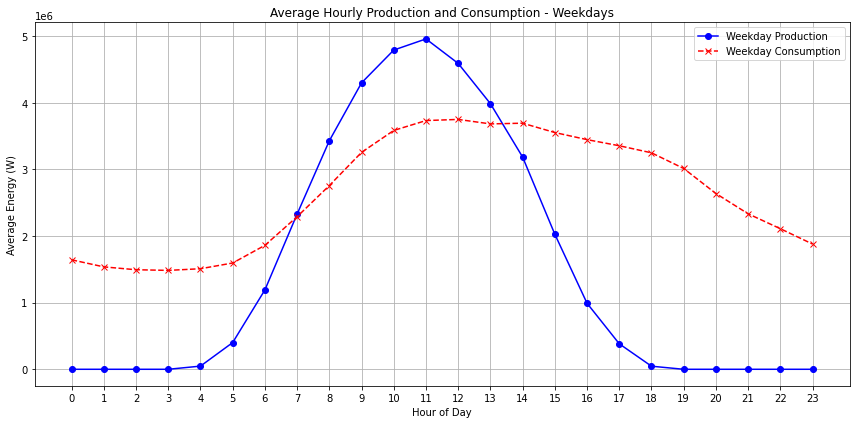

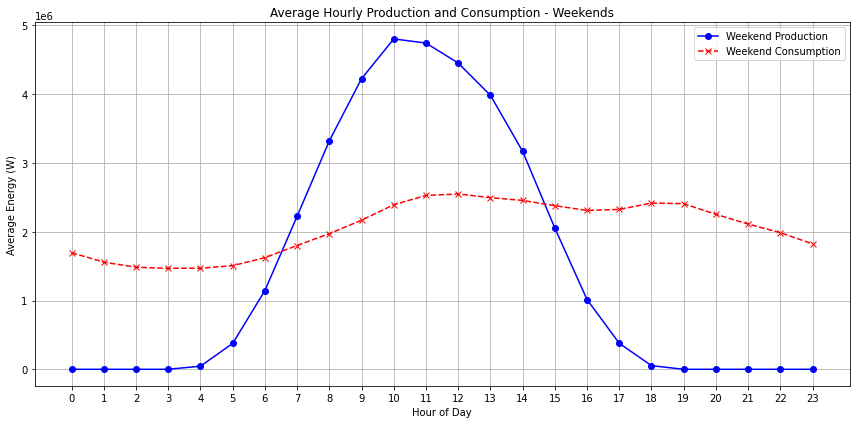

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure output directories exist
results_dir = "Results"
yearly_plot_dir = os.path.join(results_dir, 'Yearly_Plot')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(yearly_plot_dir):
    os.makedirs(yearly_plot_dir)

# Function to analyze weekday vs weekend production and consumption patterns
def weekday_weekend_analysis(production_dfs, consumption_df, area_maxes, category_names):
    # Combine production DataFrames for total production
    total_production_df = pd.concat(production_dfs, axis=1).sum(axis=1)  # Sum across all production DataFrames
    total_production_df = total_production_df.to_frame(name='Total Production')  # Convert to DataFrame

    # Add 'DayOfWeek', 'Hour' columns
    total_production_df['DayOfWeek'] = total_production_df.index.dayofweek  # Monday=0, Sunday=6
    total_production_df['Hour'] = total_production_df.index.hour

    # Add 'Weekday/Weekend' classification
    total_production_df['Type'] = total_production_df['DayOfWeek'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    # Ensure consumption DataFrame is indexed properly
    consumption_df['DayOfWeek'] = consumption_df.index.dayofweek
    consumption_df['Hour'] = consumption_df.index.hour
    consumption_df['Type'] = consumption_df['DayOfWeek'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    # Calculate average hourly production and consumption for weekdays and weekends
    avg_hourly_production = total_production_df.groupby(['Type', 'Hour'])['Total Production'].mean().reset_index()
    avg_hourly_consumption = consumption_df.groupby(['Type', 'Hour']).apply(
        lambda x: sum((x[category] * area_max).mean() for category, area_max in zip(category_names, area_maxes))
    ).reset_index(name='Total Consumption')

    # Plot average hourly production and consumption for weekdays
    plt.figure(figsize=(12, 6))
    weekday_production = avg_hourly_production[avg_hourly_production['Type'] == 'Weekday']
    weekday_consumption = avg_hourly_consumption[avg_hourly_consumption['Type'] == 'Weekday']
    plt.plot(weekday_production['Hour'], weekday_production['Total Production'], label='Weekday Production', linestyle='-', marker='o', color='blue')
    plt.plot(weekday_consumption['Hour'], weekday_consumption['Total Consumption'], label='Weekday Consumption', linestyle='--', marker='x', color='red')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy (W)')
    plt.title('Average Hourly Production and Consumption - Weekdays')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Average_Hourly_Production_Consumption_Weekday.png'))
    plt.show()

    # Plot average hourly production and consumption for weekends
    plt.figure(figsize=(12, 6))
    weekend_production = avg_hourly_production[avg_hourly_production['Type'] == 'Weekend']
    weekend_consumption = avg_hourly_consumption[avg_hourly_consumption['Type'] == 'Weekend']
    plt.plot(weekend_production['Hour'], weekend_production['Total Production'], label='Weekend Production', linestyle='-', marker='o', color='blue')
    plt.plot(weekend_consumption['Hour'], weekend_consumption['Total Consumption'], label='Weekend Consumption', linestyle='--', marker='x', color='red')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy (W)')
    plt.title('Average Hourly Production and Consumption - Weekends')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Average_Hourly_Production_Consumption_Weekend.png'))
    plt.show()

# Run weekday vs weekend analysis for total production and consumption
weekday_weekend_analysis(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)


# Extra